# Operations and Inventory Management
Monitor the availability, occupancy and efficient operation of tourist accommodations.

**Objective**  
This part is dedicated to Operations and Inventory analysis of tourist accommodations.

**Objective Sprint 3**  
How does the number of bedrooms, bathrooms, and beds affect the average availability of accommodations?  
Does it differ between cities?

**Description and characteristics of dataset**  
Pre-processed dataframe with tourist accommodations listings.

In [1]:
# import libraries 
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import scipy.stats as stats
import seaborn as sns
import shap
import statsmodels.api as sm
import statsmodels.formula.api as smf

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import correlation_report, plot_correlation_matrix
from pygam import LinearGAM, LogisticGAM, s
from scipy.stats import kruskal
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings("ignore")

In [2]:
# font sizes
plt.rcParams['figure.titlesize'] = 18 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14             
plt.rcParams['axes.labelsize'] = 14  

plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12       
plt.rcParams['legend.fontsize'] = 12

# display settings
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
 
# set palette
custom_palette = ['#4e6e81', '#a79e9c', '#b3bcc3', 
                  '#f2f1f1', '#888f96', '#256fb6', 
                  '#ecf0f5', '#354859', '#f69731']
sns.set_palette(custom_palette)

sns.set_style("whitegrid")

In [3]:
PATH = 'Data'
FILENAME = f'Tourist_Accommodation07042025.csv'

RANDOM_STATE = 42

# level of significance
ALPHA = .05

## Data Loading

In [4]:
# define function to read file
def read_file(filename):
    
    """Input: number of sprint.
    Function reads .csv data of desired sprint. 
    Output: Dataframe or error.
    """
    
    # reading file
    try:
        df = pd.read_csv(os.path.join('..', PATH, filename), 
                         parse_dates=['insert_date', 'first_review_date', 'last_review_date'])
        display(df.head())
        return df
    except Exception as error:
        print("An exception occurred:", error)
        return error      

In [5]:
data = read_file(FILENAME)

apartment_id                                               name  \
0         11964                                 A ROOM WITH A VIEW   
1         21853                               Bright and airy room   
2         32347  Explore Cultural Sights from a Family-Friendly...   
3         35379                  Double 02 CasanovaRooms Barcelona   
4         35801                  Can Torras Farmhouse Studio Suite   

                                         description  host_id  \
0  Private bedroom in our attic apartment. Right ...    45553   
1  We have a quiet and sunny room with a good vie...    83531   
2  Open French doors and step onto a plant-filled...   139939   
3  Room at a my apartment. Kitchen and 2 bathroom...   152232   
4  Lay in bed & watch sunlight change the mood of...   153805   

                neighbourhood_name neighbourhood_district        room_type  \
0                           Centro                    NaN     Private room   
1                         C�rmenes                 Latina     Private room   
2                      San Vicente          Casco Antiguo  Entire home/apt   
3  l'Antiga Esquerra de l'Eixample               Eixample     Private room   
4                            Quart                    NaN     Private room   

   accommodates  bathrooms  bedrooms  beds  \
0             2       2.00      1.00  1.00   
1             1       1.00      1.00  1.00   
2             4       1.00      2.00  2.00   
3             2       2.00      1.00  1.00   
4             5       1.00      2.00  5.00   

                                      amenities_list  price  minimum_nights  \
0  TV,Internet,Wifi,Air conditioning,Elevator,Buz... 400.00               3   
1  TV,Internet,Wifi,Air conditioning,Kitchen,Free... 170.00               4   
2  TV,Internet,Wifi,Air conditioning,Wheelchair a... 990.00               2   
3  TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu... 400.00               2   
4  Wifi,Pool,Free parking on premises,Breakfast,P... 900.00               1   

   maximum_nights  has_availability  availability_30  availability_60  \
0             365                 1                7               20   
1              40                 1                0                0   
2             120                 1               26               31   
3             730                 1                9               23   
4             180                 1                0               19   

   availability_90  availability_365  number_of_reviews first_review_date  \
0               40               130                 78        2010-01-02   
1                0               162                 33        2014-10-10   
2               31               270                148        2011-01-05   
3               49               300                292        2012-03-13   
4               49               312                 36        2011-07-08   

  last_review_date  review_scores_rating  review_scores_accuracy  \
0       2017-09-05                970.00                  100.00   
1       2018-07-15                920.00                   90.00   
2       2019-07-22                980.00                  100.00   
3       2020-01-04                940.00                  100.00   
4       2018-08-08                970.00                  100.00   

   review_scores_cleanliness  review_scores_checkin  \
0                     100.00                 100.00   
1                      90.00                 100.00   
2                     100.00                 100.00   
3                      90.00                 100.00   
4                     100.00                 100.00   

   review_scores_communication  review_scores_location  review_scores_value  \
0                       100.00                  100.00               100.00   
1                       100.00                   80.00                90.00   
2                       100.00                  100.00               100.00   
3           

## Data Overview

In [6]:
# define function to display information about the data
def data_info(df):
   
    """Input: dataframe.
    Function displays basic information, 
    checks for duplicates and NaN. 
    """
    
    # get information about the data
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())

    # check for NaN
    if df.isna().sum().sum() > 0:
        print()
        print('\033[1mNumber of missing values')
        display(
            pd.DataFrame({'number': df.isna().sum(), 
                          'percentage': df.isna().mean().mul(100)})
            .query('number > 0')
            .sort_values(by='number', ascending=False)
        )
    else:
        print('There are no NaNs in the data\n')
    
    # check for duplicates (without id columns)
    print()
    if df.duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')

In [8]:
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null 

apartment_id                   9650
name                           9614
description                    9459
host_id                        7268
neighbourhood_name              521
neighbourhood_district           61
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             24
amenities_list                 9492
price                           418
minimum_nights                   49
maximum_nights                  147
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              2159
last_review_date               1513
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


number  percentage
neighbourhood_district         3790       39.27
review_scores_value            2640       27.36
review_scores_location         2640       27.36
review_scores_checkin          2639       27.35
review_scores_accuracy         2634       27.30
review_scores_communication    2630       27.25
review_scores_cleanliness      2628       27.23
review_scores_rating           2625       27.20
last_review_date               2523       26.15
reviews_per_month              2522       26.13
first_review_date              2522       26.13
price                           241        2.50
description                     134        1.39
bathrooms                        72        0.75
bedrooms                         70        0.73
beds                             45        0.47
amenities_list                   16        0.17
name                              3        0.03


There are no full duplicates in the data



## EDA

In [9]:
df = data[['apartment_id', 'insert_date', 'standardized_city',
           'bathrooms', 'bedrooms', 'beds',
           'availability_30', 'availability_60', 'availability_90', 'availability_365']]
df = df.rename(columns={"standardized_city": "city"})

In [10]:
# "property size" columns
property_features = ['bathrooms', 'bedrooms', 'beds']

# time windows
periods = [30, 60, 90, 365]

# city order by number of listings
city_order = df['city'].value_counts().index

In [11]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   apartment_id      9650 non-null   int64         
 1   insert_date       9650 non-null   datetime64[ns]
 2   city              9650 non-null   object        
 3   bathrooms         9578 non-null   float64       
 4   bedrooms          9580 non-null   float64       
 5   beds              9605 non-null   float64       
 6   availability_30   9650 non-null   int64         
 7   availability_60   9650 non-null   int64         
 8   availability_90   9650 non-null   int64         
 9   availability_365  9650 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 754.0+ KB
None

Number of unique values


apartment_id        9650
insert_date          164
city                   8
bathrooms             14
bedrooms              15
beds                  24
availability_30       31
availability_60       61
availability_90       91
availability_365     366
dtype: int64


Number of missing values


number  percentage
bathrooms      72        0.75
bedrooms       70        0.73
beds           45        0.47


There are no full duplicates in the data



In [12]:
# descriptive statistics
df.drop(['apartment_id', 'insert_date'], axis=1).describe().T

count   mean    std  min   25%    50%    75%    max
bathrooms        9578.00   1.59   0.99 0.00  1.00   1.00   2.00  13.00
bedrooms         9580.00   1.94   1.38 0.00  1.00   2.00   3.00  50.00
beds             9605.00   2.92   2.27 0.00  1.00   2.00   4.00  30.00
availability_30  9650.00  13.05  11.87 0.00  0.00  11.00  26.00  30.00
availability_60  9650.00  28.80  23.04 0.00  2.00  29.00  53.00  60.00
availability_90  9650.00  46.14  33.84 0.00  9.00  49.00  80.00  90.00
availability_365 9650.00 187.62 130.99 0.00 66.00 182.00 318.00 365.00

### Availability

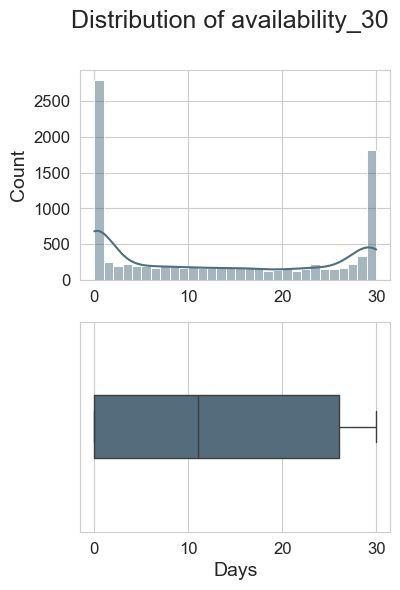

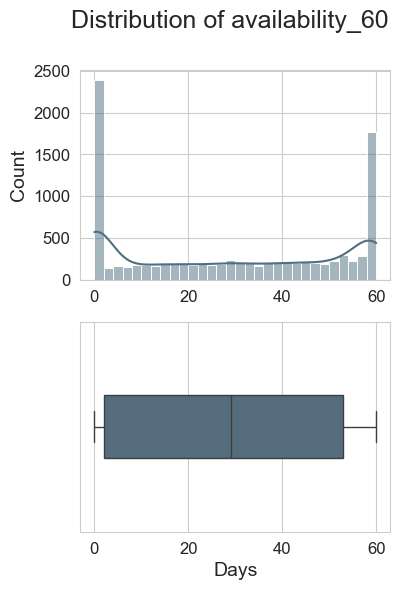

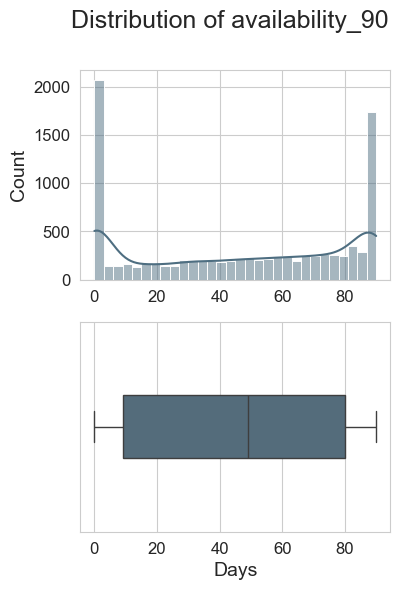

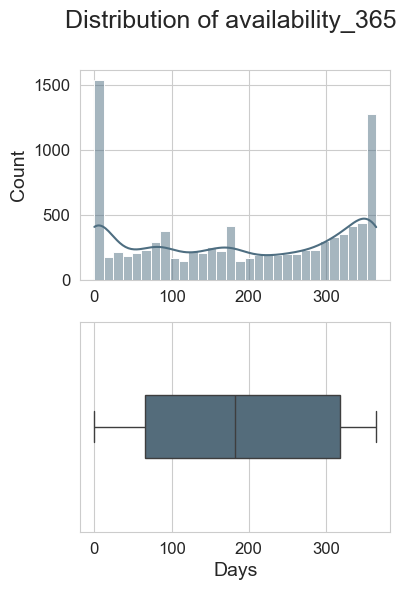

In [13]:
# distribution of nubers of available days in the different terms 
for per in periods:
    col = f'availability_{per}'
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    fig.suptitle(f"Distribution of {col}")
    
    # histogram
    sns.histplot(data=df[col]
                  , kde=True, bins=30
                  , ax=axs[0]).set(xlabel=None)
    
    # boxplot
    (sns.boxplot(data=df, ax=axs[1], x=col, width=0.3, orient='h')
        .set(yticklabels=[], xlabel='Days')
    )
    plt.show()

### Number of bathrooms, bedrooms, beds

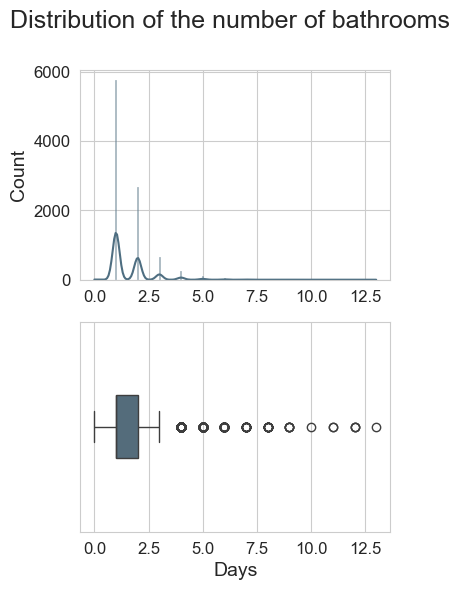

bathrooms
0.00       21
1.00     5774
2.00     2682
3.00      650
4.00      262
5.00      103
6.00       43
7.00       18
8.00       13
9.00        5
10.00       1
11.00       2
12.00       3
13.00       1
Name: count, dtype: int64


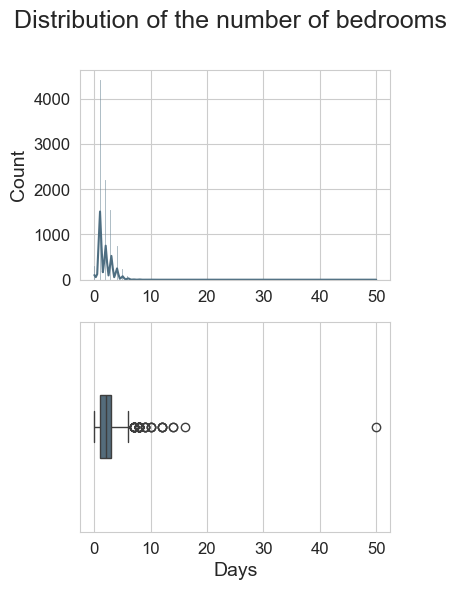

bedrooms
0.00      300
1.00     4422
2.00     2209
3.00     1548
4.00      737
5.00      227
6.00       89
7.00       17
8.00       16
9.00        4
10.00       3
12.00       4
14.00       2
16.00       1
50.00       1
Name: count, dtype: int64


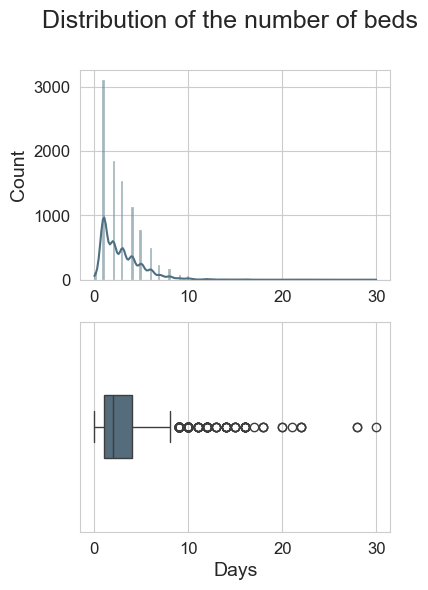

beds
0.00      121
1.00     3112
2.00     1840
3.00     1531
4.00     1137
5.00      768
6.00      495
7.00      225
8.00      162
9.00       70
10.00      63
11.00       9
12.00      26
13.00       5
14.00       9
15.00       5
16.00      14
17.00       1
18.00       3
20.00       2
21.00       1
22.00       3
28.00       2
30.00       1
Name: count, dtype: int64


In [14]:
# distribution of number of beds, bedrooms and bathrooms 
for col in property_features:
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    fig.suptitle(f'Distribution of the number of {col}')
    
    # histogram
    sns.histplot(data=df[col]
                  , kde=True
                  , ax=axs[0]).set(xlabel=None)
    
    # boxplot
    (sns.boxplot(data=df, ax=axs[1], x=col, width=0.3, orient='h')
        .set(yticklabels=[], xlabel='Days')
    )
    plt.show()
    print(df[col].value_counts().sort_index())

## Data Cleaning
### Missing values

In [15]:
data[data[property_features].isna().all(1)]

apartment_id         name  \
1869      10294590  Yacht Lodge   

                                            description   host_id  \
1869  Mit dem Ambiente der Natur und einer Ruhe die ...  52962256   

     neighbourhood_name neighbourhood_district        room_type  accommodates  \
1869  Palma de Mallorca                    NaN  Entire home/apt             1   

      bathrooms  bedrooms  beds  \
1869        NaN       NaN   NaN   

                                         amenities_list   price  \
1869  Wifi,Kitchen,Breakfast,Family/kid friendly,Saf... 2800.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
1869               1            1125                 1               30   

      availability_60  availability_90  availability_365  number_of_reviews  \
1869               60               90               365                  0   

     first_review_date last_review_date  review_scores_rating  \
1869               NaT              NaT                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
1869                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
1869                    NaN                          NaN   

      review_scores_location  review_scores_value  is_instant_bookable  \
1869                     NaN                  NaN                    1   

      reviews_per_month country      city insert_date standardized_city  \
1869                NaN   spain  mallorca  2019-03-25             Palma   

     standardized_neighbourhood autonomous_community  has_reviews  
1869          Palma de Mallorca       Islas Baleares        False

In [16]:
data[data[['bedrooms', 'beds']].isna().all(1)]

apartment_id                               name  \
1869      10294590                        Yacht Lodge   
3524      17279931                           Rocafort   
9276      41973111  Cosy apartment in Barcelona heart   

                                            description    host_id  \
1869  Mit dem Ambiente der Natur und einer Ruhe die ...   52962256   
3524  Modern bright apartment, perfect for seeing th...    4257381   
9276  Ce studio est id�al si vous voulez s�journer a...  332264819   

                  neighbourhood_name neighbourhood_district        room_type  \
1869               Palma de Mallorca                    NaN  Entire home/apt   
3524  la Nova Esquerra de l'Eixample               Eixample     Private room   
9276                        el Raval           Ciutat Vella  Entire home/apt   

      accommodates  bathrooms  bedrooms  beds  \
1869             1        NaN       NaN   NaN   
3524             2       1.00       NaN   NaN   
9276             4       1.00       NaN   NaN   

                                         amenities_list   price  \
1869  Wifi,Kitchen,Breakfast,Family/kid friendly,Saf... 2800.00   
3524  TV,Wireless Internet,Air conditioning,Kitchen,... 1850.00   
9276  TV,Wifi,Air conditioning,Kitchen,Heating,Washe...  900.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
1869               1            1125                 1               30   
3524               2               7                 0                0   
9276               1            1125                 1               30   

      availability_60  availability_90  availability_365  number_of_reviews  \
1869               60               90               365                  0   
3524                0               19                19                  0   
9276               60               84               162                  0   

     first_review_date last_review_date  review_scores_rating  \
1869               NaT              NaT                   NaN   
3524               NaT              NaT                   NaN   
9276               NaT              NaT                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
1869                     NaN                        NaN   
3524                     NaN                        NaN   
9276                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
1869                    NaN                          NaN   
3524                    NaN                          NaN   
9276                    NaN                          NaN   

      review_scores_location  review_scores_value  is_instant_bookable  \
1869                     NaN                  NaN                    1   
3524                     NaN                  NaN                    0   
9276                     NaN                  NaN                    1   

      reviews_per_month country       city insert_date standardized_city  \
1869                NaN   spain   mallorca  2019-03-25             Palma   
3524                NaN   spain  barcelona  2017-03-06         Barcelona   
9276                NaN   spain  barcelona  2020-04-16         Barcelona   

          standardized_neighbourhood autonomous_community  has_reviews  
1869               Palma de Mallorca       Islas Baleares        False  
3524  La Nova Esquerra de l'Eixample             Cataluña        False  
9276                        El Raval             Cataluña        False

In [17]:
data[data[['bedrooms', 'bathrooms']].isna().all(1)]

apartment_id         name  \
1869      10294590  Yacht Lodge   

                                            description   host_id  \
1869  Mit dem Ambiente der Natur und einer Ruhe die ...  52962256   

     neighbourhood_name neighbourhood_district        room_type  accommodates  \
1869  Palma de Mallorca                    NaN  Entire home/apt             1   

      bathrooms  bedrooms  beds  \
1869        NaN       NaN   NaN   

                                         amenities_list   price  \
1869  Wifi,Kitchen,Breakfast,Family/kid friendly,Saf... 2800.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
1869               1            1125                 1               30   

      availability_60  availability_90  availability_365  number_of_reviews  \
1869               60               90               365                  0   

     first_review_date last_review_date  review_scores_rating  \
1869               NaT              NaT                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
1869                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
1869                    NaN                          NaN   

      review_scores_location  review_scores_value  is_instant_bookable  \
1869                     NaN                  NaN                    1   

      reviews_per_month country      city insert_date standardized_city  \
1869                NaN   spain  mallorca  2019-03-25             Palma   

     standardized_neighbourhood autonomous_community  has_reviews  
1869          Palma de Mallorca       Islas Baleares        False

In [18]:
data[data[['bathrooms', 'beds']].isna().all(1)]

apartment_id                                               name  \
1869      10294590                                        Yacht Lodge   
9134      40792051                           Room in Eixample Rosello   
9198      41389150                                      Buen ambiente   
9467      43454335  Habitaci�n  1 con cama doble y mesa de escritorio   
9526      44158321                               Single room Eixample   

                                            description    host_id  \
1869  Mit dem Ambiente der Natur und einer Ruhe die ...   52962256   
9134  Place located in the Exiample area, very close...  317033592   
9198  Es exterior, y est� bien ubicado, metro y autob�s  317024865   
9467  Se alquila habitaci�n doble en coqueto piso a ...   64805231   
9526  Single room in a 3rd female flat. The age of t...   51251904   

                  neighbourhood_name neighbourhood_district        room_type  \
1869               Palma de Mallorca                    NaN  Entire home/apt   
9134  la Nova Esquerra de l'Eixample               Eixample     Private room   
9198             la Verneda i la Pau             Sant Mart�     Private room   
9467                           Sants         Sants-Montju�c     Private room   
9526          la Dreta de l'Eixample               Eixample     Private room   

      accommodates  bathrooms  bedrooms  beds  \
1869             1        NaN       NaN   NaN   
9134             2        NaN      1.00   NaN   
9198             2        NaN      1.00   NaN   
9467             1        NaN      1.00   NaN   
9526             1        NaN      1.00   NaN   

                                         amenities_list   price  \
1869  Wifi,Kitchen,Breakfast,Family/kid friendly,Saf... 2800.00   
9134  Wifi,Kitchen,Smoking allowed,Heating,Washer,Fi...  340.00   
9198  First aid kit, Hair dryer, Hangers, Long term ...  190.00   
9467  TV,Wifi,Air conditioning,Kitchen,Heating,Washe...  170.00   
9526  Wifi,Kitchen,Heating,Washer,Essentials,Lock on...  160.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
1869               1            1125                 1               30   
9134               3              31                 1                0   
9198              31             105                 1               30   
9467              30            1125                 1               30   
9526              31              90                 1               29   

      availability_60  availability_90  availability_365  number_of_reviews  \
1869               60               90               365                  0   
9134                0                0                 0                  1   
9198               60               90               180                  0   
9467               60               90               365                  0   
9526               59               89               179                  0   

     first_review_date last_review_date  review_scores_rating  \
1869               NaT              NaT                   NaN   
9134        2019-12-19       2019-12-19               1000.00   
9198               NaT              NaT                   NaN   
9467               NaT              NaT                   NaN   
9526               NaT              NaT                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
1869                     NaN                        NaN   
9134                  100.00                     100.00   
9198                     NaN                        NaN   
9467                     NaN                        NaN   
9526                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
1869                    NaN                          NaN   
9134                 100.00                       100.00   
9198                    NaN                          NaN   
9467                    NaN                          Na

In [19]:
for col in property_features:
    print(f'Number of objects without {col.upper()}')
    print(data[data[col].isna()].room_type.value_counts())
    print()

Number of objects without BATHROOMS
room_type
Private room       39
Entire home/apt    32
Hotel room          1
Name: count, dtype: int64

Number of objects without BEDROOMS
room_type
Entire home/apt    53
Private room       17
Name: count, dtype: int64

Number of objects without BEDS
room_type
Private room       37
Entire home/apt     6
Hotel room          1
Shared room         1
Name: count, dtype: int64



### Outliers and atypical values
#### Number of bathrooms

In [20]:
# big number of BATHROOMS
data[data['bathrooms']>8]

apartment_id                                               name  \
1118       5429715                         Cal Pubill de Ciuret 35pax   
1982      11183000  Villa private Pool near the beach, Barbecue / ...   
1984      11196074                   Finca can Domingo Es Trenc beach   
2901      15033343  Son Siliano, countryhouse in Sant Llorens, Mal...   
4741      20397361     Idyllische Finca mit Pool, Garten, Tiere, WLAN   
5258      22129737           Terraced house with 6 bedrooms on 700 m�   
6677      27042895   Finca Can Corem - 12 guests - LUXURY and comfort   
7378      30917851  CAN GRAU (CAN GRAU 24) - Villa for 24 people i...   
8134      34523812       NEW RESIDENCE IN MADRID 50 INDIVIDUALS ROOMS   
8733      37733216     Relax en ambiente rural - hasta 20 personas*G*   
8827      38376278                                      Residencia 24   
9091      40550295  Idyllischer Fincaurlaub f�r Biker inkl. Fr�hst�ck   

                                            description    host_id  \
1118  Cal Pubill de Ciuret �s una de les grans masie...   20320423   
1982  The villa has  7  bedrooms <br />Dining room<b...   58206528   
1984  At the heart of the Balearic archipelago, sout...   16964951   
2901  Holiday house with private pool in Sant Lloren...   81580920   
4741  Der Agrotourismo Can Agustin hat zwei gro�e Fe...   57603545   
5258  Terraced house 700 m�, 6 sovev�relser, 9 badev...  154044310   
6677  Can Corem is an impressive luxurious and elega...   26015333   
7378  Welcome to this impressive finca for 24 people...   80839530   
8134  Full building of 52 rooms, with 10 bathrooms, ...  130100816   
8733  Mientras dure el Estado de Alarma en Espa�a s�...   10547296   
8827                                                NaN  100756477   
9091  Das Agroturismo Finca Son Miranda befindet sic...   11125218   

              neighbourhood_name neighbourhood_district        room_type  \
1118                       Vidr�                    NaN  Entire home/apt   
1982                        Este                    NaN  Entire home/apt   
1984                      Campos                    NaN  Entire home/apt   
2901  Sant Lloren� des Cardassar                    NaN  Entire home/apt   
4741  Sant Lloren� des Cardassar                    NaN  Entire home/apt   
5258             Santa Margalida                    NaN  Entire home/apt   
6677                     Manacor                    NaN  Entire home/apt   
7378                   Sencelles                    NaN  Entire home/apt   
8134                  Pradolongo                  Usera  Entire home/apt   
8733                     Bordils                    NaN  Entire home/apt   
8827                    Pollen�a                    NaN  Entire home/apt   
9091                   Sencelles                    NaN     Private room   

      accommodates  bathrooms  bedrooms  beds  \
1118            16       9.00     14.00 30.00   
1982            16      10.00      7.00 18.00   
1984            16      12.00     10.00 16.00   
2901            10       9.00      9.00 13.00   
4741            16      11.00     12.00 22.00   
5258            12      11.00      6.00 12.00   
6677            12       9.00      6.00  6.00   
7378            24      12.00     12.00 21.00   
8134             1      12.00     50.00  1.00   
8733            16       9.00      8.00 14.00   
8827            12       9.00      6.00  6.00   
9091            16      13.00     12.00 28.00   

                                         amenities_list   price  \
1118  TV, Indoor fireplace, Pool, Iron, Crib, Hair d...     NaN   
1982  First aid kit, Kitchen, Rice Maker, Hot water,... 3230.00   
1984  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
2901  Oven, Wifi, Garden or backyard, Coffee maker, ...     NaN   
4741  TV,Cable TV,Wifi,Pool,Kitchen,Free parking on ... 1700.00   
5258  TV,Cable TV,Wifi,Air conditioning,Kitchen,Heat... 2580.00   
6677  Dryer, Dishwasher, Garden or backyard, Wifi

In [21]:
# BATHROOMS = 0
with pd.option_context('display.max_colwidth', None):
    display(data[data['bathrooms']==0][['description', 'room_type',
                                'accommodates', 'bathrooms', 
                                'bedrooms', 'beds']])

description  \
19    The best room in Barcelona!  Nice room, in a central and quiet part of Barcelona. Very near of the beach. With fast WIFI of course. In my opini�n, the best option for rest after one jorney discovering this amazing city. HELLO!  My name is Carmen, and I've got a newly renovated apartment in central Barcelona for your holiday in this cosmopolitan city! For rent is a bedroom for two people. The room is spacious, bright and quiet, and the apartment is very nice, spacious, bright and well kept... with a huge balcony!  WHAT DOES THE PRICE INCLUDE? Night in a double bed, sheets, towels, wardrobe, and access to the entire apartment (also the kitchen, which is fully equipped). And WIFI WHAT IS NOT INCLUDED? Noise. The windows and balcony overlook a quiet pedestrian street, so that you can rest well. (this is important, in city center usually there are so noise) In the flat there are 3 rooms, you are booking for one, and there are other for other guests, and other for me. You can use all apartme   
30            Place to relax after a long day exploring Barcelona.  La Sagrada Familia? My house is 4 blocks.  People coming for parties are NOT WELCOME. Small room: very quiet, no parties. Reading this description before booking. There is an option, which is to send a message to host. The room is ONLY FOR sightseeing NOT for students, workers , etc. LGBT. Before sending the booking ... I hope a message, ALWAYS.      Only for people who come to barcelona for sightseeing: not room to live or students.      People coming for parties are NOT WELCOME.      Very quiet place, located in neighborhood of Gracia, one of the busiest area of Barcelona, just 4 blocks from the Sagrada Familia, 10 minutes walking to Sant Pau Hospital, and 4 metro stops from the Parc G�ell. You will visit 3 emblematic places of Barcelona, walking: La Sagrada Familia, Parc Guell; Sant Pau Hospital.      This room is for ONE person, simple and very useful. It has a window, but not direct sunlight. The room has fans and heati   
242   SUNNY and comfortable apartment for 2 people in the very historical centre of Barcelona 300 metres from Las Ramblas!  The apartment is composed of one bedroom, living room, full equiped kitchen, bathroom with bath and a SUNNY TERRACE. Lots of sunshine inside home. Views from the balcony to the sea and to the mountain. REAL PICTURES NO PHOTOSHOP! I took the pictures myself with my Iphone... All furnitures are new.  VERY COMFORTABLE VISCOLASTIC MATRESS. Sofa, tv, full equiped kitchen, fridge, oven microwaves, washing machine, towels, linen. Everything you need for a perfect and comfortable stay.  HIGH SPEED INTERNET WIFI. IMPECCABLE CLEANNIG.  ELEVATOR IN THE BUILDING.   3 minutes walking to La Rambla. Close to all main attractions in the historical centre like the Cathedreal, the Gotic Area, Boqueria Market, Santa Maria del Mar Church, Picasso Museum, Columbus monument, etc. Next to the Port Vell and to the Maremagnum shopping center. Very lively area with hundreds of restaurants, theat   
375                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   La habitaci�n es bastante amplia, con armario empotrados y una mesa con dos sillas para poder trabajar.  El wifi va bastante r�pido. Desde luego, se pueden usar las zonas comunes. No alquilo la habitacion solo por una noche en fin de semana. La habitaci�n en exterior, con vistas a la Plaza de la paja, muy luminosa pero silenciosa. Es muy bonita y tiene un armario doble empotrado y un es

In [22]:
# BATHROOMS = 0. room types
data[data['bathrooms']==0][['room_type', 'bedrooms']].value_counts().sort_index()

room_type        bedrooms
Entire home/apt  0.00         1
                 1.00         3
                 2.00         2
                 3.00         1
                 5.00         1
Private room     1.00        11
                 2.00         1
Name: count, dtype: int64

In [23]:
# BATHROOMS = 0 and BEDROOMS > 1
with pd.option_context('display.max_colwidth', None):
    display(data[(data['bathrooms']==0) & (data['bedrooms']>1)]
             [['description', 'room_type','accommodates', 'bathrooms', 'bedrooms', 'beds']])

description  \
4196  Very nice house in the village of Palau-Saverdera, ideal for a relaxing holiday away from stress. Located in the middle of the village, the house is distributed on three floors. On the ground floor there is a very large garage where you can park two cars, and a bathroom, ideal to take a shower on your way back from the beach. The first floor consists of: living / dining room with terrace, kitchen equipped with gas stove, oven and microwave, 3 bedrooms (each one with two single beds) and a bathroom. On the second and last floor is a large sunny terrace with a beautiful panoramic view over the bay of Roses and the Pyrenees. There is also a versatile enclosed space. Palau-Saverdera is highly appreciated by lovers of hiking and is the ideal place to enjoy an authentic and peaceful holiday in the Alt Emporda. ANIMALS NOT ALLOWED. HUTG-028962The established price of the stay will be added the amount of 0,90 � per person per night with a maximum of 7 nights and only for occupants over 16 year   
7718                                                                                                                                                                                                                                                                             Espectacular apartamento en el centro de Madrid. <br />Dividido en dos pisos. Cuenta con 3 ba�os, 5 habitaciones (2 dobles con ba�o y 3 individuales). <br />Con todas las necesidades de un hogar como cocina o sal�n.<br />Acogedor y moderno.<br /><br /><b>The space</b><br />Los hu�spedes podr�n disfrutar de plancha, toallas, utensilios de cocina, microondas, platos, etc.<br />El apartamento est� a 5 min de Plaza de Espa�a.<br />5 min de la C/Gran V�a.<br />2 min del Templo de Debod.<br />Metros:<br />- Ventura Rodriguez (l�nea 3).<br />- Plaza de Espa�a (l�neas 3 y 10).<br />La calle cuenta con Restaurante, supermercados, bancos, cines, etc<br /><br /><b>Guest access</b><br />Uso y disfrute de cualquier zona del apartamento.   
7959                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Apartment very well equipped in beautiful building with large garden area and salt water pool, located in a quiet area of Santa Margarita. WITH AIR CONDITIONING. FREE WIFI AT THE HALL OF THE BUILDING. ANIMALS NOT ALLOWED 50m2 for 6 pers.: 1 bed x 1,40 + bunk bed (2 beds x 90) + sofa-bed x 1,40. 15m2 terraceThe established price of the stay will be added the amount of 0,90 � per person per night with a maximum of 7 nights and only for occupants over 16 years as a tax on stays in tourist establishments. Law 5/2012 approved on March 20, 2012.   
8312                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

----- 
It is possible that there is no bathroom in the property, especially for private rooms, which may have a 'shared bathroom.' However, if there is no bathroom and more than one bedroom, this is unusual. Upon reviewing the description, it can be observed that in such cases, having 0 bathrooms is likely an error. **We can replace these values with NaN.**

#### Number of bedrooms and beds

In [24]:
data[data['bedrooms']==50]

apartment_id                                          name  \
8134      34523812  NEW RESIDENCE IN MADRID 50 INDIVIDUALS ROOMS   

                                            description    host_id  \
8134  Full building of 52 rooms, with 10 bathrooms, ...  130100816   

     neighbourhood_name neighbourhood_district        room_type  accommodates  \
8134         Pradolongo                  Usera  Entire home/apt             1   

      bathrooms  bedrooms  beds  \
8134      12.00     50.00  1.00   

                                         amenities_list  price  \
8134  TV,Wifi,Kitchen,Elevator,Heating,Washer,Smoke ... 250.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
8134               1            1125                 1               30   

      availability_60  availability_90  availability_365  number_of_reviews  \
8134               60               90               365                  0   

     first_review_date last_review_date  review_scores_rating  \
8134               NaT              NaT                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
8134                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
8134                    NaN                          NaN   

      review_scores_location  review_scores_value  is_instant_bookable  \
8134                     NaN                  NaN                    1   

      reviews_per_month country    city insert_date standardized_city  \
8134                NaN   spain  madrid  2019-06-07            Madrid   

     standardized_neighbourhood   autonomous_community  has_reviews  
8134                 Pradolongo  Comunidad de Madrid          False

In [25]:
with pd.option_context('display.max_colwidth', None):
    print(data[data['bedrooms'] == 50].description)

8134    Full building of 52 rooms, with 10 bathrooms, 4 dining rooms, 10 kitchens and living room of almost 50 meters with sofas and TV, elevator. There are two types of rooms, single and double, the individual ones have a bed, table, study table and individual closet. The doubles have two single beds, two bedside tables and two study tables and double wardrobe. Building recently opened in May 2019 with comprehensive reform, completely brand new, both furniture and equipment. Nuestro edificio cuenta con la posibilidad de adaptarse a un �nico hasta 52 hu�spedes, Existe una persona en la finca para solventar cualquier problema que pudiera surgir, aunque estamos convencidos de que la estancia ser� muy agradable. La zona es residencial y tranquila, frente a un parque, en uno de los barrios m�s antiguos de Madrid y cerca de Madrid R�o para practicar tus deportes favoritos. En un radio 5-15 minutos tienes acceso a todos los medios de transporte, tanto tren de cercan�as, como metro y varias l

-------
This is very strange object - let's decide to drop all this row.

In [26]:
# big number of BEDROOMS
data[data['bedrooms'] > 9]

apartment_id                                               name  \
1118       5429715                         Cal Pubill de Ciuret 35pax   
1342       6695341                      charming 200 year old �finca�   
1984      11196074                   Finca can Domingo Es Trenc beach   
2484      13576820           Villa Pima. Costa Brava (for 24 people).   
3116      15883302                                        Ca's Misser   
4405      19412149                 Mallaui, a whole palace by the sea   
4741      20397361     Idyllische Finca mit Pool, Garten, Tiere, WLAN   
5987      24228419                                  Lobos - Llucmajor   
7378      30917851  CAN GRAU (CAN GRAU 24) - Villa for 24 people i...   
8134      34523812       NEW RESIDENCE IN MADRID 50 INDIVIDUALS ROOMS   
9091      40550295  Idyllischer Fincaurlaub f�r Biker inkl. Fr�hst�ck   

                                            description    host_id  \
1118  Cal Pubill de Ciuret �s una de les grans masie...   20320423   
1342  Located in the heart of the wine growing count...    3774266   
1984  At the heart of the Balearic archipelago, sout...   16964951   
2484  Ideal house for group or families (up to 24 pe...   51811531   
3116  Beautiful rustic farm with a total area of 21,...  102986764   
4405  Do you want to live in a Mediterranean villa, ...  136087677   
4741  Der Agrotourismo Can Agustin hat zwei gro�e Fe...   57603545   
5987  The country house in Llucmajor has 10 bedrooms...   96145168   
7378  Welcome to this impressive finca for 24 people...   80839530   
8134  Full building of 52 rooms, with 10 bathrooms, ...  130100816   
9091  Das Agroturismo Finca Son Miranda befindet sic...   11125218   

              neighbourhood_name neighbourhood_district        room_type  \
1118                       Vidr�                    NaN  Entire home/apt   
1342                     Consell                    NaN  Entire home/apt   
1984                      Campos                    NaN  Entire home/apt   
2484                    Vidreres                    NaN  Entire home/apt   
3116                     Algaida                    NaN  Entire home/apt   
4405       Ciutadella de Menorca                    NaN  Entire home/apt   
4741  Sant Lloren� des Cardassar                    NaN  Entire home/apt   
5987                   Llucmajor                    NaN  Entire home/apt   
7378                   Sencelles                    NaN  Entire home/apt   
8134                  Pradolongo                  Usera  Entire home/apt   
9091                   Sencelles                    NaN     Private room   

      accommodates  bathrooms  bedrooms  beds  \
1118            16       9.00     14.00 30.00   
1342            16       7.00     10.00 16.00   
1984            16      12.00     10.00 16.00   
2484            16       8.00     12.00 18.00   
3116            29       8.00     14.00 22.00   
4405            16       7.00     16.00 28.00   
4741            16      11.00     12.00 22.00   
5987            20       8.00     10.00 10.00   
7378            24      12.00     12.00 21.00   
8134             1      12.00     50.00  1.00   
9091            16      13.00     12.00 28.00   

                                         amenities_list   price  \
1118  TV, Indoor fireplace, Pool, Iron, Crib, Hair d...     NaN   
1342  TV,Internet,Wireless Internet,Air conditioning...     NaN   
1984  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
2484  TV,Cable TV,Wifi,Pool,Kitchen,Smoking allowed,... 5000.00   
3116  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
4405  TV,Wifi,Kitchen,Free parking on premises,Smoki...     NaN   
4741  TV,Cable TV,Wifi,Pool,Kitchen,Free parking on ... 1700.00   
5987  TV,Cable TV,Internet,Wifi,Pool,Kitchen,Free pa...     NaN   
7378  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
8134  TV,Wifi,Kitchen,Elevator,Heating,Washer,Smoke ...  250.00   
9091  First aid kit, Indoor fireplace, Wifi, Free

In [27]:
# big number of BEDS
data[data['beds'] > 18]

apartment_id                                               name  \
398        1351195                 Tossa de Mar Tourist Accommodation   
776        3380578                 Alt Empord�, grupos de 20 personas   
1118       5429715                         Cal Pubill de Ciuret 35pax   
3116      15883302                                        Ca's Misser   
4405      19412149                 Mallaui, a whole palace by the sea   
4741      20397361     Idyllische Finca mit Pool, Garten, Tiere, WLAN   
7378      30917851  CAN GRAU (CAN GRAU 24) - Villa for 24 people i...   
8193      34708362  chs1234a LARGE GROUPFLAT RAMBLAS - FIRA BARCELONA   
9091      40550295  Idyllischer Fincaurlaub f�r Biker inkl. Fr�hst�ck   

                                            description    host_id  \
398   Eighteenth century farmhouse in the heart of C...    7332030   
776   Es una casa llena de luz, en planta baja, con ...   15986196   
1118  Cal Pubill de Ciuret �s una de les grans masie...   20320423   
3116  Beautiful rustic farm with a total area of 21,...  102986764   
4405  Do you want to live in a Mediterranean villa, ...  136087677   
4741  Der Agrotourismo Can Agustin hat zwei gro�e Fe...   57603545   
7378  Welcome to this impressive finca for 24 people...   80839530   
8193  chs1234a LARGE GROUPFLAT RAMBLAS - FIRA BARCEL...    1447144   
9091  Das Agroturismo Finca Son Miranda befindet sic...   11125218   

              neighbourhood_name neighbourhood_district        room_type  \
398                 Tossa de Mar                    NaN  Entire home/apt   
776          Torroella de Fluvi�                    NaN  Entire home/apt   
1118                       Vidr�                    NaN  Entire home/apt   
3116                     Algaida                    NaN  Entire home/apt   
4405       Ciutadella de Menorca                    NaN  Entire home/apt   
4741  Sant Lloren� des Cardassar                    NaN  Entire home/apt   
7378                   Sencelles                    NaN  Entire home/apt   
8193                el Poble Sec         Sants-Montju�c  Entire home/apt   
9091                   Sencelles                    NaN     Private room   

      accommodates  bathrooms  bedrooms  beds  \
398             16       3.00      6.00 22.00   
776             16       4.00      6.00 20.00   
1118            16       9.00     14.00 30.00   
3116            29       8.00     14.00 22.00   
4405            16       7.00     16.00 28.00   
4741            16      11.00     12.00 22.00   
7378            24      12.00     12.00 21.00   
8193            16       8.00      8.00 20.00   
9091            16      13.00     12.00 28.00   

                                         amenities_list   price  \
398   Wifi,Kitchen,Free parking on premises,Smoking ... 5000.00   
776   TV,Wifi,Wheelchair accessible,Kitchen,Free par... 3950.00   
1118  TV, Indoor fireplace, Pool, Iron, Crib, Hair d...     NaN   
3116  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
4405  TV,Wifi,Kitchen,Free parking on premises,Smoki...     NaN   
4741  TV,Cable TV,Wifi,Pool,Kitchen,Free parking on ... 1700.00   
7378  TV,Cable TV,Internet,Wifi,Air conditioning,Poo...     NaN   
8193  Dedicated workspace, Oven, Extra pillows and b...     NaN   
9091  First aid kit, Indoor fireplace, Wifi, Free pa... 1710.00   

      minimum_nights  maximum_nights  has_availability  availability_30  \
398                1              30                 1                0   
776                2              30                 1               20   
1118               2            1125                 1               24   
3116               1            1125                 1                5   
4405               4              30                 1                9   
4741               6            1125                 1               10   
7378               7            1125                 1                0   
8193               1            1125               

In [28]:
# BEDS < BEDROOMS
print('Number of listings bedrooms > beds')
print(len(data[data['beds']<data['bedrooms']]))

print('\nNumber of listings bedrooms > beds')
print(data[data['beds']<data['bedrooms']]['beds'].value_counts())

print('\nNumber of listings bedrooms > beds and beds!=0')
df.loc[(df['beds'] < df['bedrooms']) & (df['beds'] != 0)].groupby(['bedrooms', 'beds']).size()

Number of listings bedrooms > beds
194

Number of listings bedrooms > beds
beds
0.00    107
1.00     67
2.00     13
3.00      6
4.00      1
Name: count, dtype: int64

Number of listings bedrooms > beds and beds!=0


bedrooms  beds
2.00      1.00    38
3.00      1.00    11
          2.00    12
4.00      1.00    12
          3.00     6
5.00      1.00     3
          2.00     1
6.00      1.00     1
          4.00     1
8.00      1.00     1
50.00     1.00     1
dtype: int64

In [29]:
# BEDS < BEDROOMS and BEDS > 0
with pd.option_context('display.max_colwidth', None):
    display(
        data[(data['beds']<data['bedrooms']) & (data['beds']>0)]
        [['name', 'description', 'room_type', 
          'accommodates', 'bathrooms', 'bedrooms', 'beds']]
    )

name  \
105   HABITACI�N DOBLE,  EDIFICIO 1900, Forum, Sag.Fami   
286                                              LUCI 3   
468                    PASEO de la CASTELLANA EXCELLENT   
746                              private room  DELICIAS   
822                   Habitaci�n luminosa centro ciudad   
...                                                 ...   
9454                       Spectacular unique view room   
9456                          Silvia Forcentral Premium   
9469                           Hermoso piso en chamberi   
9536    Villa Muralla a pocos pasos de Alcudia Old Town   
9629                 Precioso, cerca de Las Ramblas Bcn   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
105   A 5 minutos de 2 metros; Glorias l�nea roja y Monumental l�nea morada. Barrio t�pico del Ensanche, cerca de Forum, Sagrada Familia,  Villa Ol�mpica, Borne, Pza. Catalu�a, frente a Torre Agbar, Museo de Arte Moderno, Universidad Pompeu i Fabra. Al lado del Auditorium y Teatro Nacional. Muchos restaurantes con men�s muy econ�micos y oferta de desayunos, Supermercados, farmacia, panader�a y tiendas de barrio. Al lado de Mercat Encants. Hospital de San Pablo muy cerca y bien comunicado Between 2 metros, tranv�a cross, Buses 7, H12, V21. Number V21 let you in front to the beach.. close to Forum, plaza Catalu�a. close to Sagrada Familia, National theater, Auditorium, Torre Agbar. Many restaurants and little shops for food. Carrefour, glorias shopping C. Modern Art Museum. Pompeu Fabra University,  Encants Flee Market. Sant Pau Hospital  New repared typical catalan building from 1900. Near all the places you want to go to enjoy. Non smokers.   Not noises, no smokers. I'm a nice and kind perso   
286                                                                                                                                                                                                                                                                                                                                                               esta habitacion forma parte de un apartamento muy bien situado que ofrece al huesped una perfecta combinacion de playa y centro, ya que esta situado a 5 minutos de la playa,de la estacion de tren y la estacion de autobuses y a 10, 15 minutos del centro. el apartamento es muy grande y lujoso,consta de 4 habitaciones,tres de matrimonio   y una con 2 camas individuales, dos ba�os,cocina totalmente equipada,con lavadero .puedes usar la lavadora y la cocina. pueden utilizar,la cocina y el lavadero con la lavadora,los dos ba�os.. a 5 minutos de la estacion de tren y de la estacion de autobus. por casa pasan varias lineas de autobus que van al centro.   
468                                                                                                                                                                                                                                                                                                                     

In [30]:
# BEDS = 0 and BEDROOMS = 0
with pd.option_context('display.max_colwidth', None):
    display(
        data[(data['beds']==0) & (data['bedrooms']==0)]
        [['name', 'description', 'room_type', 
          'accommodates', 'bathrooms', 'bedrooms', 'beds']]
    )

name  \
964                          Estudio en Plaza Santo Domingo   
2400                  Comodidad, dise�o y wifi en LA LATINA   
3632                             Estudio tranquilo en opera   
5115  BLANCA - House next to the sea in Son Serra de Marina   
5133                              Apartamento primera l�nea   
6951       Habitaci�n individual Moncloa/Arg�elles (Madrid)   
7128             *20min Beach-Arc de Triomf-Sagrada Familia   
7190                                 HABITACI�N EN VALLECAS   
7454                         Unieke studio in Playa de Pals   
7738      Estudio completamente renovado para 2 -MADRID R�O   
7994                                  Habitaci�n individual   
8341     Room whit pr�vate bathroom in Madrid Rio CHAMPIONS   
8348                       Buen ambiente, familiar acogedor   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
964                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Es muy luminoso y con balcon en una excelente zona: a metros de Gran V�a y Callao, el Teatro Real, la Plaza de Oriente, la Puerta del Sol. Bright apartment with balcony overlooking the Plaza Santo Domingo. Metres from Gran Via and Callao.   
2400    Comodidad, dise�o, wifi y suministros todo incluido en el coraz�n de SOL-LA LATINA! Estudio reformado al detalle para el bienestar de su alojamiento. Largas y cortas estancias.  Espacio abierto, atractivo, acogedor y con unas vistas �nicas del casco hist�rico de Madrid hacia la sierra. La cocina perfectamente equipada y con todo tipo de vajilla. Mesa plegable para comer/trabajar con 2 sillas (estilo moderno). TV de plasma. La vivienda dispone de ropa de cama y toallas y una ducha fant�stica con vistas en la que relajarse despu�s de una jornada tur�stica/laboral. Trastero independiente para guardar lo que no necesitas a diario y aprovechar mejor tu propio espacio.  Edificio rehabilitado con una entrada bonita, en el coraz�n de la famosa zona de LA LATINA - RASTRO. Cerca de la Universidad Carlos III de Madrid, Campus Puerta de Toledo. L�nea de Metro 5. Nuestra filosof�a como anfitriones es que te sientas mejor que en tu propia casa. Este encantador estudio se encuentra enclavada en ple   
3632                                                                                                                                          

In [31]:
# BEDS = 0
with pd.option_context('display.max_colwidth', None):
    display(
        data[data['bedrooms']==0]
        [['name', 'description', 'room_type', 
          'accommodates', 'bathrooms', 'bedrooms', 'beds']]
    )

name  \
55                   Cool Chill Out Terrace (Centre)   
109                 Duplex apartment in the Old City   
126                     Apto Loft Torres de Serranos   
217     Estudio c�ntrico a un paso del casco antiguo   
323                           Plaza de Espa�a studio   
...                                              ...   
9345                    Habitaci�n con vistas al mar   
9356  SPACIOUS STUDIO IN AUTHENTIC CHAMBER� � MADRID   
9368                       Apartamento Estudio 3 pax   
9421                      PUERTA DEL SOL Apartment I   
9498                         Auto Offices Valencia 6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
55    You can have a dream experience, located in the heart of Madrid. Cozy and bright interior, with a cool chill out terrace, perfect to start the day with breakfast out or end the day reading a book or taking a nice glass of spanish wine outside. Fully Renovated this year. Why having to compromise and choose among this or that when you can have it all? At home, a very cool chill out terrace and outdoors it gets even better..... The bright and warm studio is fully equipped and remodelled, in an equally beautiful and renovated building. We have spent a tremendous amount of time researching the best beddings, pillows and mattresses with your comfort in mind. Our mattresses are of 5-star hotel quality, tempur viscoelastic. Our pillows are allergy-free, anti-microbial and each bed comes with a set of two-soft and two-firm pillows.  Bed for two (1,35x2,00mt), plus new couch/bed for two (ideally kids since do have in mind it is a studio). It is fully equipped with all you may need at the kitchen   
109   A cozy, spacious, loft style apartment in the popular area of la Lonja, in the center of Palma. Part of a contemporary reformed townhouse, you are on the bottom floor.  You enter the patio that you share with us from the street but have your own front door. We welcome you personally and fill you in on all you want to know. King-size bed, WIFI, fridge, kitchenette, nespresso, all we think that you need is available. This apartment is part of our town house but it is fully independent with it's own front door. One big space of 35 meters on the ground floor with a Kingsize bed, a table for eating, two comfortable chairs and a kitchenette equipped with a refrigerator, microwave, nespresso, toaster, tea kettle, electric frying pan and water boiler/rice cooker. The kitchenette is great for preparing breakfast, and very simple meals but it doesn't have a stove so extensive cooking with pots and pans is not possible.  There is a HIFI set to which you can connect your mp3-player, a small librar   
126   Residential house-studio for tourist purpose located in the heart of the historic center of Valencia, in the Ciutat Vella, just 50 meters from the Torres de Serrano.  Its excellent location between the neighborhoods of La Seu and El Carmen, allows you to discover the city from a historically privileged enclave.  A great apartment, with a

In [32]:
# BEDROOMS = 0. room type
data[data['bedrooms']==0]['room_type'].value_counts()

room_type
Entire home/apt    250
Private room        49
Hotel room           1
Name: count, dtype: int64

In [33]:
# BEDROOMS = 0. Number of bathrooms
data[data['bedrooms']==0]['bathrooms'].value_counts()

bathrooms
1.00    283
2.00     12
3.00      2
0.00      1
Name: count, dtype: int64

In [34]:
# BEDROOMS = 0 and BATHROOMS > 1
with pd.option_context('display.max_colwidth', None):
    display(
        data[(data['bedrooms']==0) & (data['bathrooms']>1)]
        [['name', 'description', 'room_type', 
          'accommodates', 'bathrooms', 'bedrooms', 'beds']]
    )

name  \
1658                                LOFT NEXT TO SKI SLOPES   
3632                             Estudio tranquilo en opera   
3969      ROOM in the center of Barcelona 5 mn to Catalunya   
5115  BLANCA - House next to the sea in Son Serra de Marina   
5469                       Casa unifamiliar en Empuriabrava   
5592                         Habitaci�n individual  en casa   
5817                                     Alquilo habitacion   
6309                                    Habitacio dos camas   
7128             *20min Beach-Arc de Triomf-Sagrada Familia   
7190                                 HABITACI�N EN VALLECAS   
8206                  Cozy and centrical room �Hola Madrid!   
8341     Room whit pr�vate bathroom in Madrid Rio CHAMPIONS   
8908          Duplex - Design 4 PAX in the CENTER of MADRID   
9098     Piso nuevo centrico bien comunicado zona tranquila   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
1658  LOFT WITH AMAZING VIEWS TO THE TOSA (SKI SLOPES), BRIGHT, WARM, PERFECT TO SPEND A FEW DAYS OF REST AND RELAX WRAPPED IN NATURE The property is located in front of the mountains of the Catalan Pyrenees. You can have breakfast on the balcony breathing the fresh air, watch ingesting and enjoy the calm.  You can enjoy the garden, playing, resting in the boil.. Etc. And  forgot the parking problems you can leave the car without problems in the enclosure of the house. And of course the ski equipment in winter can be left well kept and protected inside the garage. SKI SLOPES TERRACE WITH AMAZING MOUNTAIN VIEW  LARGE GARDEN  PARKING The loft is located just in front of the slopes of la Molina. On foot you can reach the supermarket, restaurants, entertainment (bowling, bars...) It is also located beside the internal bus of la molina stop (bus that goes from the train station up to up to the ski slopes). DIRECT ACCESS TO SKI SLOPES, 1 MIN WALK  INTERNAL BUS LA MOLINA) BUS STOP 800 METERS YOU  A   
3632                                                                                                                                                                                                                                                                                                                                                                                                                             Estudio de una sola habitaci�n ,27 metros cuadrados, cocina americana, ba�o  ,confortable y muy tranquilo, con mucha luz y una peque�a terraza, cerca de la plaza mayor, opera, puerta del sol... El apartamento est� a 100 metros de la plaza de opera y 100 metros de la plaza mayor, tambi�n muy cerca del teatro real y palacio real, tambi�n de la puerta del Sol, est� rodeado de sitios para comer y para tomar algo, tambi�n rodeado de tiendas, en definitiva, est� en pleno centro de Madrid Hay varios parkings alrededor, es zona de prioridad residencial, solo se puede aparcar en los parkings   
3969                                                                           

In [35]:
# BEDROOMS = 0. number of listings for different number of guests
data[data['bedrooms']==0]['accommodates'].value_counts()

accommodates
2    147
4     67
3     50
1     29
5      4
6      2
8      1
Name: count, dtype: int64

-----
It is possible for properties to have no bedroom—for example, in the case of studios. However, if such listings also have 0 beds or more than 1 bathroom, it seems unusual. In these cases, **we can consider 0 bedrooms as an error and replace the values with NaN**.  
In cases where **the number of beds is 0**, most of these listings do have bedrooms, and in some cases, the number of bedrooms is also 0. All of these cases appear to be errors, so we can **replace the 0 values with NaN**.  
Additionally, we can **replace the number of beds with NaN when it is less than the number of bedrooms**, as this also seems inconsistent.

#### Handling atypical and missing values

In [36]:
# drop apartment without bathrooms/bedrooms/beds
df = df.dropna(subset=property_features, how='all')
len(df)

9649

In [37]:
# drop row BATHROOMS=BEDROOMS=BEDS=0
df = df.drop(index=df[(df['bathrooms']==0) & (df['bedrooms']==0) & (df['beds']==0)].index)
df[(df['bathrooms']==0) & (df['bedrooms']==0) & (df['beds']==0)]

Empty DataFrame
Columns: [apartment_id, insert_date, city, bathrooms, bedrooms, beds, availability_30, availability_60, availability_90, availability_365]
Index: []

In [38]:
# drop row BEDROOMS=50
df = df[df['bedrooms']!=50]
len(df)

9647

In [39]:
df.isna().sum()

apartment_id         0
insert_date          0
city                 0
bathrooms           71
bedrooms            69
beds                44
availability_30      0
availability_60      0
availability_90      0
availability_365     0
dtype: int64

In [40]:
# NaN for BATHROOMS=0 if BEDROOMS>1
df.loc[(df['bathrooms']==0) & (df['bedrooms']>1), 'bathrooms'] = np.nan
df.isna().sum()

apartment_id         0
insert_date          0
city                 0
bathrooms           76
bedrooms            69
beds                44
availability_30      0
availability_60      0
availability_90      0
availability_365     0
dtype: int64

In [41]:
# NaN for BEDROOMS=0 if BEDS=0
df.loc[(df['bedrooms']==0) & (df['beds']==0), 'bedrooms'] = np.nan
# NaN for BEDROOMS=0 if BATHROOMS>1
df.loc[(df['bedrooms']==0) & (df['bathrooms']>1), 'bedrooms'] = np.nan
df.isna().sum()

apartment_id         0
insert_date          0
city                 0
bathrooms           76
bedrooms            90
beds                44
availability_30      0
availability_60      0
availability_90      0
availability_365     0
dtype: int64

In [42]:
# NaN for BEDS=0
df.loc[df['beds']==0, 'beds'] = np.nan
# NaN for BEDS if BEDS<BEDROOMS
df.loc[(df['beds'] < df['bedrooms']), 'beds'] = np.nan
df.isna().sum()

apartment_id          0
insert_date           0
city                  0
bathrooms            76
bedrooms             90
beds                250
availability_30       0
availability_60       0
availability_90       0
availability_365      0
dtype: int64

**Distributin and Upper Wisker**

bathrooms
0.00       15
1.00     5774
2.00     2682
3.00      650
4.00      262
5.00      103
6.00       43
7.00       18
8.00       13
9.00        5
10.00       1
11.00       2
12.00       2
13.00       1
Name: count, dtype: int64

25th-percentile - 1.5*IQR / 75th-percentile + 1.5*IQR:
[0.0, 3.0]

bedrooms
0.00      278
1.00     4422
2.00     2209
3.00     1548
4.00      737
5.00      227
6.00       89
7.00       17
8.00       16
9.00        4
10.00       3
12.00       4
14.00       2
16.00       1
Name: count, dtype: int64

25th-percentile - 1.5*IQR / 75th-percentile + 1.5*IQR:
[0.0, 6.0]

beds
1.00     3045
2.00     1827
3.00     1525
4.00     1136
5.00      768
6.00      495
7.00      225
8.00      162
9.00       70
10.00      63
11.00       9
12.00      26
13.00       5
14.00       9
15.00       5
16.00      14
17.00       1
18.00       3
20.00       2
21.00       1
22.00       3
28.00       2
30.00       1
Name: count, dtype: int64

25th-percentile - 1.5*IQR / 75th-percentile + 1

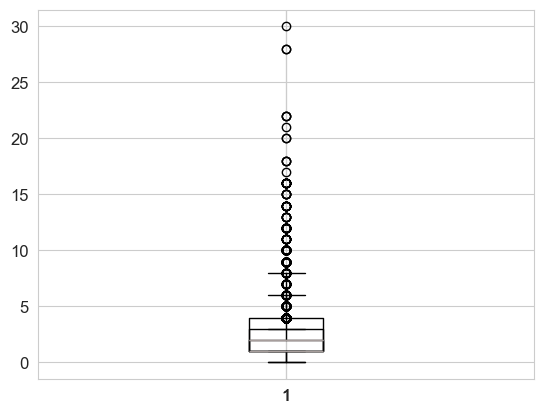

In [43]:
for col in property_features:
    print(df[col].value_counts().sort_index())
    print('\n25th-percentile - 1.5*IQR / 75th-percentile + 1.5*IQR:')
    box = plt.boxplot(df[col].dropna())
    print([item.get_ydata()[1] for item in box['whiskers']])
    print()

## Data Transformation

Let's transform data into the long format and add occupncy in % to easily compare between different time periods.

In [44]:
# transform dataframe into the long format 
df_long = df.copy().rename(columns={
    "availability_30": 30, "availability_60": 60, 
    "availability_90": 90, "availability_365": 365
})
df_long = df_long.melt(id_vars=['city', 'bathrooms', 'bedrooms', 'beds'], 
                       value_vars=periods, 
                       var_name='period', 
                       value_name='availability')

# change period data type to integer
df_long['period'] = df_long['period'].astype(int)

In [45]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38588 entries, 0 to 38587
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          38588 non-null  object 
 1   bathrooms     38284 non-null  float64
 2   bedrooms      38228 non-null  float64
 3   beds          37588 non-null  float64
 4   period        38588 non-null  int64  
 5   availability  38588 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 1.8+ MB


In [46]:
# add column with percentage of availability
df_long['occupancy_percentage'] = (df_long['period'] - df_long['availability']) / df_long['period'] * 100
df_long

city  bathrooms  bedrooms  beds  period  availability  \
0         Málaga       2.00      1.00  1.00      30             7   
1         Madrid       1.00      1.00  1.00      30             0   
2        Sevilla       1.00      2.00  2.00      30            26   
3      Barcelona       2.00      1.00  1.00      30             9   
4         Girona       1.00      2.00  5.00      30             0   
...          ...        ...       ...   ...     ...           ...   
38583     Girona       2.00      4.00  6.00     365            31   
38584     Girona       2.00      3.00  4.00     365           364   
38585     Girona       1.00      3.00  4.00     365            69   
38586     Madrid       1.00      1.00  2.00     365           351   
38587     Madrid       2.00      1.00  1.00     365           178   

       occupancy_percentage  
0                     76.67  
1                    100.00  
2                     13.33  
3                     70.00  
4                    100.00  
...                     ...  
38583                 91.51  
38584                  0.27  
38585                 81.10  
38586                  3.84  
38587                 51.23  

[38588 rows x 7 columns]

In [47]:
# add column with percentage of occupancy
for per in periods:
    df[f'occupancy_{per}'] = (per - df[f'availability_{per}']) / per * 100

In [48]:
print('Average availability per period, days:')
print(df_long.groupby('period').availability.mean())
print()
print('Average occupancy per period, %:')
print(df_long.groupby('period').occupancy_percentage.mean())

Average availability per period, days:
period
30     13.05
60     28.79
90     46.13
365   187.60
Name: availability, dtype: float64

Average occupancy per period, %:
period
30    56.51
60    52.01
90    48.74
365   48.60
Name: occupancy_percentage, dtype: float64


Many objects show availability clustered around 0 days or near the upper limit of each period (30, 60, 90, 365 days). This suggests that properties are either almost fully booked or have very low booking activity. Let's add a categorical column for these two cases vith values: 
- 1 if an object has no available days (`availability` == 0)
- 0 if an object has 90% or more days without reservations (`availability_percentage` >= 0.9)
- NaN for all other cases

In [49]:
# add columns with occupancy type 
df_long['is_fully_booked'] = np.where(df_long['availability']==0, 1, 0)
df_long['is_empty'] = np.where(df_long['availability'] >= df_long['period']*0.9, 1, 0)

In [50]:
# add column with 'number of bathrooms' category 
df_long['bathrooms_cat'] = np.where(df_long['bathrooms'].isna(), 'no info',
                                    np.where(df_long['bathrooms'] >= 4, '4+',
                                             df_long['bathrooms'].astype(str)
                                            )
                                   )

# add column with 'number of bedrooms' category 
df_long['bedrooms_cat'] = np.where(df_long['bedrooms'].isna(), 'no info',
                                   np.where(df_long['bedrooms'] >= 5, '5+',
                                            df_long['bedrooms'].astype(str)
                                            )
                                   )

# add column with 'number of beds' category 
df_long['beds_cat'] = np.where(df_long['beds'].isna(), 'no info',
                                    np.where(df_long['beds'] >= 9, '9+',
                                             df_long['beds'].astype(str)
                                            )
                                   )

## Buisness Question
How does the number of bedrooms, bathrooms, and beds affect the average availability of accommodations?  
Does it differ between cities?

### Relationships

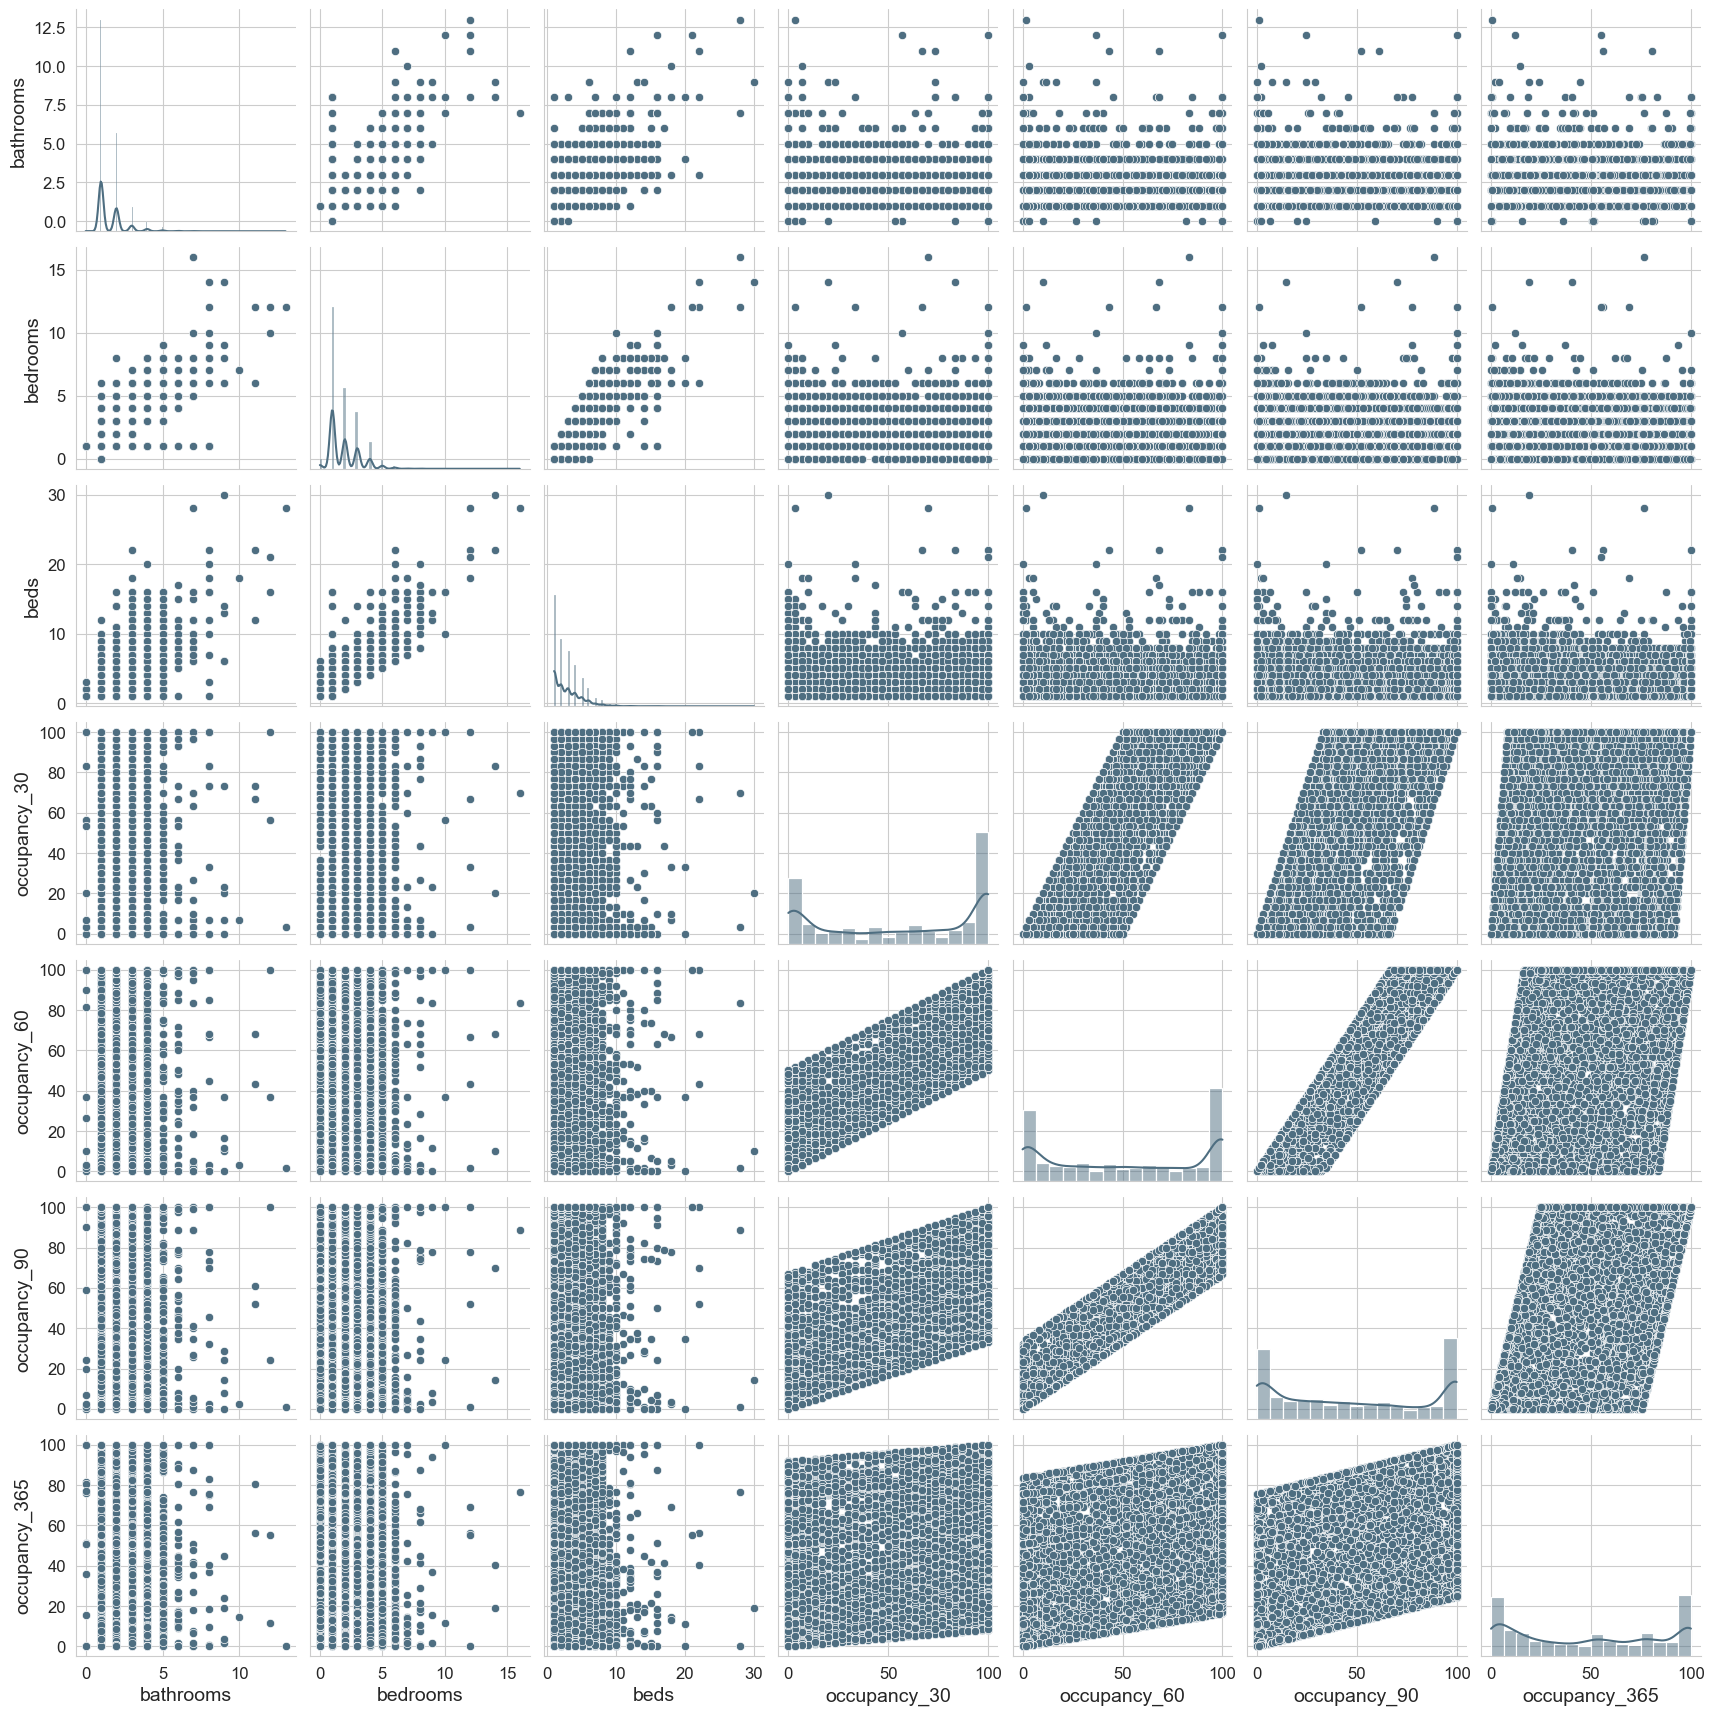

In [51]:
sns.pairplot(df.drop(['apartment_id', 'availability_30', 'availability_60',
                      'availability_90', 'availability_365'], axis=1), 
             diag_kind='hist', diag_kws={'kde': True})
plt.show()

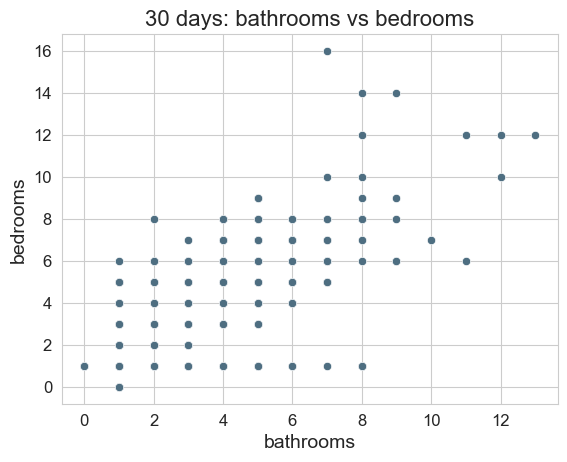

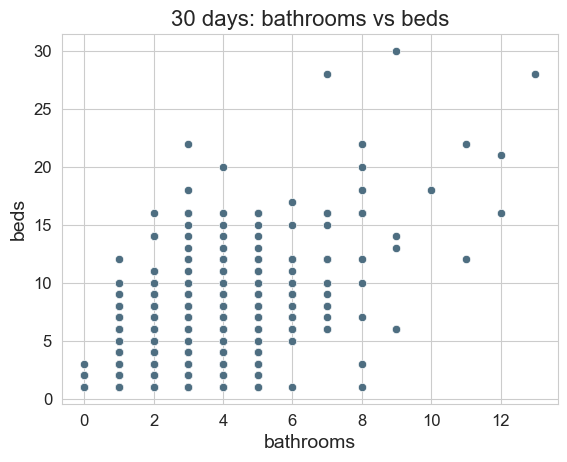

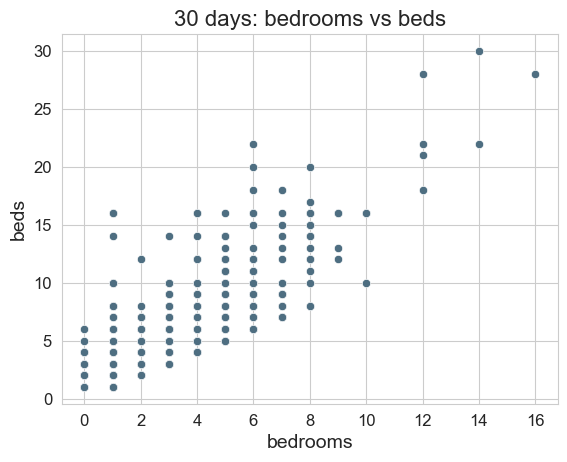

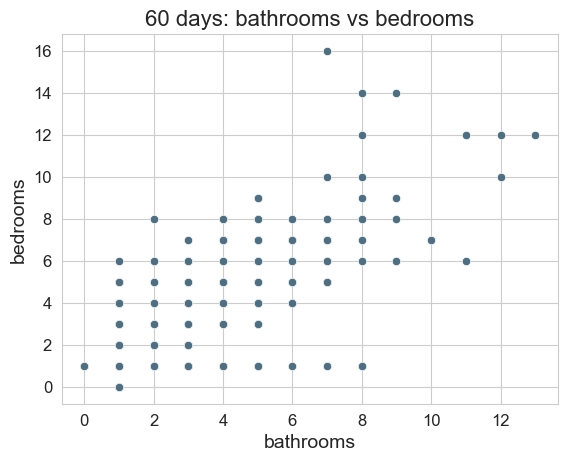

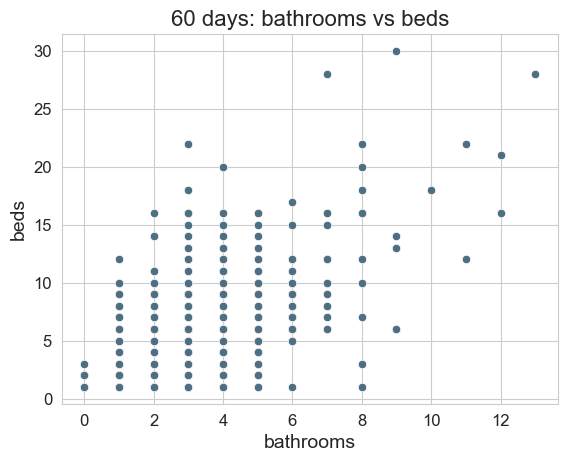

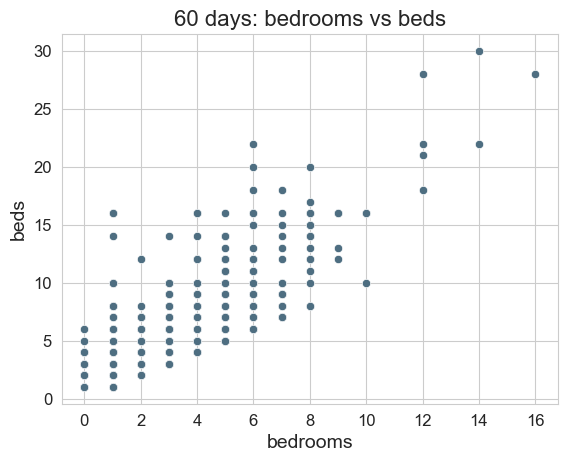

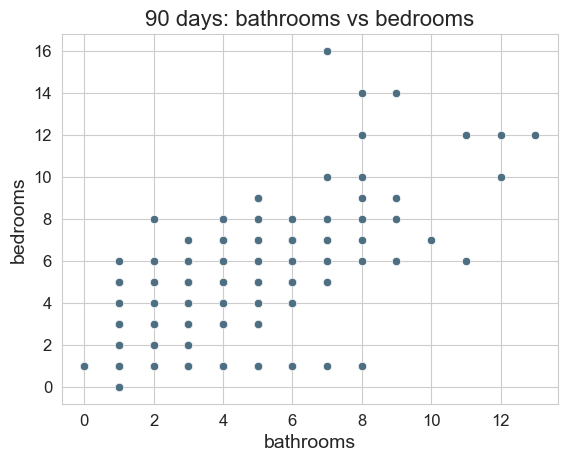

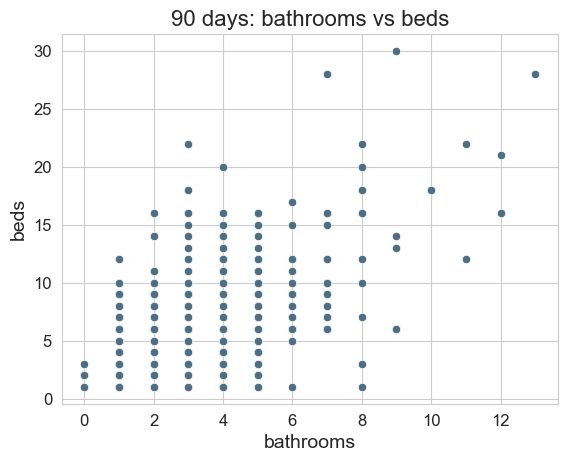

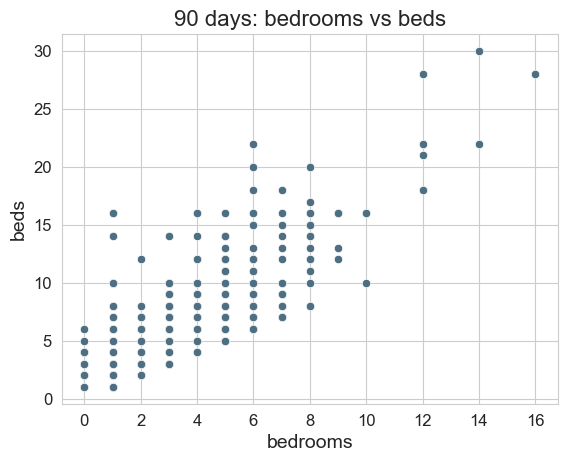

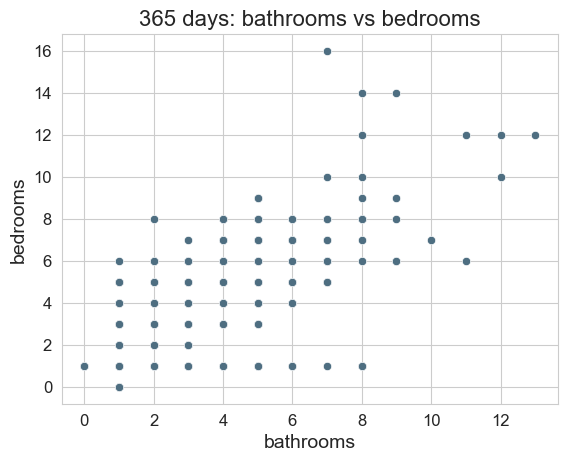

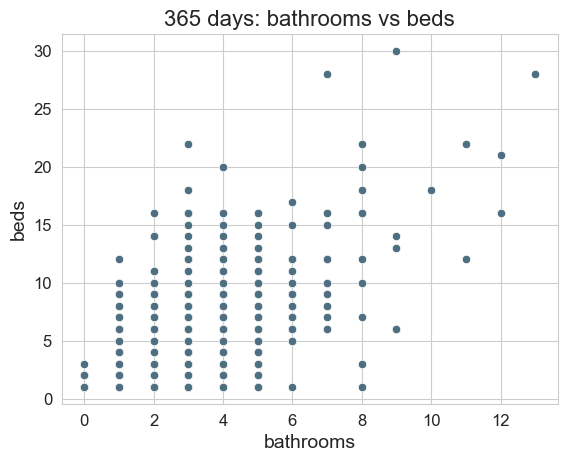

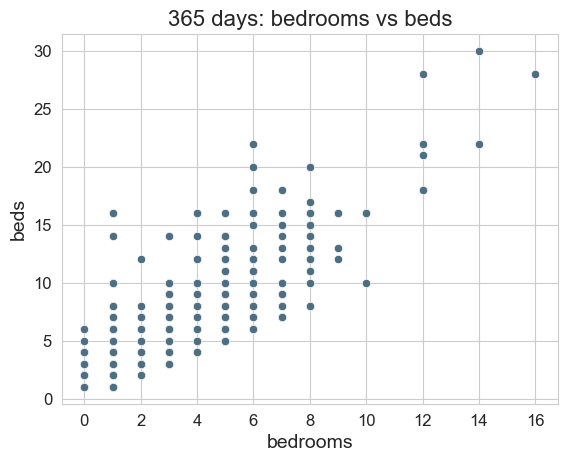

In [52]:
for per in periods:
    for i in range(len(property_features)):
        for j in range(i + 1, len(property_features)):
            x_col = property_features[i]
            y_col = property_features[j]
            
            sns.scatterplot(
                data=df_long.query('period==@per'),
                x=x_col,
                y=y_col,
            )
            plt.title(f'{per} days: {x_col} vs {y_col}')
            plt.show()

In [53]:
for per in periods:
    print(f'\nTop-10 combinations with 0% Occupancy across {per} dats')
    print(df_long
          .query('period==@per and is_empty==1')
          .groupby(property_features)
          .size()
          .sort_values(ascending=False)
          .head(10))


Top-10 combinations with 0% Occupancy across 30 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    520
                     2.00    217
           2.00      3.00    145
2.00       1.00      1.00    112
           3.00      4.00     81
                     5.00     74
1.00       2.00      4.00     73
                     2.00     70
2.00       2.00      3.00     67
1.00       1.00      3.00     55
dtype: int64

Top-10 combinations with 0% Occupancy across 60 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    544
                     2.00    209
           2.00      3.00    137
2.00       1.00      1.00    105
1.00       2.00      2.00     77
2.00       3.00      4.00     67
           2.00      3.00     67
           3.00      5.00     66
1.00       2.00      4.00     63
           1.00      3.00     51
dtype: int64

Top-10 combinations with 0% Occupancy across 90 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    579
                     2.00    221
        

In [54]:
for per in periods:
    print(f'\nTop-10 combinations with 100% occupancy across {per} dats')
    print(df_long
          .query('period==@per and is_fully_booked==1')
          .groupby(property_features)
          .size()
          .sort_values(ascending=False)
          .head(10))


Top-10 combinations with 100% occupancy across 30 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    726
                     2.00    254
2.00       1.00      1.00    187
1.00       2.00      3.00    155
                     2.00    146
2.00       3.00      5.00    104
                     4.00     70
           2.00      3.00     70
1.00       2.00      4.00     66
           1.00      3.00     59
dtype: int64

Top-10 combinations with 100% occupancy across 60 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    613
                     2.00    199
2.00       1.00      1.00    160
1.00       2.00      2.00    125
                     3.00    111
2.00       3.00      5.00     82
                     4.00     52
1.00       1.00      3.00     51
2.00       2.00      3.00     50
1.00       2.00      4.00     46
dtype: int64

Top-10 combinations with 100% occupancy across 90 dats
bathrooms  bedrooms  beds
1.00       1.00      1.00    538
                     2.00    170
2.

In [55]:
# Phik correlation coefficients matrix
phik_overview = df[
['city', 'bathrooms', 'bedrooms', 'beds', 
 'occupancy_30', 'occupancy_60', 'occupancy_90', 'occupancy_365']
].phik_matrix()

interval columns not set, guessing: ['bathrooms', 'bedrooms', 'beds', 'occupancy_30', 'occupancy_60', 'occupancy_90', 'occupancy_365']


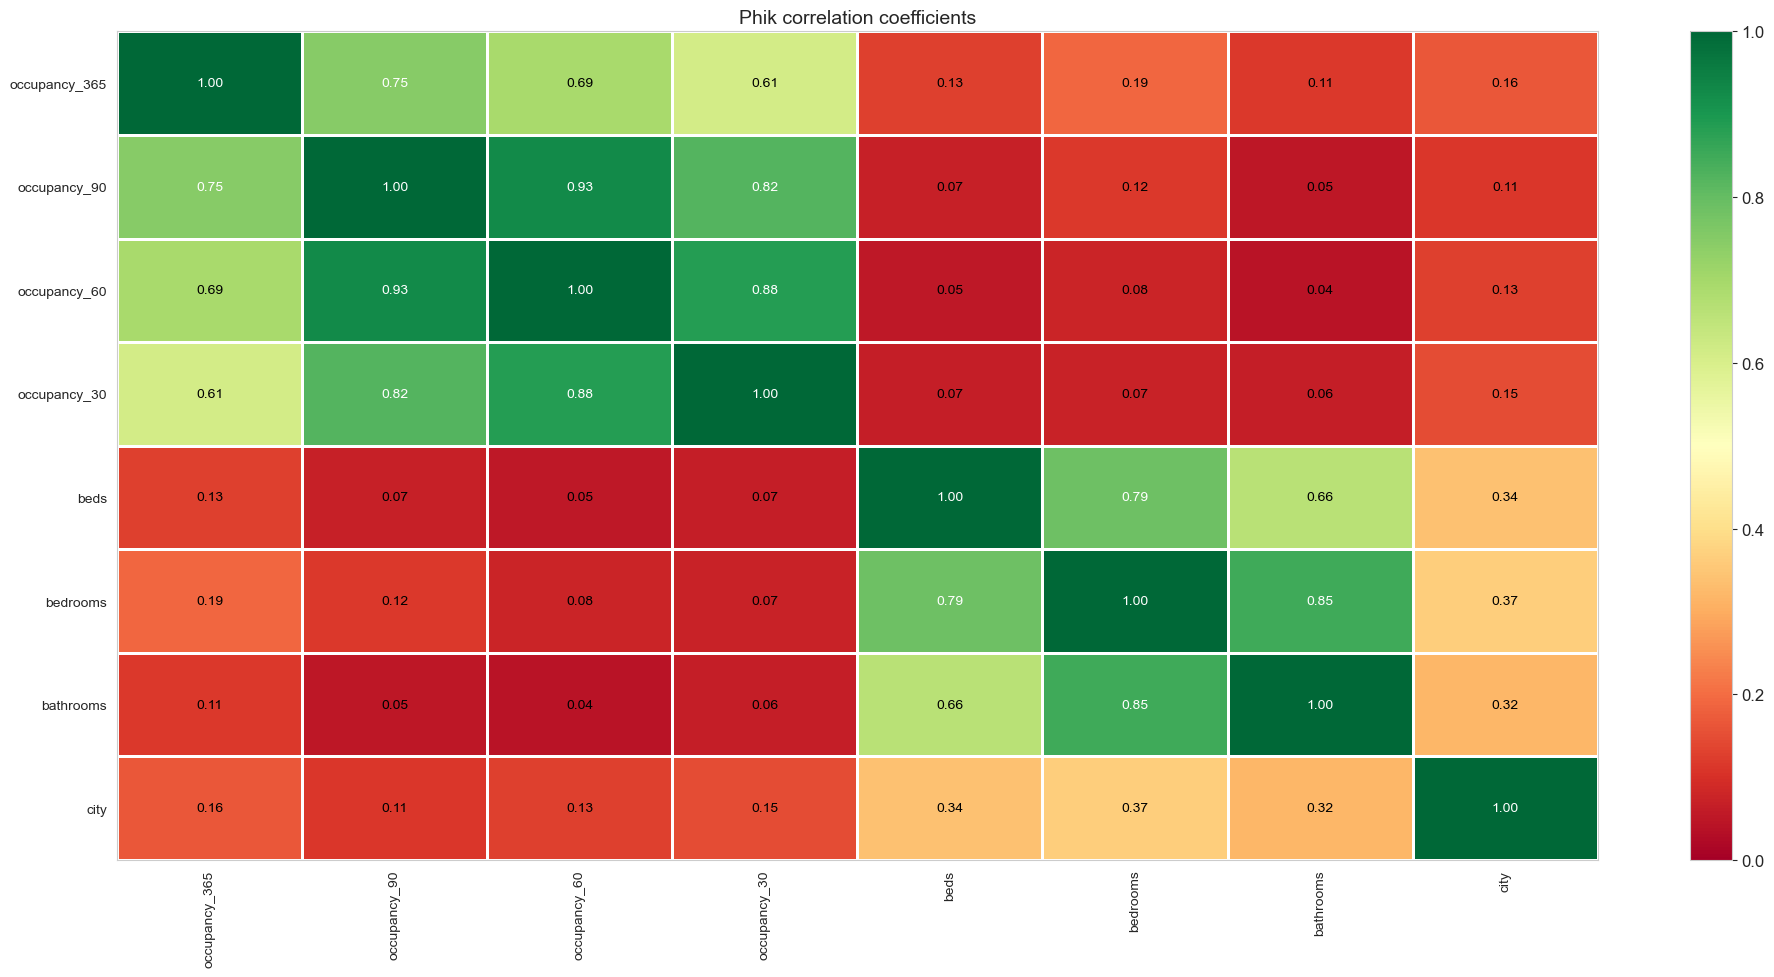

In [56]:
# plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values, 
                        x_labels=('city', 'bathrooms', 'bedrooms', 'beds', 'occupancy_30', 'occupancy_60', 'occupancy_90', 'occupancy_365'),
                        y_labels=('city', 'bathrooms', 'bedrooms', 'beds', 'occupancy_30', 'occupancy_60', 'occupancy_90', 'occupancy_365'), 
                        title="Phik correlation coefficients", 
                        figsize=(20, 10),
                        vmin=0, vmax=1)

### Number of bathrooms
Does number of bathrooms affect occupancy in general?

In [57]:
bathrooms = df_long.drop(['bedrooms', 'beds'], axis=1).dropna()
bathrooms.isna().sum()

city                    0
bathrooms               0
period                  0
availability            0
occupancy_percentage    0
is_fully_booked         0
is_empty                0
bathrooms_cat           0
bedrooms_cat            0
beds_cat                0
dtype: int64

In [58]:
# distribution of number of bathrooms 
bathrooms.query('period==30')['bathrooms'].value_counts().sort_index()

bathrooms
0.00       15
1.00     5774
2.00     2682
3.00      650
4.00      262
5.00      103
6.00       43
7.00       18
8.00       13
9.00        5
10.00       1
11.00       2
12.00       2
13.00       1
Name: count, dtype: int64

In [59]:
# add column with 'number of bathrooms' category 
bathrooms['bathrooms_cat'] = np.where(
    bathrooms['bathrooms'] < 4, 
    bathrooms['bathrooms'].astype(int),
    '4+')

bathrooms.query('period==30')['bathrooms_cat'].value_counts().sort_index()

bathrooms_cat
0       15
1     5774
2     2682
3      650
4+     450
Name: count, dtype: int64

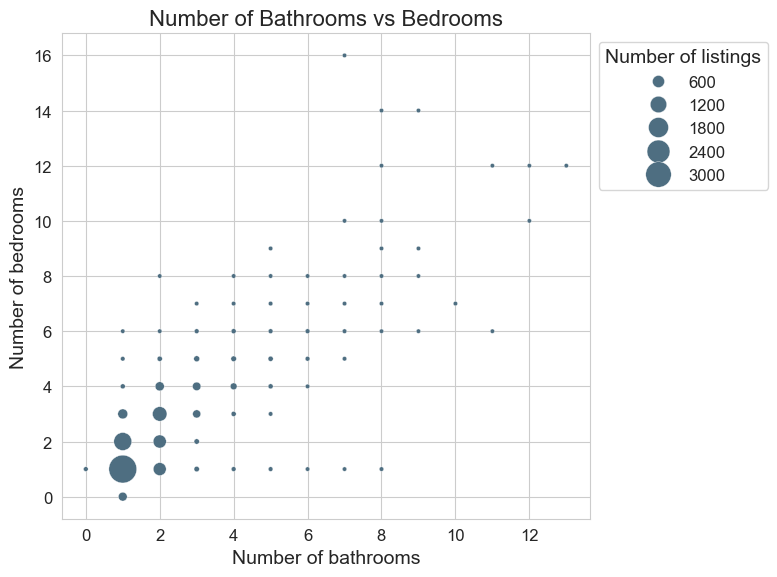

In [60]:
scatter_data = df_long.query('period==30').groupby(['bathrooms', 'bedrooms']).size().reset_index(name='num_listings')

# scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=scatter_data,
                    x='bathrooms', y='bedrooms', 
                    size='num_listings', 
                    sizes=(10, 400))
    
plt.title(f'Number of Bathrooms vs Bedrooms')
plt.xlabel('Number of bathrooms')
plt.ylabel('Number of bedrooms')
plt.legend(title='Number of listings', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [61]:
with pd.option_context('display.max_colwidth', None):
    display(data[(data['bathrooms']>2) & (df['bedrooms']==1)][
            ['description', 'room_type', 'accommodates', 'bathrooms', 
             'bedrooms', 'beds']])

description  \
27    Es un piso totalmente reformado. Todas las habitaciones tienen llave y est�n amuebladas. Se puede ir andando a todos los lugares importantes de Madrid. Las personas que se queden por meses tienen derecho a cocina, wii, calefacci�n, lavadora, etc. En el piso tenemos 5 ba�os y 2 duchas. Todas las habitaciones est�n amuebladas, algunas tienen medio ba�o dentro, tienen llave en la puerta. . Las personas que alquilen por meses tienen derecho a cocina, lavadora, wifi, etc. Las personas que alquilen por d�as sueltos, tienen derecho a wifi, microondas, frigorifico, utilizar platos, vasos, cubiertos, ( no los hornillos de la cocina ). La lavadora es un servicio aparte. Lo que sea necesario Esta rodeado de cines, teatros, centros comerciales, restaurantes, museos, etc. Se puede ir andando a todos los sitios importantes. El autob�s que sale del aeropuerto, la parada la tiene en Cibeles y se tarde 10 minutos andando al piso. Esta comunicado con todo tipo de transportes a metro, autobuses, tren etc   
249    IF YOU WANT TO GET TO KNOW MADRID AND FEEL AT HOME, THIS IS YOUR PLACE! Spacious, fully renovated, and modern flat with a touch of elegance, warmth, with an international atmosphere in Madrid�s best neighborhood. With a personable and casual atmosphere, this is ideal for friendly, sociable, and respectful people.  Located in the heart of Madrid, between Puerta del Sol and the famous Gran Via. Within walking distance of the renowned Plaza Mayor, Mercado de San Miguel, La Latina, the Rastro (a market), Chueca, Fuencarral, the Royal Palace, Retiro Park, and Puerta de Alcala. In the center of the city�s entertainment district with nearby cinemas, restaurants, nightlife and shopping. Also very close to acclaimed museums Prado, Reina Sofia and Thyssen Bornemisza.  Very accessible to the rest of the city with the Madrid Metro (lines 1, 2, 3, and 5 from stations Sol, Gran Via & Sevilla), bus ( ) , or commuter train (Renfe). Despite being in the most active and bustling district in Madrid, Fun   
667    After the restoration of a1919 building in the city centre you will be able to find the perfect balance between quality, price and service. Room for 1 person, with 1 bed, with shared bathrooms. Located on the corner of El Silencio and Monsalves Street, all rooms are exterior and have a balcony. Bed sheets and towels are included. Free Wi-Fi. Luggage storage. The hostel is adapted for people with reduced mobility. Elevator. Laundry. Office with fridge, microwave and tableware. Toilets and showers on each floor. Roof terrace. We don`t have reception desk service. You can contact a member of the Hostel team by phone or press the main door bell (intercom) which calls our mobile phone. Urban Sevilla Hostel is located in the heart of Seville, at number 8 Silencio Street, 100 meters from the emblematic �La Campana� area and 600 meters from the Cathedral and the Giralda. Thanks to its privileged location, you will be able to visit the most important sites of the city on foot and you also have   
677   After the restoration of a 1919 building in the city centre you will be able to find the perfect balance between quality, price and service. Room for 3 people, with 3 beds, with shared bathrooms. Located on the corner of El Silencio and Monsalves Street, all rooms are exterior and have a balcony. Bed sheets and towels are included. Free Wi-Fi. Luggage storage. The hostel is adapted for people with reduced mobility. Elevator. Laundry. Office with fridge, microwave and tableware. Toilets and showers on each floor. Roof terrace. We don`t have reception desk service. You can contact a member of the Hostel team by phone or press the main door bell (intercom) which calls our mobile phone. Urban Sevilla Hostel is located in the heart of Seville, at number 8 Silencio Street, 100 meters from the emblematic �La Campana� area and 600 meters from the Cathedral and the Giralda.  Thanks to its privileged location, you will be able to visit the most 

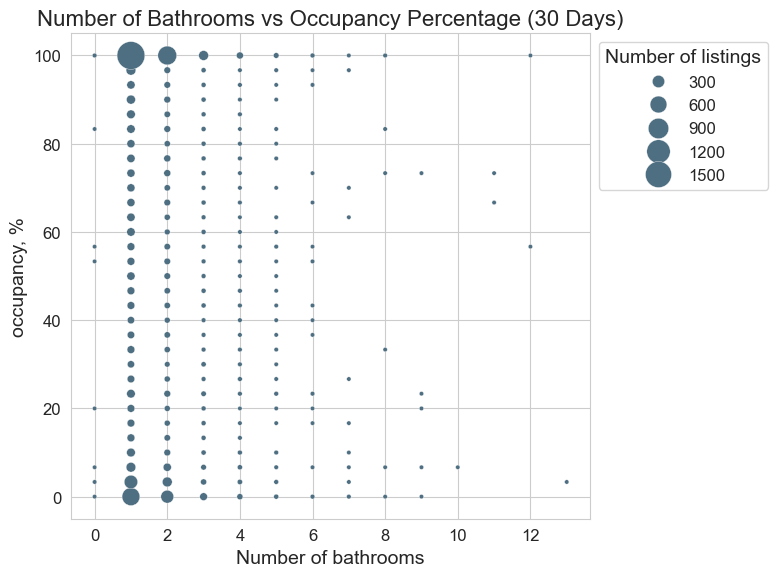

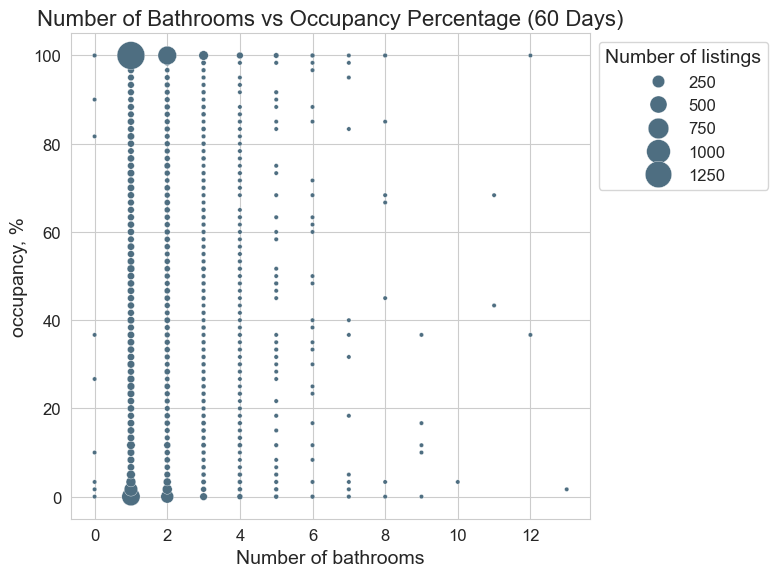

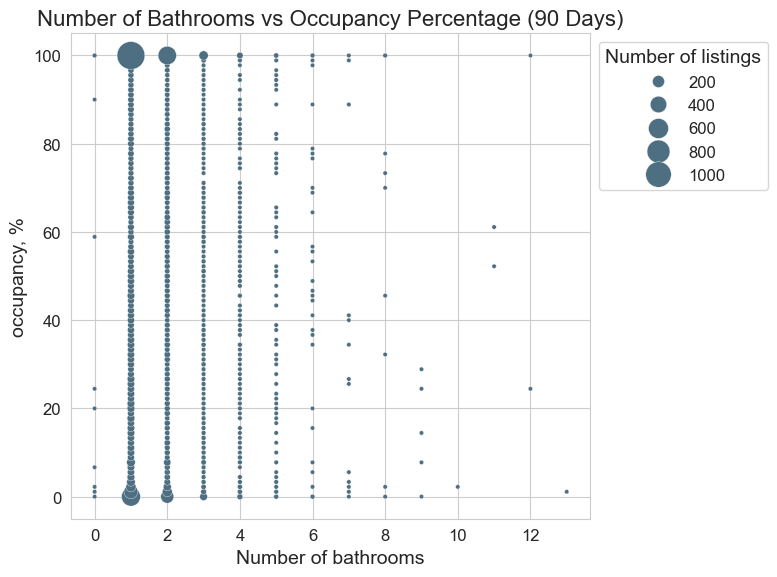

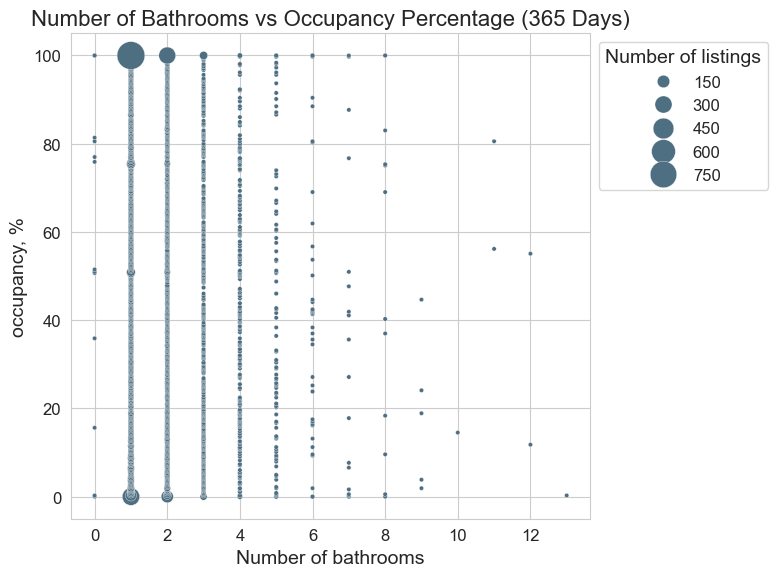

In [62]:
for per in periods:
    # count the number of listings
    scatter_data = bathrooms.query('period==@per').groupby(['bathrooms', 'occupancy_percentage']).size().reset_index(name='num_listings')
    
    # scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=scatter_data,
                    x='bathrooms', y='occupancy_percentage', 
                    size='num_listings', 
                    sizes=(10, 400))
    
    plt.title(f'Number of Bathrooms vs Occupancy Percentage ({per} Days)')
    plt.xlabel('Number of bathrooms')
    plt.ylabel('occupancy, %')
    plt.legend(title='Number of listings', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

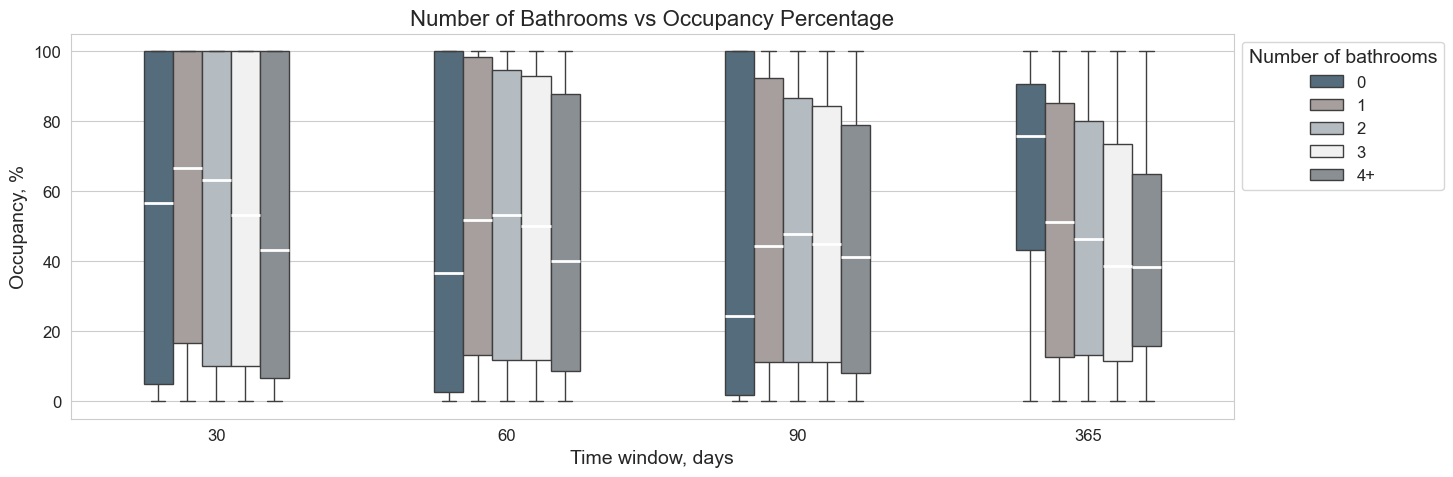

In [63]:
# boxplots
plt.figure(figsize=(15,5))
sns.boxplot(data=bathrooms,
            x='period', y='occupancy_percentage',
            hue='bathrooms_cat', 
            hue_order=['0', '1', '2', '3', '4+'],
            width=0.5, 
            medianprops={"color": "w", "linewidth": 2}
           )

plt.title(f'Number of Bathrooms vs Occupancy Percentage')
plt.legend(title='Number of bathrooms', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Time window, days')
plt.ylabel('Occupancy, %')
plt.show()

**Statistical Significance**

*Hypothesis Testing*    
We want to test whether occupancy distributions differ between properties with different numbers of `bathrooms`.
- H₀ (Null Hypothesis): The distributions of occupancy (across different time windows) are the same across all `bathroom` count groups.
- H₁ (Alternative Hypothesis): At least one group comes from a different distribution.

The group sizes are highly unbalanced, which may affect sensitivity. Nonetheless, we'll begin with the Kruskal–Wallis test, a non-parametric test suitable for comparing more than two independent groups when normality assumptions are not met.

In [64]:
# Kruskal-Wallis test
def kw_test(df, col):
    for per in periods:
        # get groups
        df_per = df[df['period'] == per]
        groups = [df_per.query(f'{col}_cat==@cat')['occupancy_percentage'] for cat in df_per[f'{col}_cat'].unique()]
    
        stat, p_value = kruskal(*groups)
    
        print('\n******\n')
        print(f'Occupancy across {per} days')
        print(f'Kruskal-Wallis Statistic: {stat:.3f}, p-value = {p_value}')
        if p_value < ALPHA:
            print("Reject null hypothesis")
            # Tukey's test for pairwise comparisons
            df_sorted = df_per.sort_values(by=f'{col}_cat')
            tukey_results = sp.posthoc_tukey(df_sorted, 
                                             val_col='occupancy_percentage', 
                                             group_col=f'{col}_cat')
            print("Tukey's test for pairwise comparisons")
            display(tukey_results.style.background_gradient(cmap='Blues_r', vmin=0, vmax=0.06))
            print()
        else:
            print("Fail to reject null hypothesis\n")

In [65]:
kw_test(bathrooms, 'bathrooms')


******

Occupancy across 30 days
Kruskal-Wallis Statistic: 21.721, p-value = 0.00022771201528720442
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 60 days
Kruskal-Wallis Statistic: 10.599, p-value = 0.03145672284665021
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 90 days
Kruskal-Wallis Statistic: 4.660, p-value = 0.3239655781047066
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 42.790, p-value = 1.1440429188484746e-08
Reject null hypothesis
Tukey's test for pairwise comparisons


**Permutation test**  
Let's use a permutation test to compare two or more groups by comparing the observed test statistic to a distribution of test statistics generated by randomly rearranging the data. It does not rely on any assumptions about the distribution of the data, which makes it particularly useful for small sample sizes or when data doesn't meet parametric assumptions or when groups have very different sizes.

In [66]:
def get_observed_medians(df, col):
    
    # pairwise differences in medians for all group combinations
    observed_medians = df.groupby(f'{col}_cat')['occupancy_percentage'].median()
    groups = observed_medians.index.tolist()
    observed_diff_median = {}
    for i, g1 in enumerate(groups):
        for g2 in groups[i+1:]:
            observed_diff_median[(g1, g2)] = np.abs(observed_medians[g1] - observed_medians[g2])
    return groups, observed_medians, observed_diff_median

In [67]:
def permutation_p_values(df, col, per, n_permutations=1000):
    
    df_per = df[df['period'] == per].copy()
    groups, observed_medians, observed_diff_median = get_observed_medians(df_per, col)

    labels = df_per[f'{col}_cat'].values

    pairwise_p_values = {pair: 0 for pair in observed_diff_median.keys()}
    for _ in range(n_permutations):
        shuffled_labels = np.random.permutation(labels)

        # create new group mappings for shuffled labels
        shuffled_groups = {g: df_per['occupancy_percentage'][shuffled_labels == g] for g in groups}

        for (g1, g2) in observed_diff_median:
            # medians for shuffled data
            med1 = np.median(shuffled_groups[g1]) 
            med2 = np.median(shuffled_groups[g2])

            perm_diff = np.abs(med1 - med2)

            # how many times permuted diff >= observed
            if perm_diff >= observed_diff_median[(g1, g2)]:
                pairwise_p_values[(g1, g2)] += 1

    # convert counts to p-values
    for pair in pairwise_p_values:
        pairwise_p_values[pair] /= n_permutations

    return pairwise_p_values

In [68]:
def permutation_test_result(df, col):
    
    records = []
    for per in periods:
        # permutation test
        pairwise_p_values = permutation_p_values(df, col, per)

        # multiple testing correction
        p_vals = list(pairwise_p_values.values())
        adj_p_vals = multipletests(p_vals, method='fdr_bh')[1]
        adj_p_vals = dict(zip(pairwise_p_values.keys(), adj_p_vals))

        # list of records
        for (g1, g2), adj_p in adj_p_vals.items():
            records.append({
                'Period': per,
                'Comparison': f"{g1} vs {g2}",
                'p-value': adj_p
            })

    # Create a dataframe
    df_result = pd.DataFrame(records)
    return df_result

In [69]:
res = permutation_test_result(bathrooms, 'bathrooms')

In [70]:
# display results
(res.pivot(index='Comparison', columns='Period', values='p-value')
    .style.background_gradient(cmap='Blues_r', vmin=0, vmax=0.06)
)

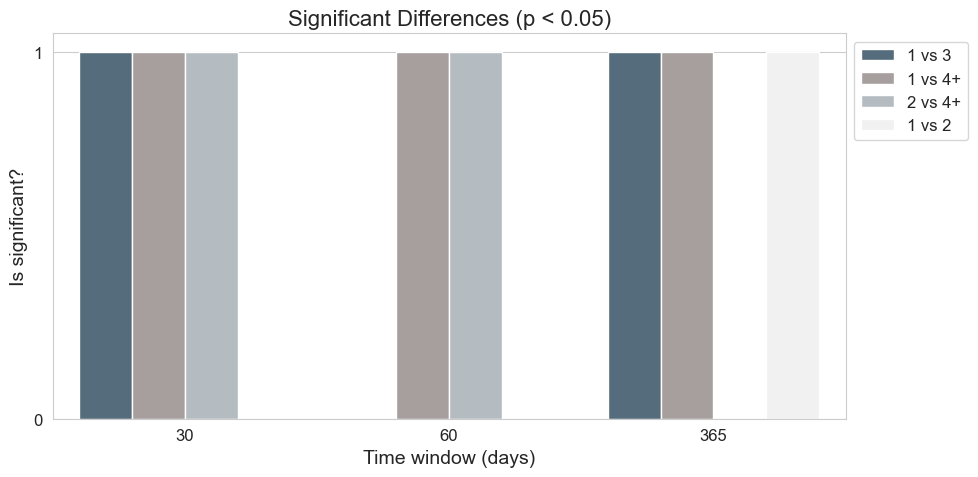

In [71]:
# visualization of significant comparisons
df_significant = res[res['p-value'] < ALPHA]

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_significant,
    x='Period',
    hue='Comparison',
    dodge=True
)

plt.title('Significant Differences (p < 0.05)')
plt.xlabel('Time window (days)')
plt.ylabel('Is significant?')
plt.yticks([0, 1])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion**: 

### Number of bedrooms
Does number of bedrooms affect availability in general?

In [72]:
bedrooms = df_long.drop(['bathrooms', 'beds'], axis=1).dropna()
bedrooms.isna().sum()

city                    0
bedrooms                0
period                  0
availability            0
occupancy_percentage    0
is_fully_booked         0
is_empty                0
bathrooms_cat           0
bedrooms_cat            0
beds_cat                0
dtype: int64

In [73]:
# distribution of number of bedrooms 
bedrooms.query('period==30')['bedrooms'].value_counts().sort_index()

bedrooms
0.00      278
1.00     4422
2.00     2209
3.00     1548
4.00      737
5.00      227
6.00       89
7.00       17
8.00       16
9.00        4
10.00       3
12.00       4
14.00       2
16.00       1
Name: count, dtype: int64

In [74]:
# bedrooms groups 
bedrooms['bedrooms_cat'] = np.where(bedrooms['bedrooms'] < 5, bedrooms['bedrooms'].astype(int), '5+')
bedrooms.query('period==30')['bedrooms_cat'].value_counts().sort_index()

bedrooms_cat
0      278
1     4422
2     2209
3     1548
4      737
5+     363
Name: count, dtype: int64

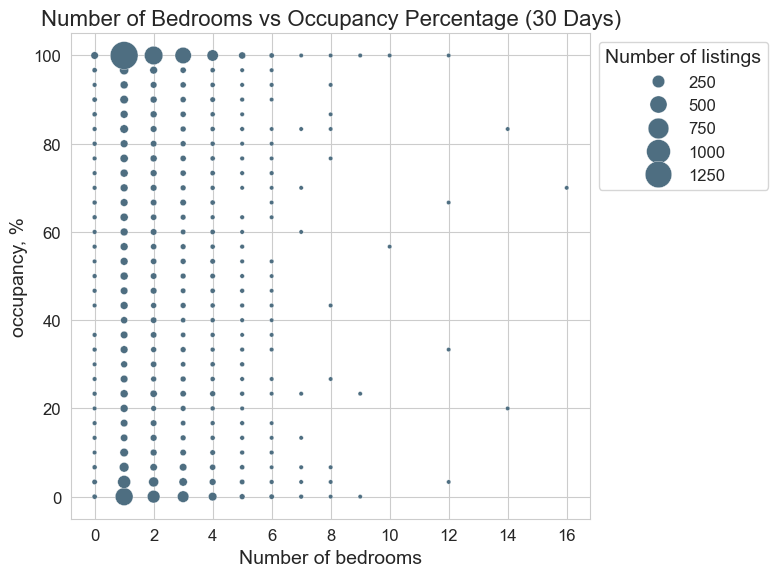

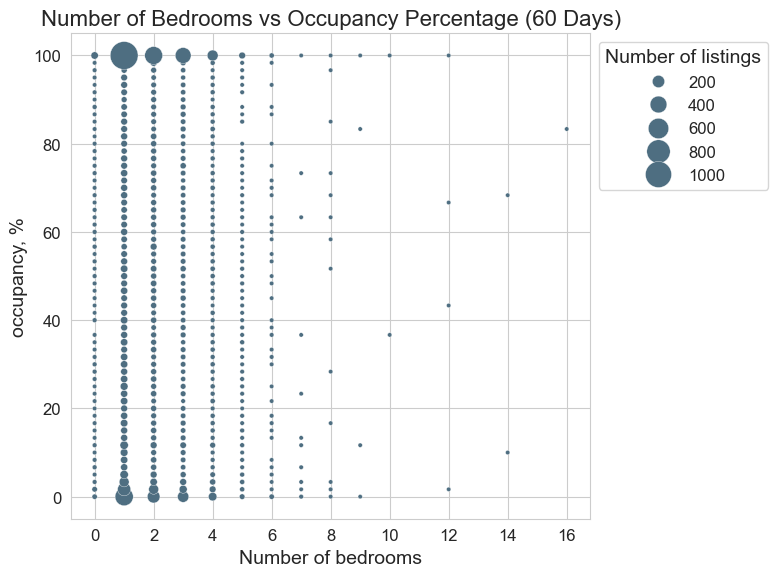

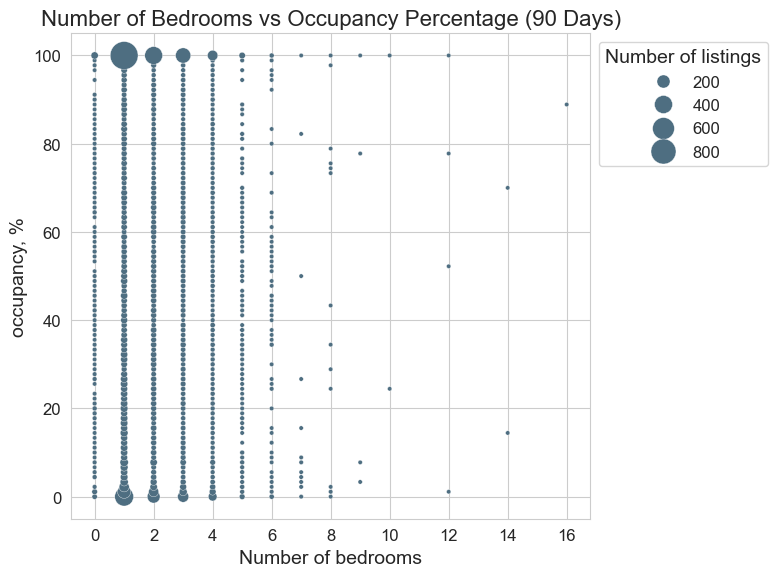

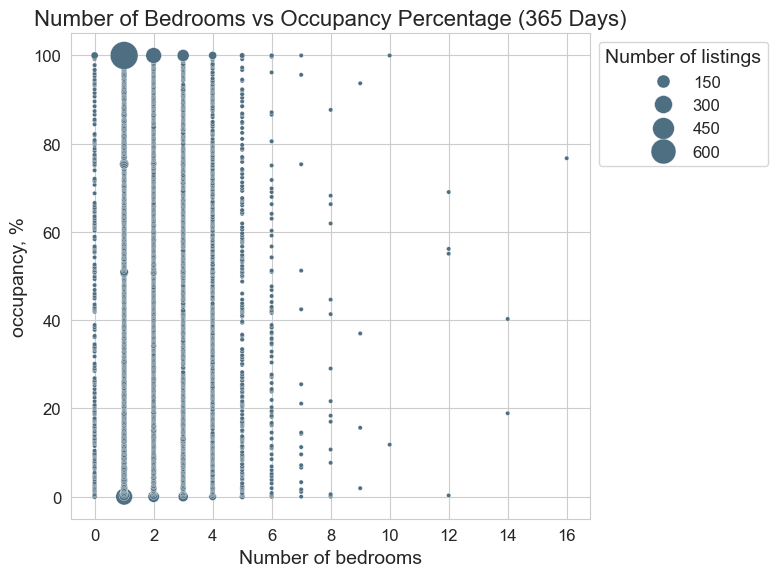

In [75]:
for per in periods:
    # count the number of listings
    scatter_data = bedrooms.query('period==@per').groupby(['bedrooms', 'occupancy_percentage']).size().reset_index(name='num_listings')
    
    # scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=scatter_data,
                    x='bedrooms', y='occupancy_percentage', 
                    size='num_listings', 
                    sizes=(10, 400))
    
    plt.title(f'Number of Bedrooms vs Occupancy Percentage ({per} Days)')
    plt.xlabel('Number of bedrooms')
    plt.ylabel('occupancy, %')
    plt.legend(title='Number of listings', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

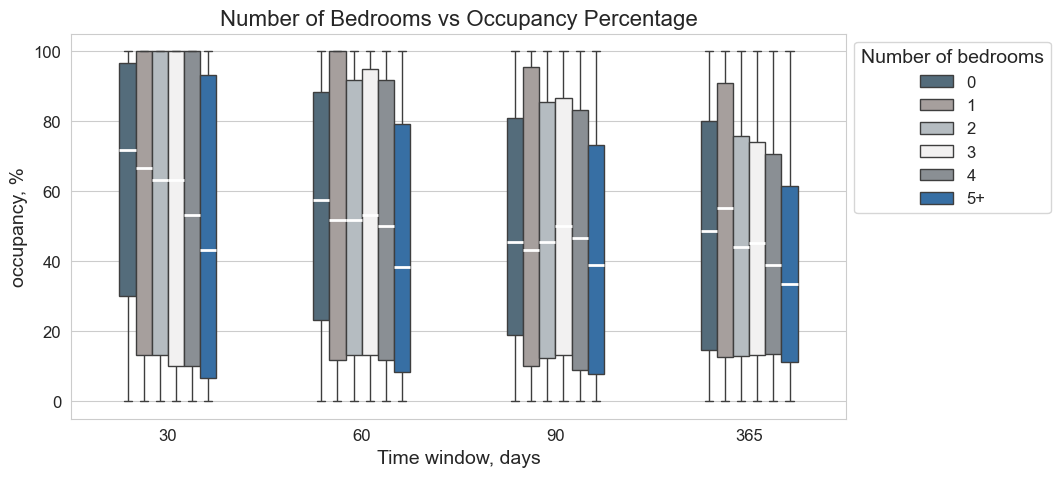

In [76]:
# boxplots
plt.figure(figsize=(10,5))
sns.boxplot(data=bedrooms,
            x='period', y='occupancy_percentage',
            hue='bedrooms_cat', 
            hue_order=['0', '1', '2', '3', '4', '5+'],
            width=0.5, 
            medianprops={"color": "w", "linewidth": 2}
           )

plt.title(f'Number of Bedrooms vs Occupancy Percentage')
plt.legend(title='Number of bedrooms', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Time window, days')
plt.ylabel('occupancy, %')
plt.show()

**Statistical Significance**

*Hypothesis Testing*    
We want to test whether occupancy distributions differ between properties with different numbers of `bedrooms`.
- H₀ (Null Hypothesis): The distributions of occupancy (across different time windows) are the same across all `bedrooms` count groups.
- H₁ (Alternative Hypothesis): At least one group comes from a different distribution.

The group sizes are unbalanced, which may affect sensitivity.

In [77]:
# Kruskal-Wallis test
kw_test(bedrooms, 'bedrooms')


******

Occupancy across 30 days
Kruskal-Wallis Statistic: 28.813, p-value = 2.5227188662743865e-05
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 60 days
Kruskal-Wallis Statistic: 16.904, p-value = 0.004685537201522765
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 90 days
Kruskal-Wallis Statistic: 9.070, p-value = 0.10631442528553699
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 107.656, p-value = 1.2818045181306402e-21
Reject null hypothesis
Tukey's test for pairwise comparisons


**Permutation test**  

In [78]:
res = permutation_test_result(bedrooms, 'bedrooms')

In [79]:
# display results
(res.pivot(index='Comparison', columns='Period', values='p-value')
    .style.background_gradient(cmap='Blues_r', vmin=0, vmax=0.06)
)

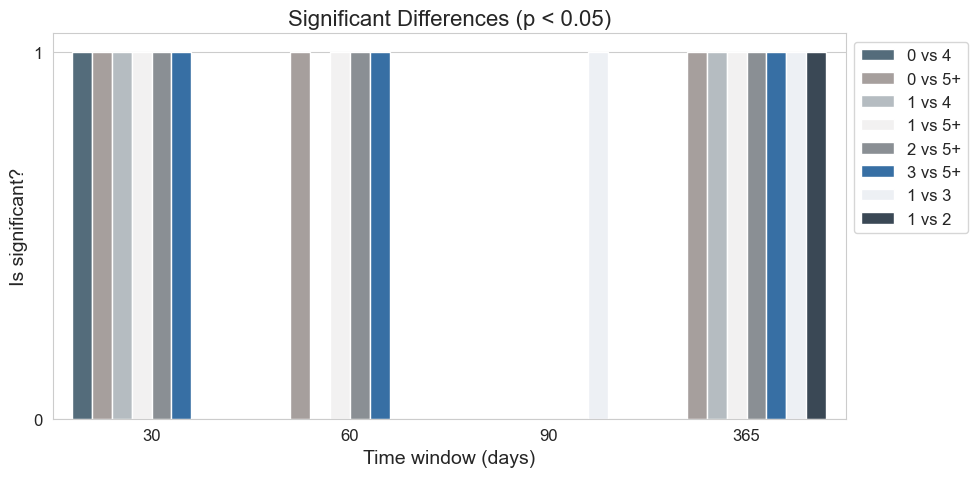

In [80]:
# visualization of significant comparisons
df_significant = res[res['p-value'] < ALPHA]

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_significant,
    x='Period',
    hue='Comparison',
    dodge=True
)

plt.title('Significant Differences (p < 0.05)')
plt.xlabel('Time window (days)')
plt.ylabel('Is significant?')
plt.yticks([0, 1])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion**: 

### Number of beds
Does number of beds affect availability in general?

In [81]:
beds = df_long.drop(['bathrooms', 'bedrooms'], axis=1).dropna()
beds.isna().sum()

city                    0
beds                    0
period                  0
availability            0
occupancy_percentage    0
is_fully_booked         0
is_empty                0
bathrooms_cat           0
bedrooms_cat            0
beds_cat                0
dtype: int64

In [82]:
# distribution of number of beds 
beds.query('period==30')['beds'].value_counts().sort_index()

beds
1.00     3045
2.00     1827
3.00     1525
4.00     1136
5.00      768
6.00      495
7.00      225
8.00      162
9.00       70
10.00      63
11.00       9
12.00      26
13.00       5
14.00       9
15.00       5
16.00      14
17.00       1
18.00       3
20.00       2
21.00       1
22.00       3
28.00       2
30.00       1
Name: count, dtype: int64

In [83]:
# beds groups 
beds['beds_cat'] = np.where(beds['beds'] < 9, beds['beds'].astype(int), '9+')
beds.query('period==30')['beds_cat'].value_counts().sort_index()

beds_cat
1     3045
2     1827
3     1525
4     1136
5      768
6      495
7      225
8      162
9+     214
Name: count, dtype: int64

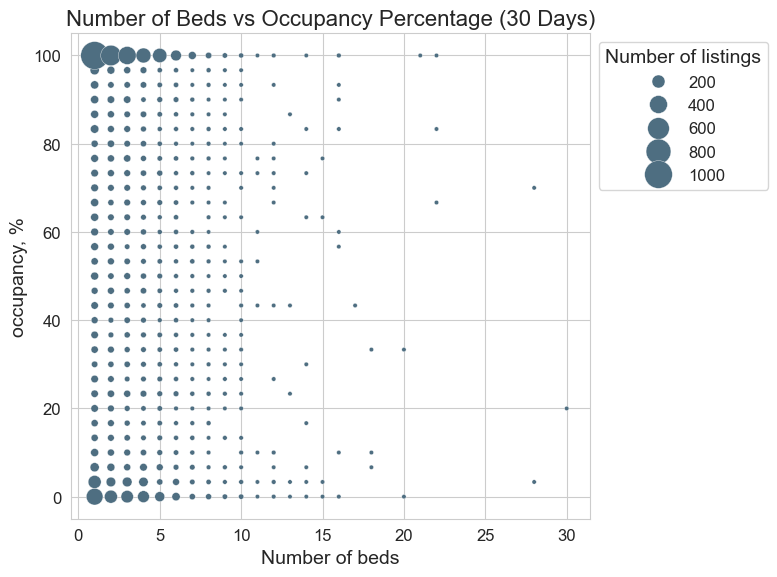

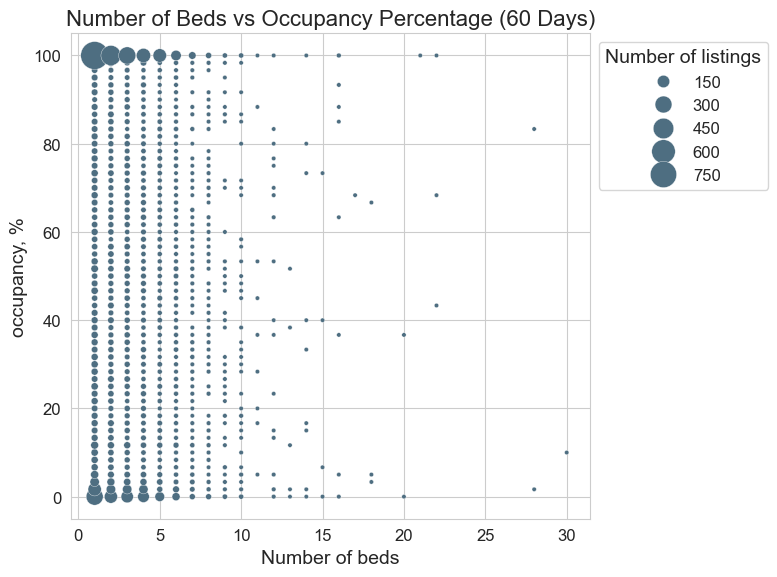

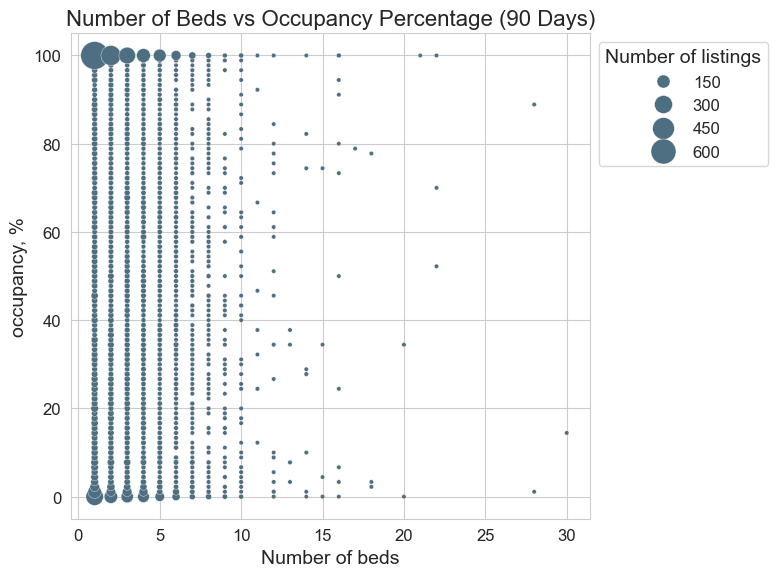

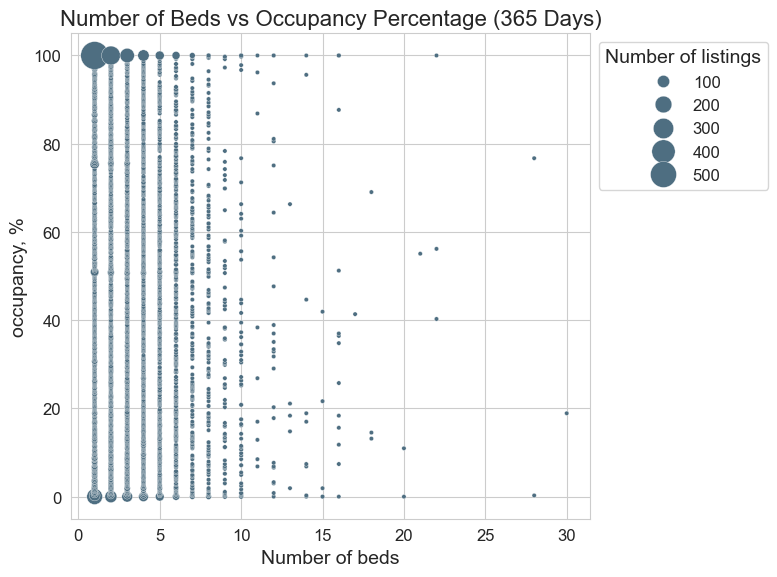

In [84]:
for per in periods:
    # count the number of listings
    scatter_data = beds.query('period==@per').groupby(['beds', 'occupancy_percentage']).size().reset_index(name='num_listings')
    
    # scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=scatter_data,
                    x='beds', y='occupancy_percentage', 
                    size='num_listings', 
                    sizes=(10, 400))
    
    plt.title(f'Number of Beds vs Occupancy Percentage ({per} Days)')
    plt.xlabel('Number of beds')
    plt.ylabel('occupancy, %')
    plt.legend(title='Number of listings', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

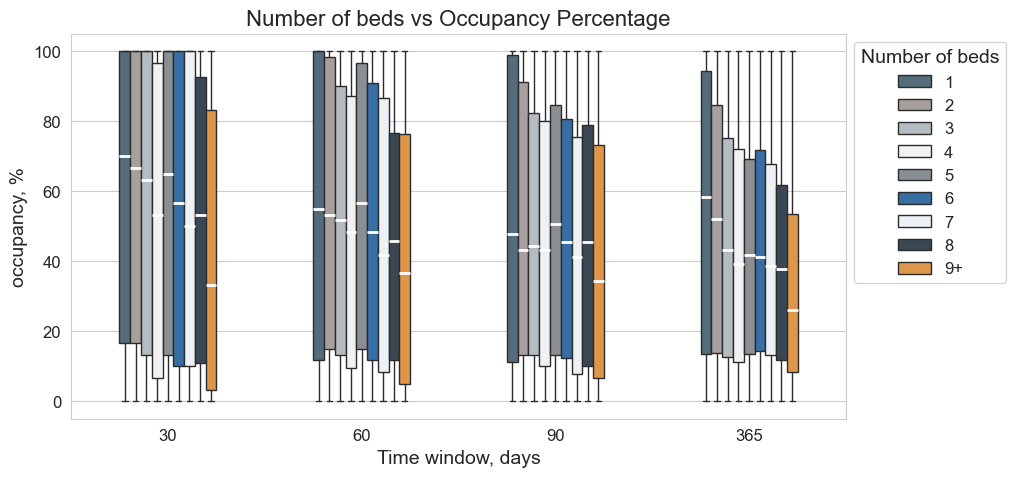

In [85]:
# boxplots
plt.figure(figsize=(10,5))
sns.boxplot(data=beds,
            x='period', y='occupancy_percentage',
            hue='beds_cat', 
            hue_order=['1', '2', '3', '4', '5', '6', '7', '8', '9+'],
            width=0.5, 
            medianprops={"color": "w", "linewidth": 2}
           )

plt.title(f'Number of beds vs Occupancy Percentage')
plt.legend(title='Number of beds', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Time window, days')
plt.ylabel('occupancy, %')
plt.show()

**Statistical Significance**

*Hypothesis Testing*    
We want to test whether occupancy distributions differ between properties with different numbers of `beds`.
- H₀ (Null Hypothesis): The distributions of occupancy (across different time windows) are the same across all `beds` count groups.
- H₁ (Alternative Hypothesis): At least one group comes from a different distribution.

The group sizes are unbalanced, which may affect sensitivity.

In [86]:
# Kruskal-Wallis test
kw_test(beds, 'beds')


******

Occupancy across 30 days
Kruskal-Wallis Statistic: 74.773, p-value = 5.476343799850782e-13
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 60 days
Kruskal-Wallis Statistic: 49.805, p-value = 4.455175512927228e-08
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 90 days
Kruskal-Wallis Statistic: 29.354, p-value = 0.0002747400382682772
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 365 days
Kruskal-Wallis Statistic: 179.184, p-value = 1.5276225841391278e-34
Reject null hypothesis
Tukey's test for pairwise comparisons


**Permutation test**  

In [87]:
# Permutation test
res = permutation_test_result(beds, 'beds')

In [88]:
# display results
(res.pivot(index='Comparison', columns='Period', values='p-value')
    .style.background_gradient(cmap='Blues_r', vmin=0, vmax=0.06)
)

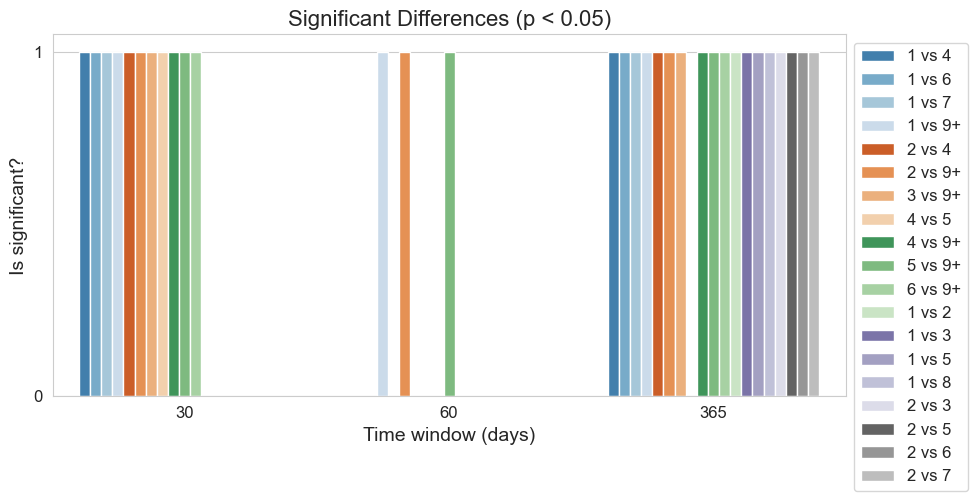

In [89]:
# visualization of significant comparisons
df_significant = res[res['p-value'] <= ALPHA]

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_significant,
    x='Period',
    hue='Comparison',
    palette='tab20c',
    dodge=True
)

plt.title('Significant Differences (p < 0.05)')
plt.xlabel('Time window (days)')
plt.ylabel('Is significant?')
plt.yticks([0, 1])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Modeling

Let's try Generalized Additive Model (GAM) — for non-linear effects.  
We have multicollinearity, which can make it hard to isolate the unique effect of one variable, since changes in one usually imply changes in others.

In [90]:
X = df_long.query('period==30')[['bathrooms', 'bedrooms',  'beds']].dropna()
X_array = X.to_numpy()
y = df_long.query('period==30').loc[X.index, 'occupancy_percentage']

# fit GAM with smooth functions (spline) for each feature
#gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# use gridsearch to optimize smoothness penalties
gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_array, y)

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:030:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.5621
Link Function:                     IdentityLink Log Likelihood:                                -76417.2319
Number of Samples:                         9252 AIC:                                           152853.5881
                                                AICc:                                          152853.6099
                                                GCV:                                             1543.7056
                                                Scale:                                           1541.1344
                                                Pseudo R-Squared:                                   0.0075
Feature Function                  Lam

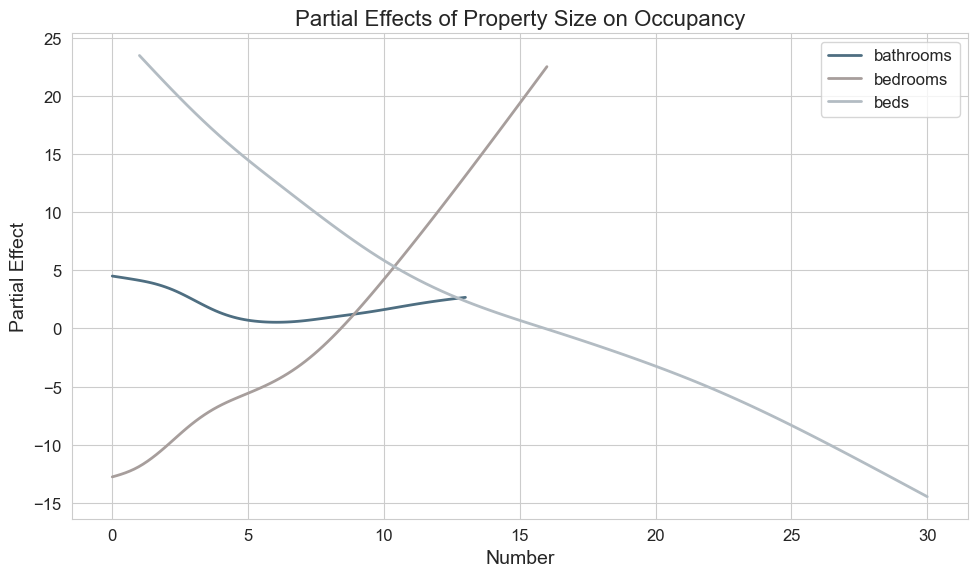

In [91]:
plt.figure(figsize=(10, 6))

for i, feature in enumerate(property_features):
    XX = gam.generate_X_grid(term=i)
    pdep = gam.partial_dependence(term=i, X=XX)
    plt.plot(XX[:, i], pdep, label=feature, linewidth=2)

plt.title('Partial Effects of Property Size on Occupancy')
plt.xlabel('Number')
plt.ylabel('Partial Effect')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model explains less than 1% of variance in occupancy. This suggests many other factors (like price, location, reviews, seasonality, etc.) likely influence occupancy.

We have multicollinearity -> interpreting "which feature has the biggest effect" can be confounded by redundancy among inputs.

- `beds` is the most influential feature. More beds → lower probability of being booked .
- `bedrooms`: more bedrooms improve occupancy, but multicollinearity can masking the effect
- `bathrooms`: the number of bathrooms has no clear influence on 30-day occupancy.

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.6616
Link Function:                     IdentityLink Log Likelihood:                                -79158.4788
Number of Samples:                         9571 AIC:                                           158326.2808
                                                AICc:                                          158326.2863
                                                GCV:                                             1559.4506
                                                Scale:                                           1558.3768
                                                Pseudo R-Squared:                                   0.0026
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.7772
Link Function:                     IdentityLink Log Likelihood:                                -79029.0271
Number of Samples:                         9557 AIC:                                           158067.6086
                                                AICc:                                          158067.6144
                                                GCV:                                             1557.2571
                                                Scale:                                           1556.1493
                                                Pseudo R-Squared:                                   0.0032
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.7931
Link Function:                     IdentityLink Log Likelihood:                                -77661.1519
Number of Samples:                         9397 AIC:                                             155331.89
                                                AICc:                                          155331.8959
                                                GCV:                                             1549.8727
                                                Scale:                                           1548.7466
                                                Pseudo R-Squared:                                   0.0063
Feature Function                  Lam

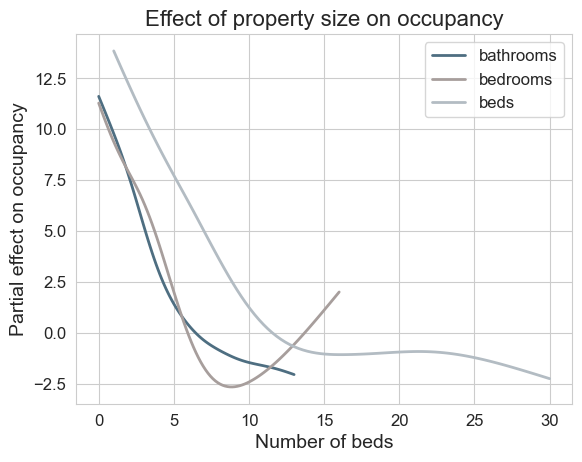

In [92]:
for col in property_features:
    X = df_long.query('period==30')[col].dropna()
    X_array = X.to_numpy().reshape(-1, 1) 
    y = df_long.query('period==30').loc[X.index, 'occupancy_percentage']
    
    # fit GAM with smooth functions (spline) for each feature
    gam = LinearGAM(s(0)).gridsearch(X_array, y)
    
    print(gam.summary())
    
    # plot the partial dependence
    XX = gam.generate_X_grid(term=0)
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), linewidth=2, label=col)
    plt.title(f'Effect of property size on occupancy')
    plt.xlabel(f'Number of {col}')
    plt.ylabel('Partial effect on occupancy')
    plt.grid(True)

plt.legend()
plt.show()

**365-days Time window**

In [93]:
X = df_long.query('period==365')[['bathrooms', 'bedrooms',  'beds']].dropna()
X_array = X.to_numpy()
y = df_long.query('period==365').loc[X.index, 'occupancy_percentage']

# use gridsearch to optimize smoothness penalties
gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_array, y)

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:050:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.5621
Link Function:                     IdentityLink Log Likelihood:                                -74494.0809
Number of Samples:                         9252 AIC:                                            149007.286
                                                AICc:                                          149007.3079
                                                GCV:                                             1253.8861
                                                Scale:                                           1251.7976
                                                Pseudo R-Squared:                                   0.0206
Feature Function                  Lam

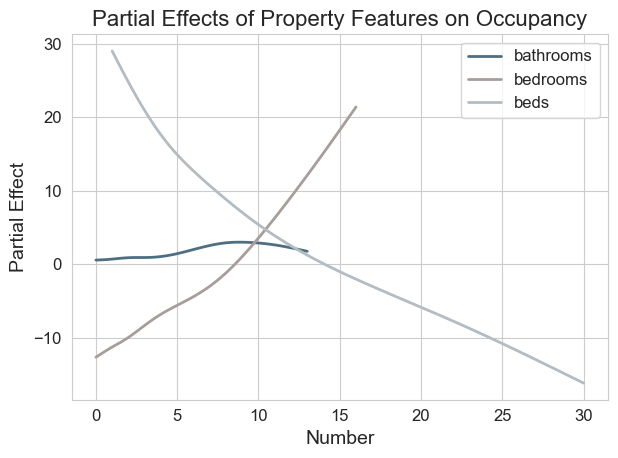

In [94]:
for i, feature in enumerate(property_features):
    XX = gam.generate_X_grid(term=i)
    pdep = gam.partial_dependence(term=i, X=XX)
    plt.plot(XX[:, i], pdep, label=feature, linewidth=2)

plt.title('Partial Effects of Property Features on Occupancy')
plt.xlabel('Number')
plt.ylabel('Partial Effect')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.6616
Link Function:                     IdentityLink Log Likelihood:                                -77272.1453
Number of Samples:                         9571 AIC:                                           154553.6139
                                                AICc:                                          154553.6194
                                                GCV:                                             1280.4036
                                                Scale:                                           1279.5219
                                                Pseudo R-Squared:                                   0.0049
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0659
Link Function:                     IdentityLink Log Likelihood:                                -77081.8595
Number of Samples:                         9557 AIC:                                           154181.8508
                                                AICc:                                          154181.8699
                                                GCV:                                              1271.147
                                                Scale:                                           1269.2161
                                                Pseudo R-Squared:                                    0.013
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.2413
Link Function:                     IdentityLink Log Likelihood:                                -75696.5559
Number of Samples:                         9397 AIC:                                           151407.5945
                                                AICc:                                          151407.6073
                                                GCV:                                             1257.9715
                                                Scale:                                           1256.4677
                                                Pseudo R-Squared:                                   0.0204
Feature Function                  Lam

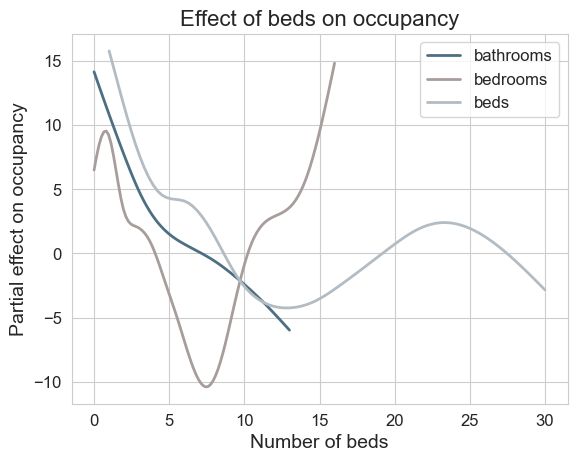

In [95]:
for col in property_features:
    X = df_long.query('period==365')[col].dropna()
    X_array = X.to_numpy().reshape(-1, 1) 
    y = df_long.query('period==365').loc[X.index, 'occupancy_percentage']
    
    # fit GAM with smooth functions (spline) for each feature
    gam = LinearGAM(s(0)).gridsearch(X_array, y)
    
    print(gam.summary())
    
    # plot the partial dependence
    XX = gam.generate_X_grid(term=0)
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), linewidth=2, label=col)
    plt.title(f'Effect of {col} on occupancy')
    plt.xlabel(f'Number of {col}')
    plt.ylabel('Partial effect on occupancy')
    plt.grid(True)

plt.legend()
plt.show()

### Fully-booked properties
Does different numbers of bathrooms, bedrooms and beds affect number of fully-booked properties?
We have polarized occupancy (very high/low) -> let's turn it into a classification task: e.g., is_fully_booked.

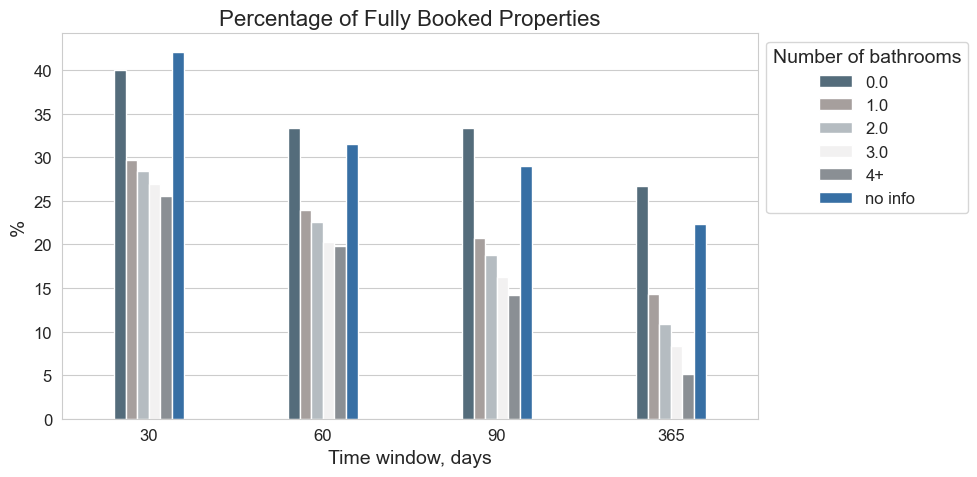

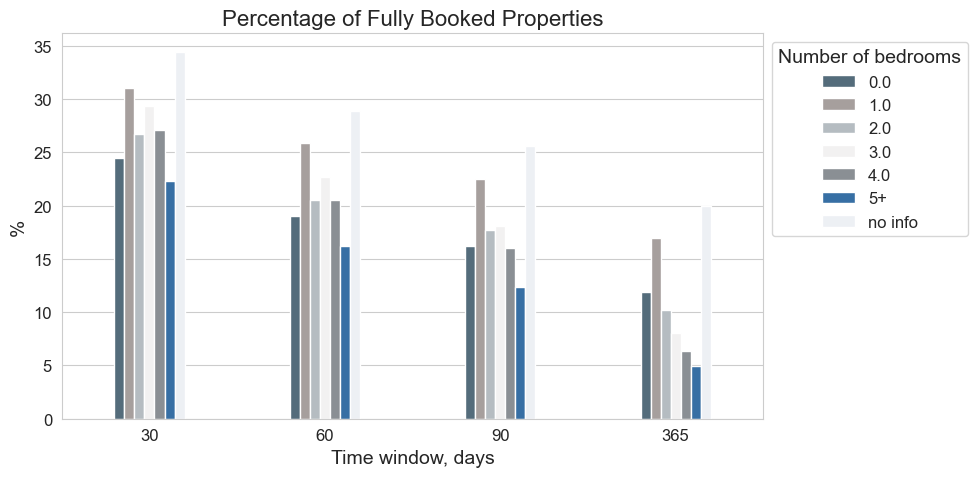

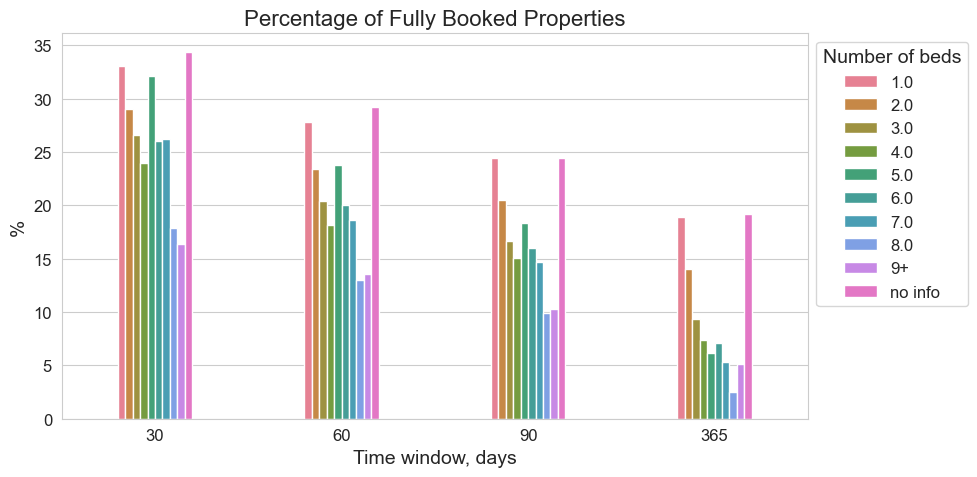

In [96]:
for col in property_features:
    
    res = (df_long
           .groupby(['period', f'{col}_cat'], as_index=False)['is_fully_booked']
           .agg(lambda x: sum(x) / len(x) * 100)
          )

    plt.figure(figsize=(10,5))
    sns.barplot(data=res, y='is_fully_booked', x='period',
                hue=f'{col}_cat', 
                #hue_order=hue_order,
                width=0.4,
                )
    
    plt.title(f'Percentage of Fully Booked Properties')
    plt.ylabel('%')
    plt.xlabel('Time window, days')
    plt.legend(title=f'Number of {col}', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

**Statistical Significance** 

Hypothesis Testing  
Let's perform a statistical test comparing the proportion of fully-booked properties between listings with different size. 
- H₀ (Null Hypothesis): The proportion of fully-booked properties is the same for listingswith different size.
- H₁ (Alternative Hypothesis): The proportion of fully-booked properties differs between listings with different size.

In [97]:
# Chi-Square Test
for col in property_features:
    print(col.upper())
    print('******\n')
    for per in periods:
        
        # contingency table
        df_per = df_long[(df_long['period'] == per) & (df_long[f'{col}_cat']!='no info')]
        
        table = pd.crosstab(df_per[f'{col}_cat'], df_per['is_fully_booked']==1)
        
        chi2, p_value, _, _ = stats.chi2_contingency(table)
 
        print(f'Occupancy across {per} days')
        print(table)
        print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p_value}")
        if p_value < ALPHA:
            print("Reject null hypothesis\n")
        else:
            print("Fail to reject null hypothesis\n")  

BATHROOMS
******

Occupancy across 30 days
is_fully_booked  False  True 
bathrooms_cat                
0.0                  9      6
1.0               4063   1711
2.0               1921    761
3.0                475    175
4+                 335    115
Chi-Square Test: chi2 = 6.450364374165311, p-value = 0.16794481998520625
Fail to reject null hypothesis

Occupancy across 60 days
is_fully_booked  False  True 
bathrooms_cat                
0.0                 10      5
1.0               4391   1383
2.0               2077    605
3.0                518    132
4+                 361     89
Chi-Square Test: chi2 = 9.322909499891493, p-value = 0.05351603941850762
Fail to reject null hypothesis

Occupancy across 90 days
is_fully_booked  False  True 
bathrooms_cat                
0.0                 10      5
1.0               4579   1195
2.0               2178    504
3.0                544    106
4+                 386     64
Chi-Square Test: chi2 = 20.05234200585644, p-value = 0.000487656460

-----------
The proportion of listings that are fully booked (100% occupancy) versus not fully booked is not evenly distributed across the different categories of beds, bedrooms, or bathrooms (chance of being fully booked is not the same for listings with 1 bed vs 4 beds)

- The number of beds (bedrooms, bathrooms) is associated with the likelihood of a listing being fully booked. Some categories are doing significantly better or worse than others.

In [98]:
# formula for logistic regression
formula = 'is_fully_booked ~ bathrooms + bedrooms + beds'

# logistic regression model
lrm = smf.logit(formula=formula, data=df_long.query('period==30')).fit()

# Show summary of results
print(lrm.summary())

Optimization terminated successfully.
         Current function value: 0.596218
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        is_fully_booked   No. Observations:                 9252
Model:                          Logit   Df Residuals:                     9248
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                0.005328
Time:                        13:54:22   Log-Likelihood:                -5516.2
converged:                       True   LL-Null:                       -5545.8
Covariance Type:            nonrobust   LLR p-value:                 9.152e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7898      0.047    -16.967      0.000      -0.881      -0.699
bathrooms      0.0239      0.

In [99]:
np.exp(lrm.params)

Intercept   0.45
bathrooms   1.02
bedrooms    1.15
beds        0.86
dtype: float64

-------------
- Bedrooms: Positively associated with bookings — maybe reflects desirability or optimal size for travelers.
- Beds: Surprisingly, more beds reduce chance of being fully booked — possibly due to:
    - Overcrowded accommodations (less attractive),
    - Larger listings at higher prices = fewer bookings.
- Bathrooms: No statistically significant effect when controlling for bedrooms and beds.

In [100]:
X = df_long.query('period==30')[['bathrooms', 'bedrooms',  'beds']].dropna()
X_array = X.to_numpy()
y_binary = df_long.query('period==30').loc[X.index, 'is_fully_booked']

gam = LogisticGAM(s(0) + s(1) + s(2)).gridsearch(X_array, y_binary)

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:13 Time:  0:00:130:01


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      5.6791
Link Function:                        LogitLink Log Likelihood:                                  -5514.917
Number of Samples:                         9252 AIC:                                            11041.1922
                                                AICc:                                           11041.2032
                                                UBRE:                                               3.1939
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0056
Feature Function                  Lam

----------
Pseudo R-Squared: 0.0056  
Interpretation: These three features alone don’t explain much about whether a listing gets fully booked. Booking likely depends on other factors (location, price, seasonality, reviews, etc.).

- The number of bathrooms has no clear effect on being fully booked once other variables are controlled.
- The number of bedrooms does affect the probability of being fully booked.
- Beds - strongest predictor. More beds make a listing more likely to be fully booked.

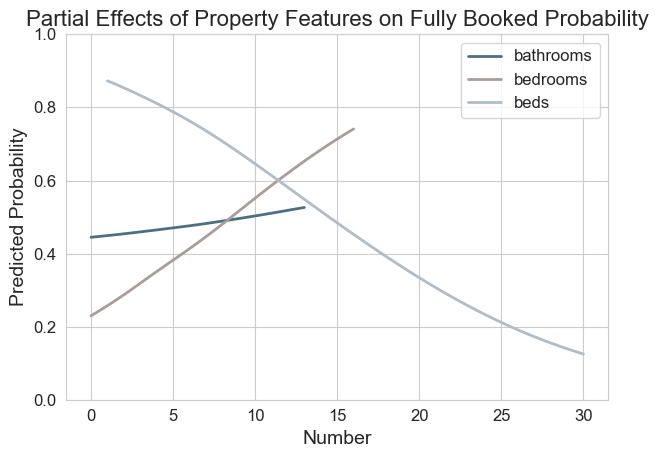

In [101]:
# For each feature index (0 = bathrooms, 1 = bedrooms, 2 = beds)
for i, feature in enumerate(property_features):
    XX = gam.generate_X_grid(term=i)
    partial_logodds = gam.partial_dependence(term=i, X=XX)
    
    # manually apply the logistic function to get probabilities
    partial_probs = 1 / (1 + np.exp(-partial_logodds))

    plt.plot(XX[:, i], partial_probs, linewidth=2, label=feature)

plt.title('Partial Effects of Property Features on Fully Booked Probability')
plt.xlabel('Number')
plt.ylabel('Predicted Probability')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [102]:
X = df_long.query('period==365')[['bathrooms', 'bedrooms',  'beds']].dropna()
X_array = X.to_numpy()
y_binary = df_long.query('period==365').loc[X.index, 'is_fully_booked']

gam = LogisticGAM(s(0) + s(1) + s(2)).gridsearch(X_array, y_binary)

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:090:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.8353
Link Function:                        LogitLink Log Likelihood:                                 -3324.8289
Number of Samples:                         9252 AIC:                                             6667.3283
                                                AICc:                                            6667.3514
                                                UBRE:                                               2.7214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0351
Feature Function                  Lam

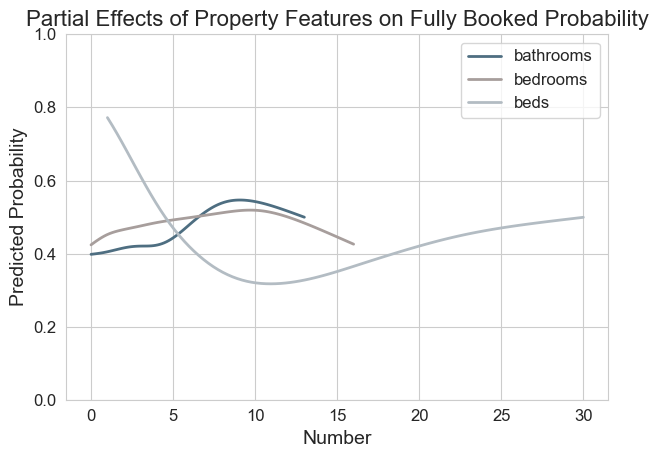

In [103]:
# For each feature index (0 = bathrooms, 1 = bedrooms, 2 = beds)
for i, feature in enumerate(property_features):
    XX = gam.generate_X_grid(term=i)
    partial_logodds = gam.partial_dependence(term=i, X=XX)
    
    # manually apply the logistic function to get probabilities
    partial_probs = 1 / (1 + np.exp(-partial_logodds))

    plt.plot(XX[:, i], partial_probs, linewidth=2, label=feature)

plt.title('Partial Effects of Property Features on Fully Booked Probability')
plt.xlabel('Number')
plt.ylabel('Predicted Probability')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### By City

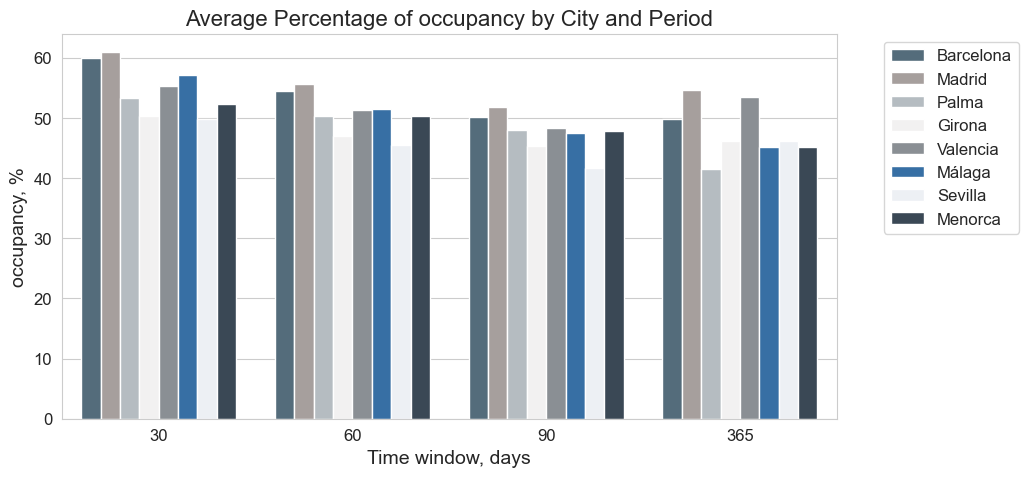

In [104]:
# availability por city
plt.figure(figsize=(10, 5))
sns.barplot(data=df_long, x='period', y='occupancy_percentage', 
            hue='city', errorbar=None,
            hue_order=city_order)
plt.title('Average Percentage of occupancy by City and Period')
plt.ylabel('occupancy, %')
plt.xlabel('Time window, days')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=None)
plt.show()

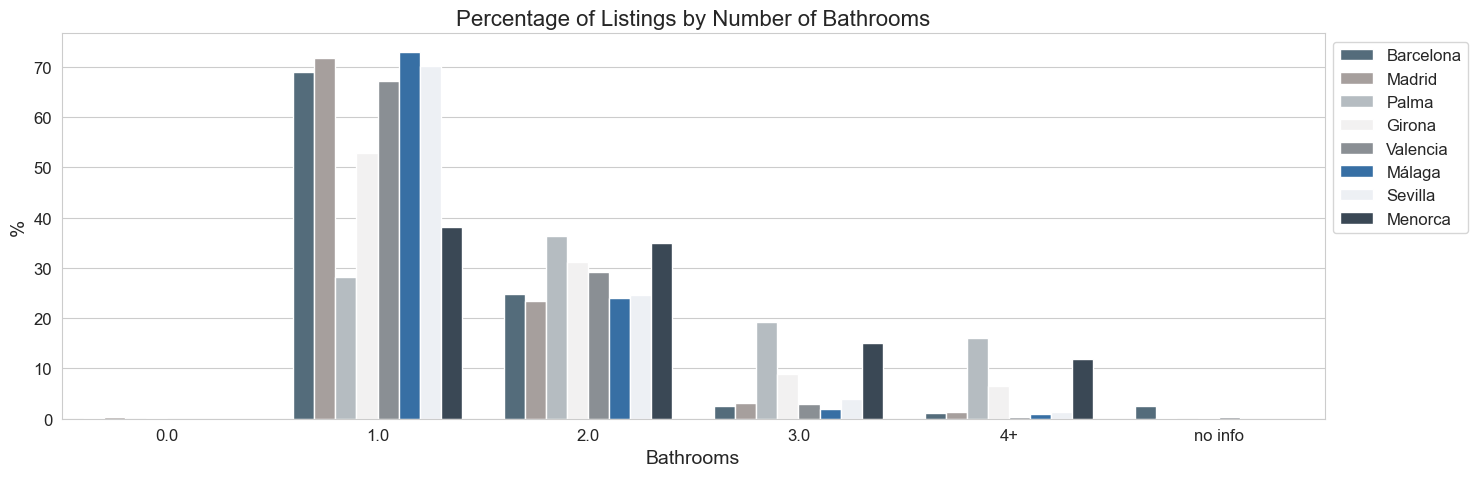

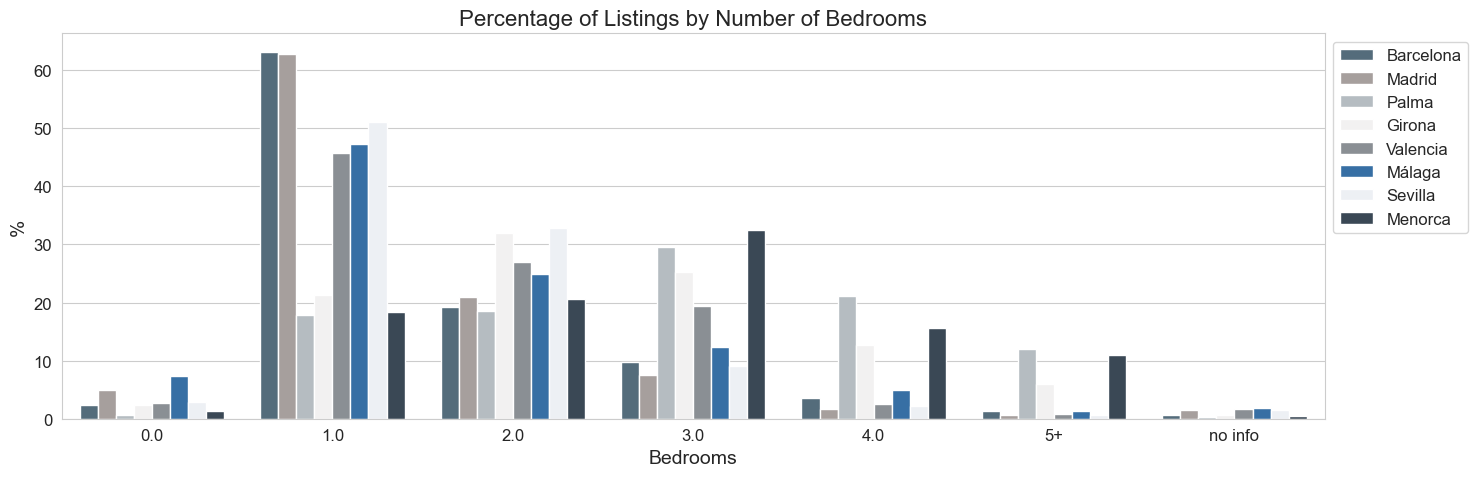

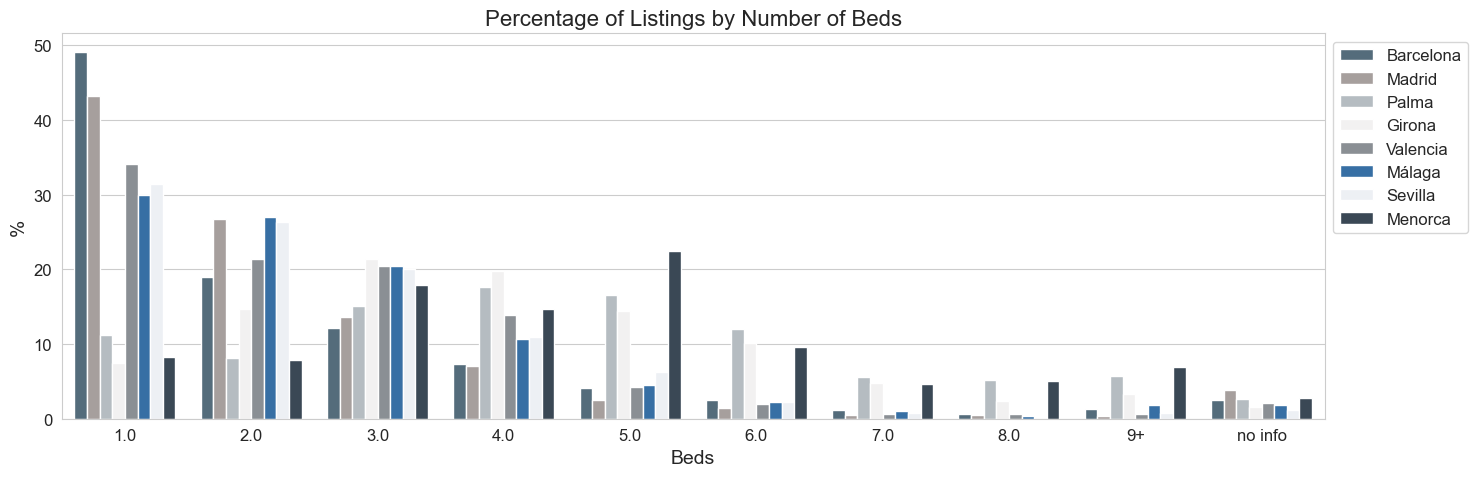

In [105]:
for feature in property_features:
    col = feature+'_cat'
    # Filter the data for the selected period
    df_filtered = df_long.query('period == 30')
    
    # Calculate counts
    count_data = (
        df_filtered.groupby(['city', col])
        .size()
        .reset_index(name='count')
    )

    # Calculate percentages
    total_per_group = count_data.groupby('city')['count'].transform('sum')
    count_data['percentage'] = 100 * count_data['count'] / total_per_group

    # Sort labels
    labels = sorted(df_filtered[col].unique())

    plt.figure(figsize=(15,5))
    sns.barplot(
        data=count_data,
        x=col,
        y='percentage',
        hue='city',
        hue_order=city_order,
        order=labels
    )

    plt.title(f"Percentage of Listings by Number of {col.replace('_cat', '').capitalize()}")
    plt.ylabel('%')
    plt.xlabel(col.replace('_cat', '').capitalize())
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

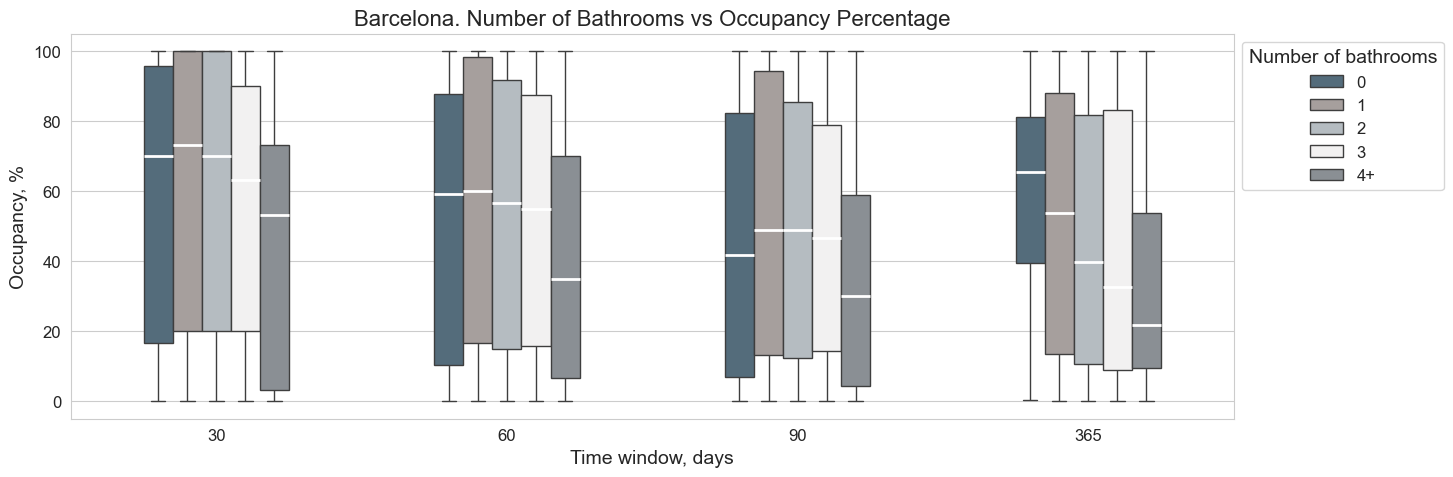

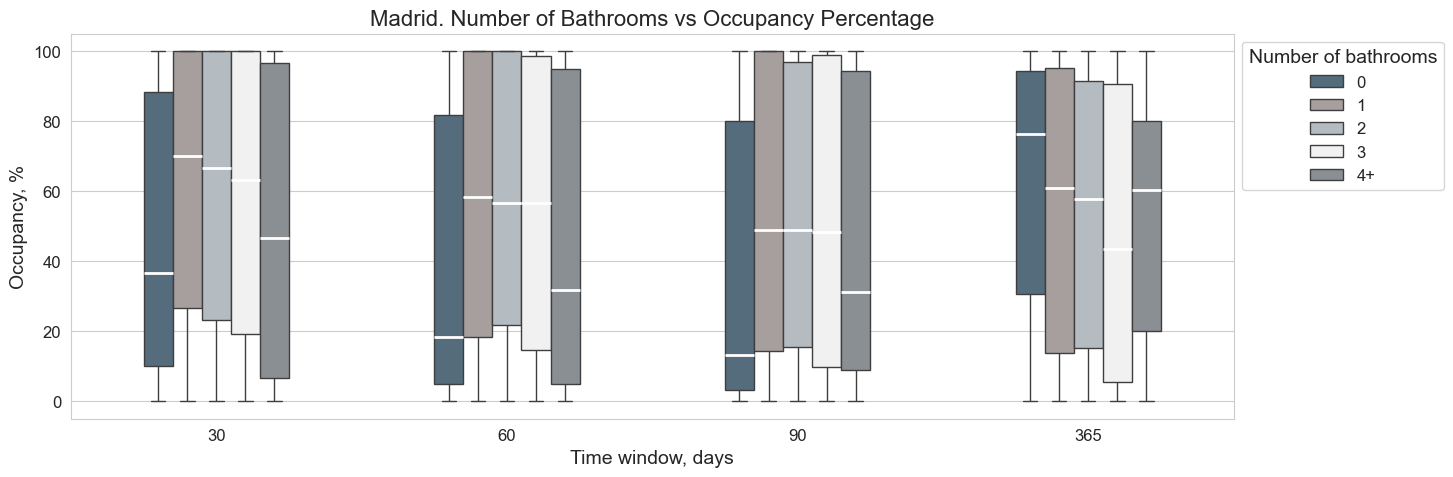

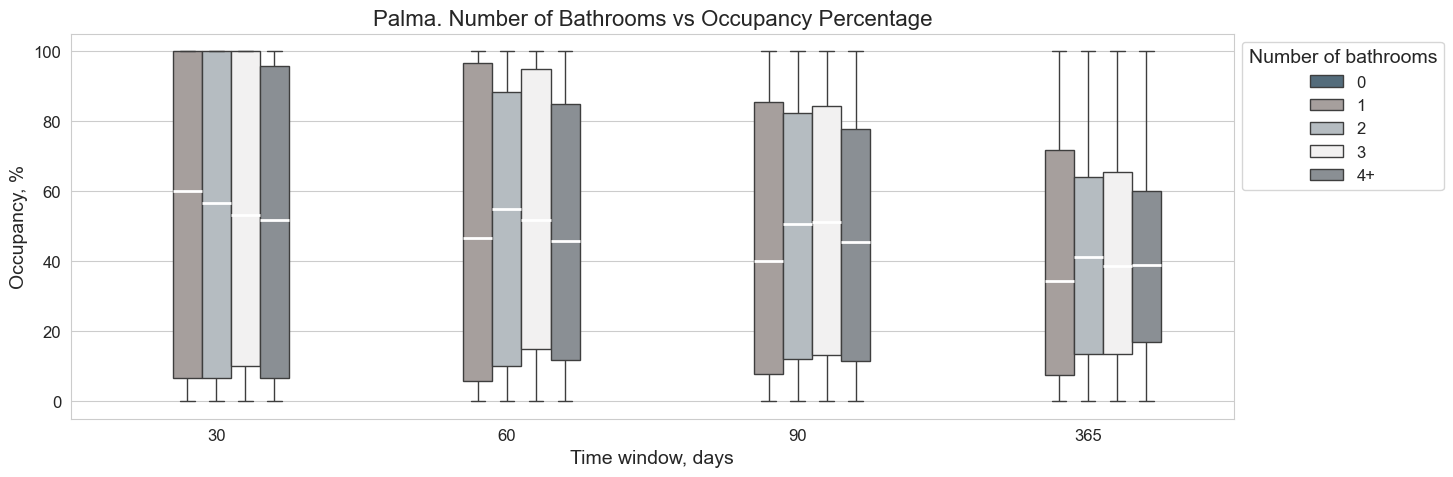

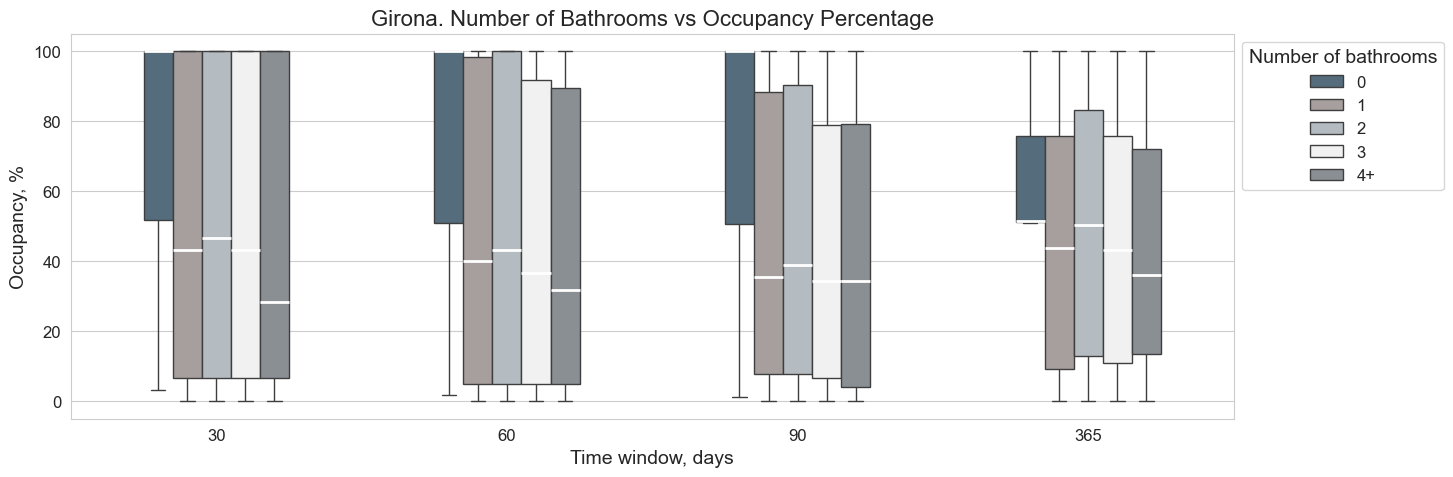

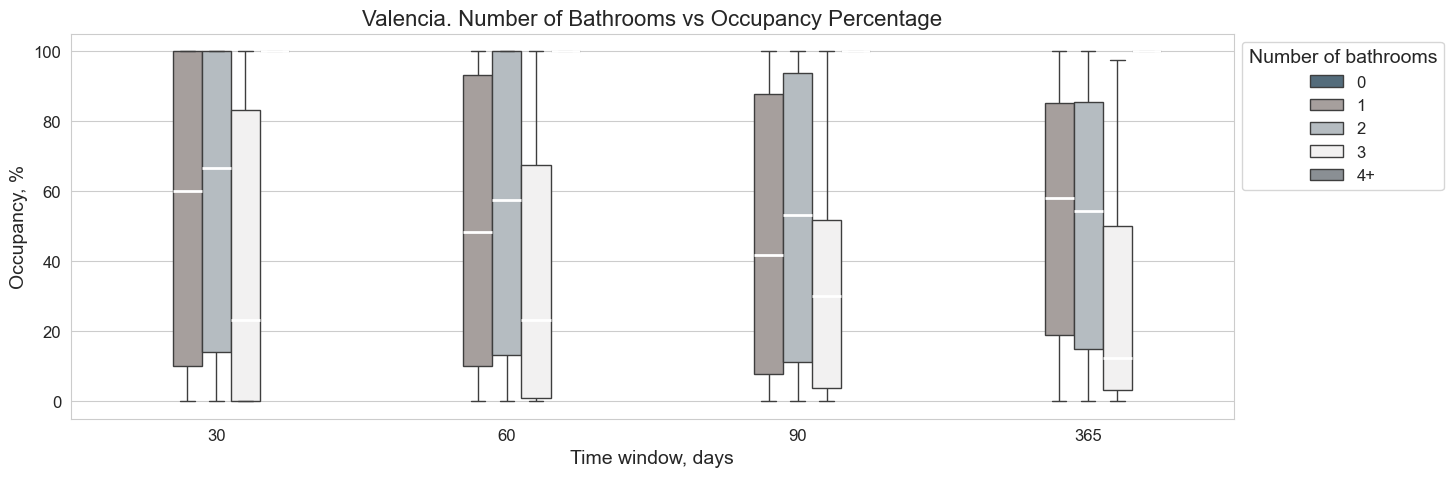

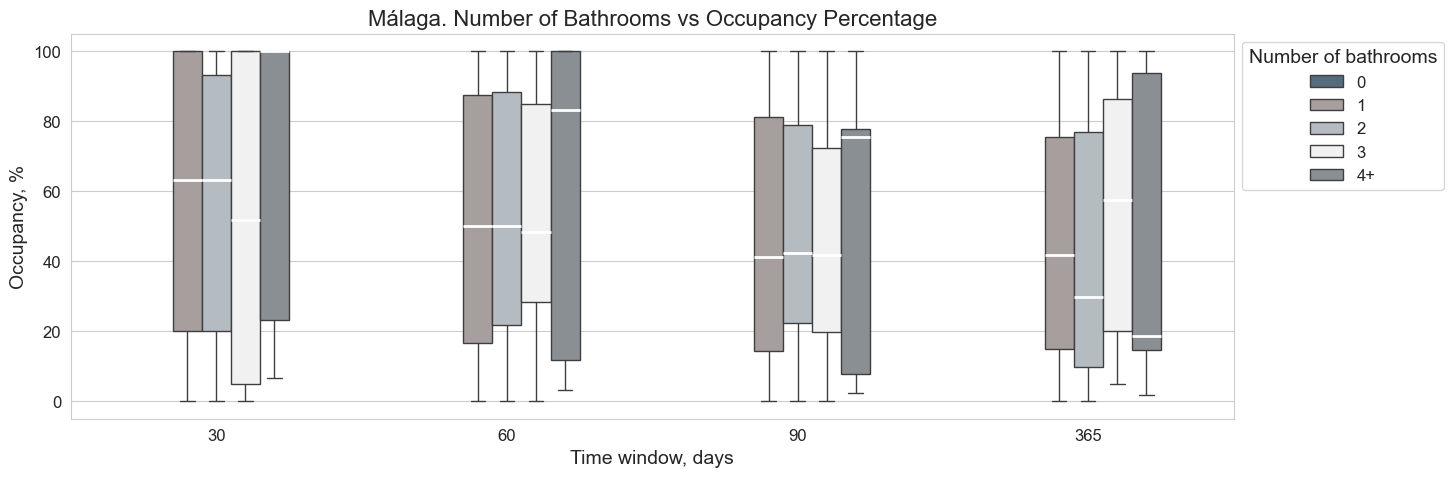

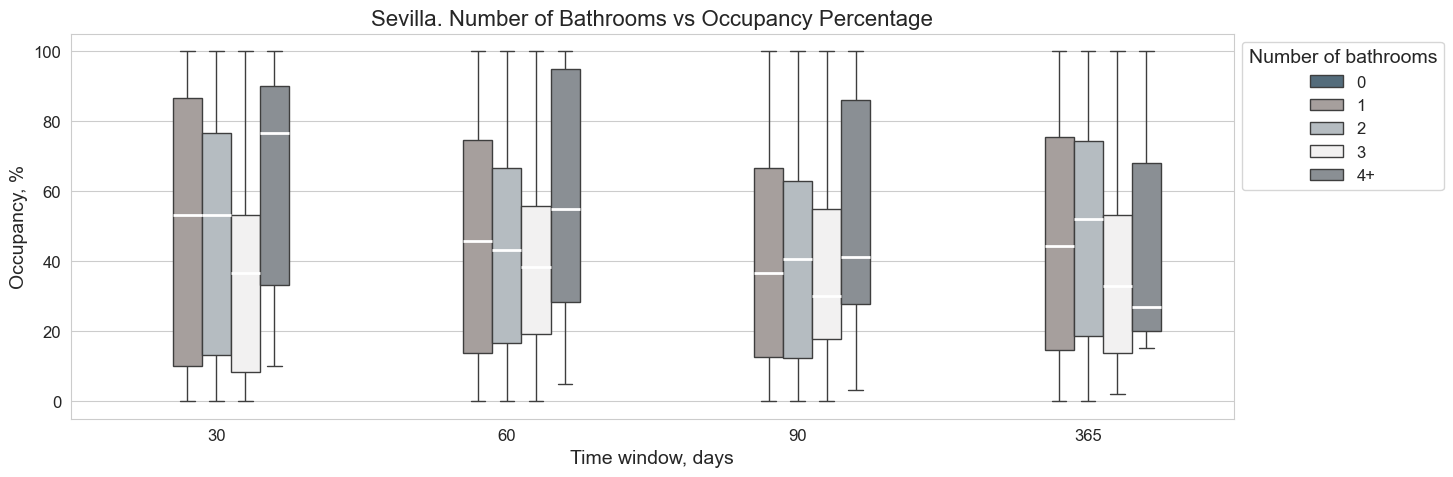

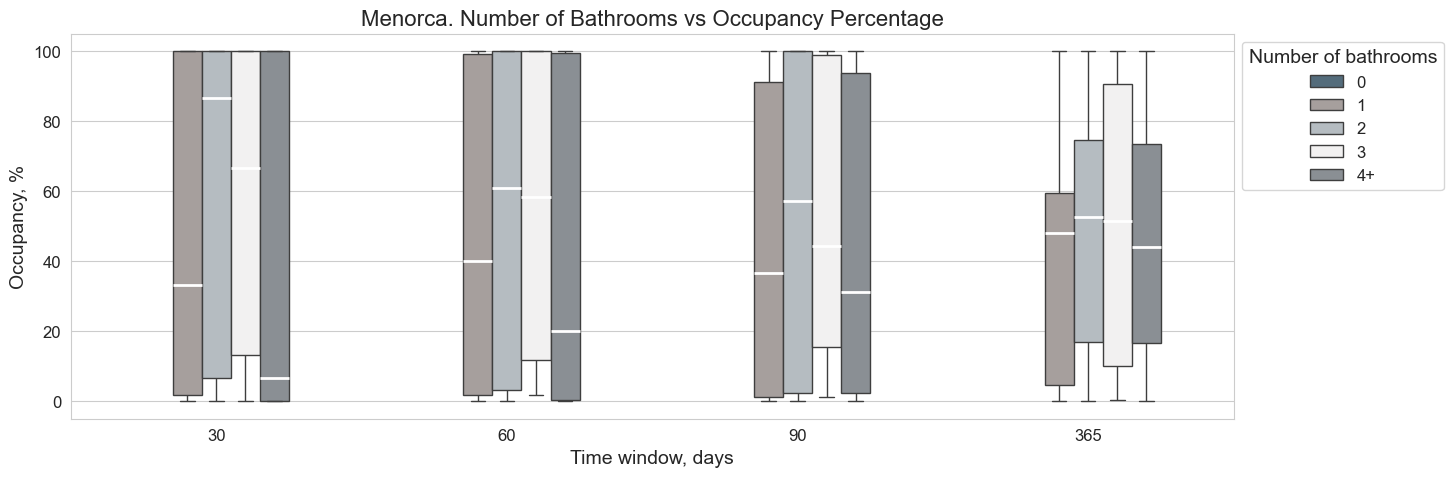

In [106]:
for city in city_order:
    # boxplots
    plt.figure(figsize=(15,5))
    sns.boxplot(data=bathrooms.query('city==@city'),
                x='period', y='occupancy_percentage',
                hue='bathrooms_cat', 
                hue_order=['0', '1', '2', '3', '4+'],
                width=0.5, 
                medianprops={"color": "w", "linewidth": 2}
               )
    
    plt.title(f'{city}. Number of Bathrooms vs Occupancy Percentage')
    plt.legend(title='Number of bathrooms', bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel('Time window, days')
    plt.ylabel('Occupancy, %')
    plt.show()

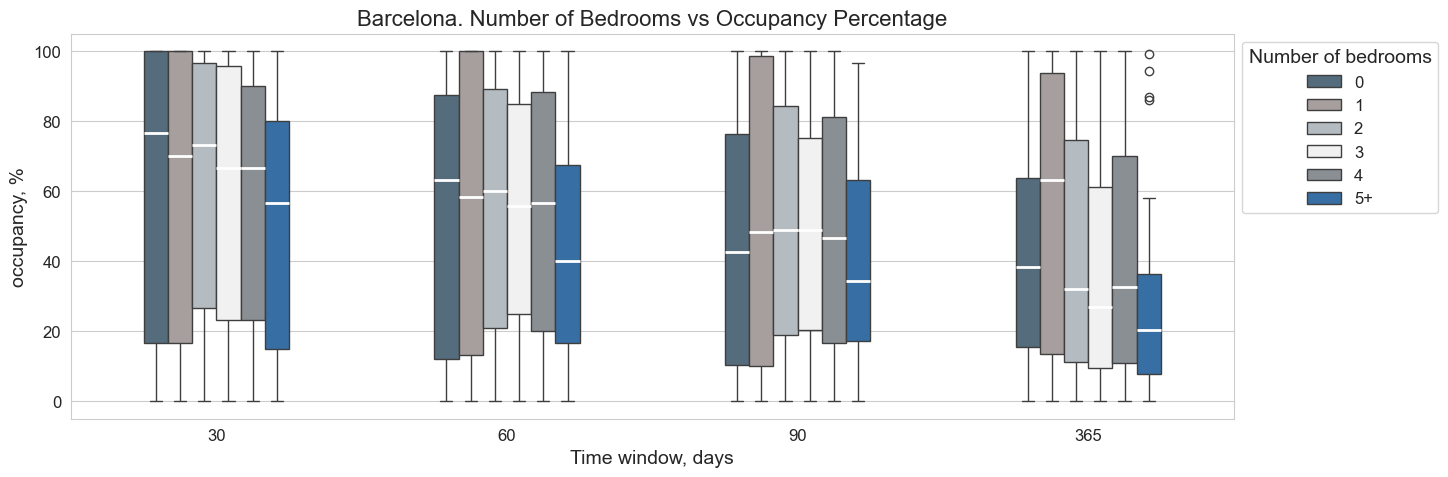

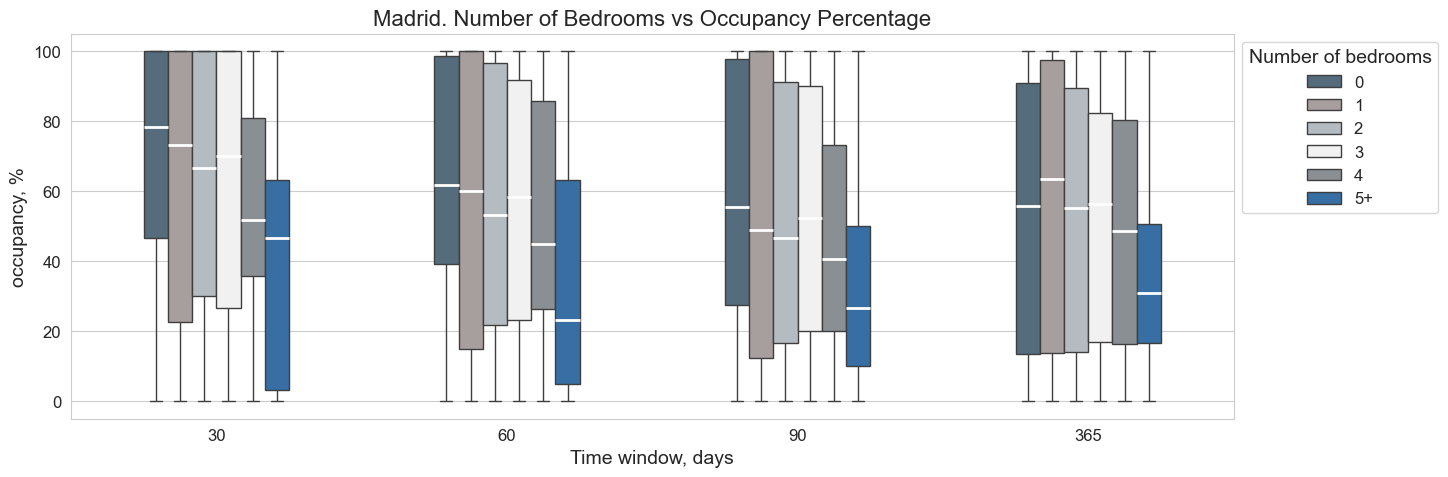

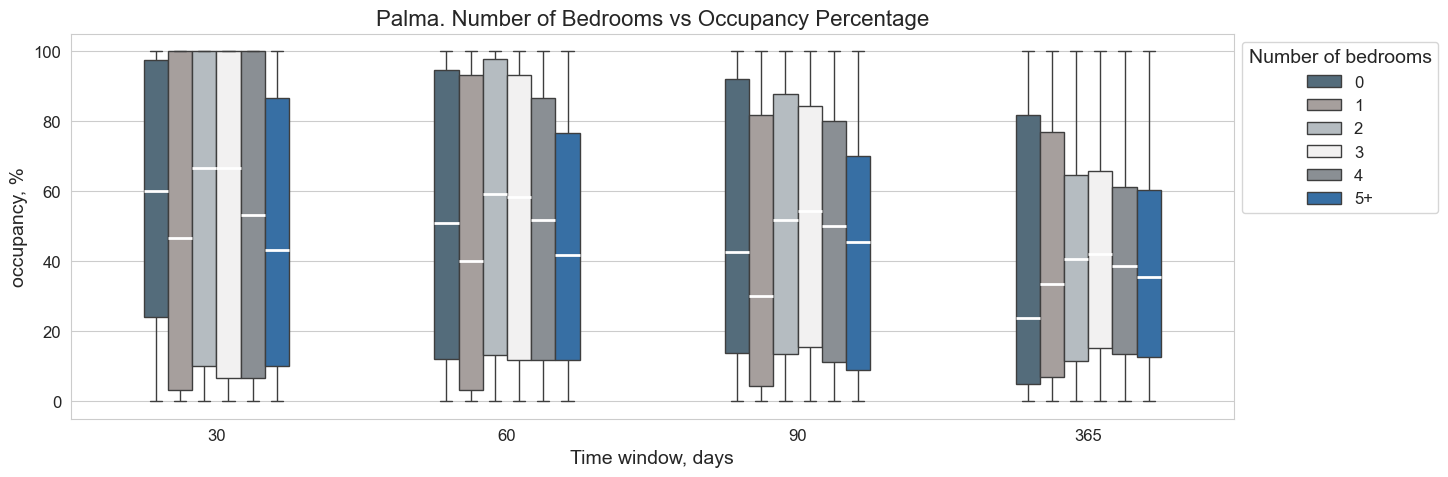

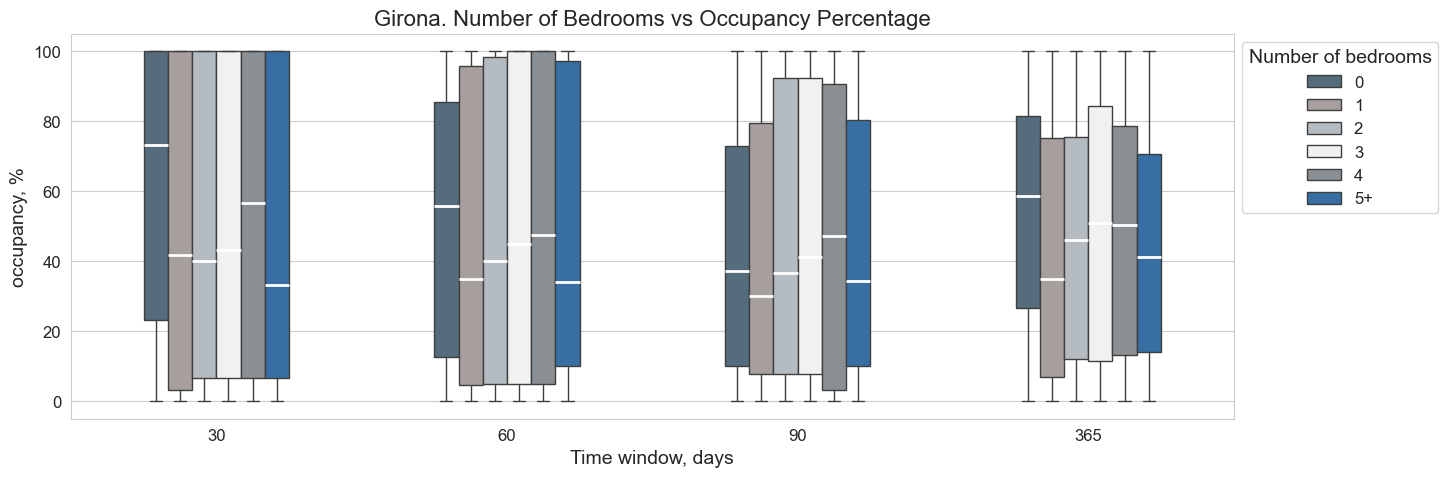

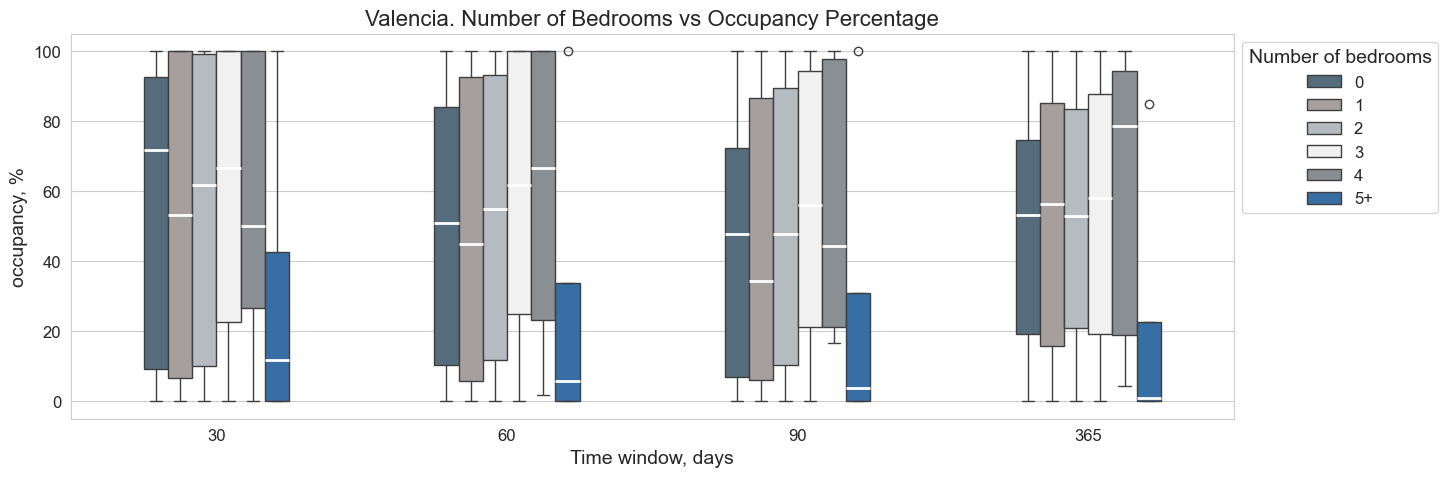

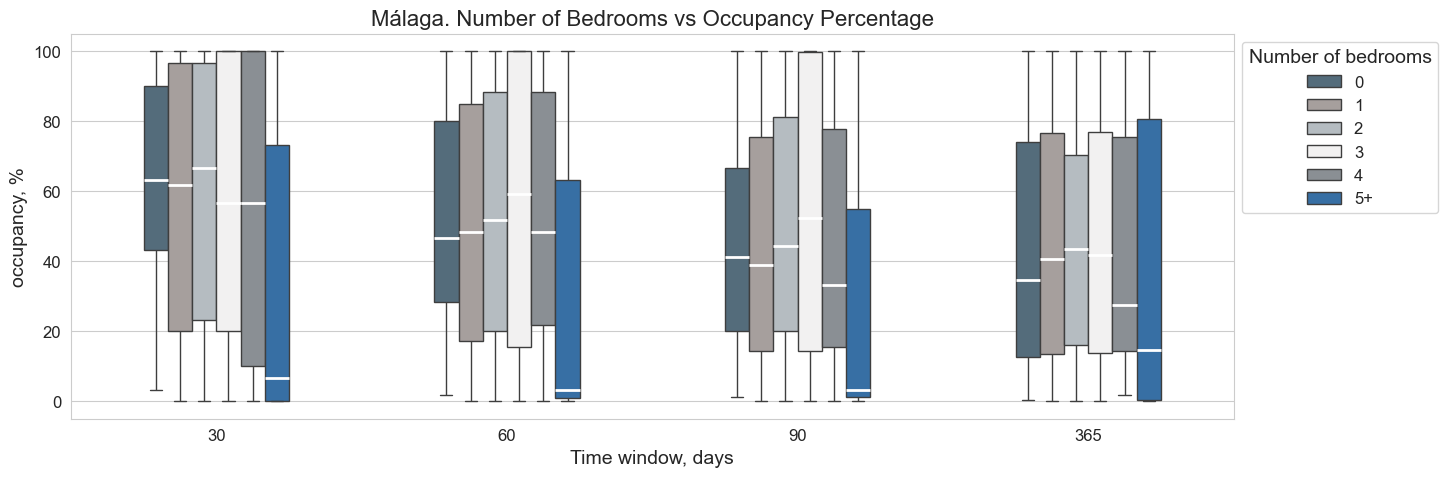

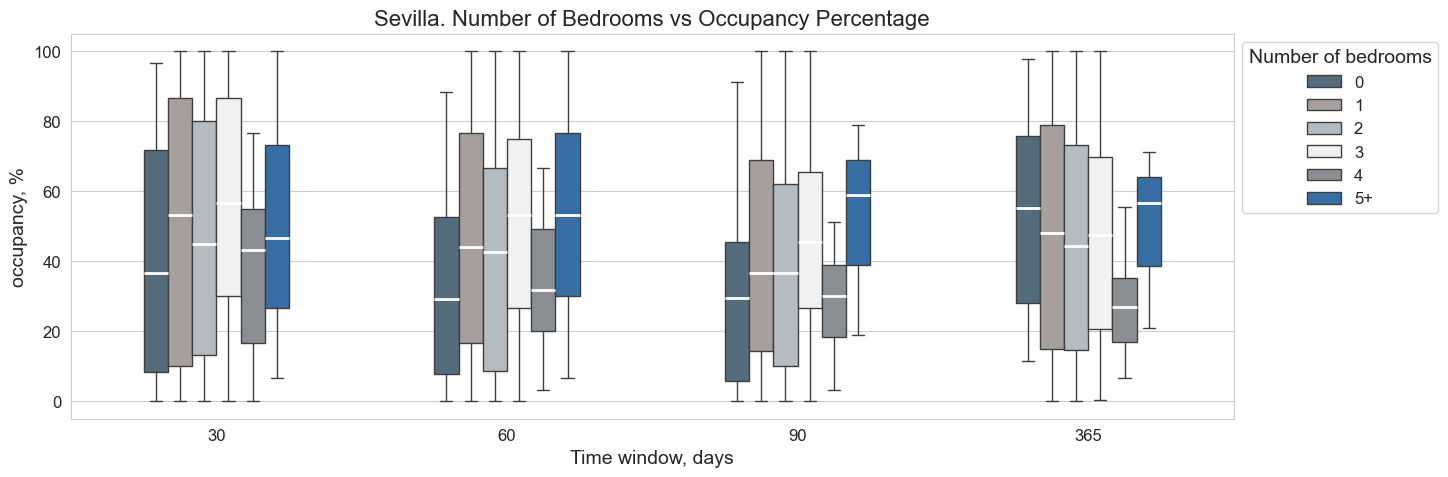

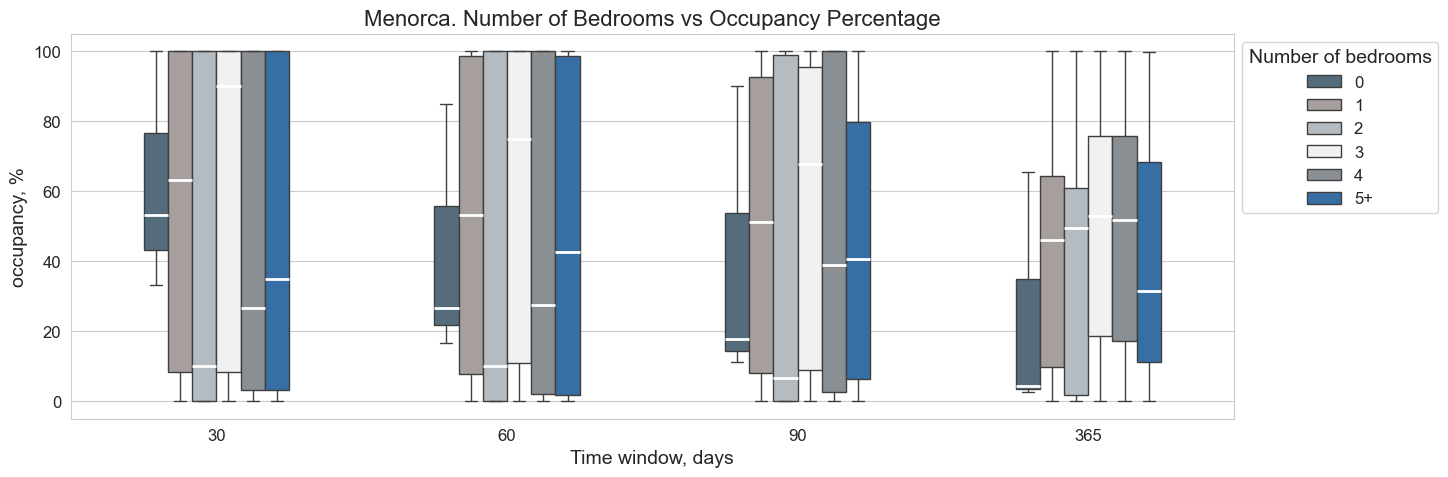

In [107]:
for city in city_order:
    # boxplots
    plt.figure(figsize=(15,5))
    sns.boxplot(data=bedrooms.query('city==@city'),
                x='period', y='occupancy_percentage',
                hue='bedrooms_cat', 
                hue_order=['0', '1', '2', '3', '4', '5+'],
                width=0.5, 
                medianprops={"color": "w", "linewidth": 2}
               )
    
    plt.title(f'{city}. Number of Bedrooms vs Occupancy Percentage')
    plt.legend(title='Number of bedrooms', bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel('Time window, days')
    plt.ylabel('occupancy, %')
    plt.show()

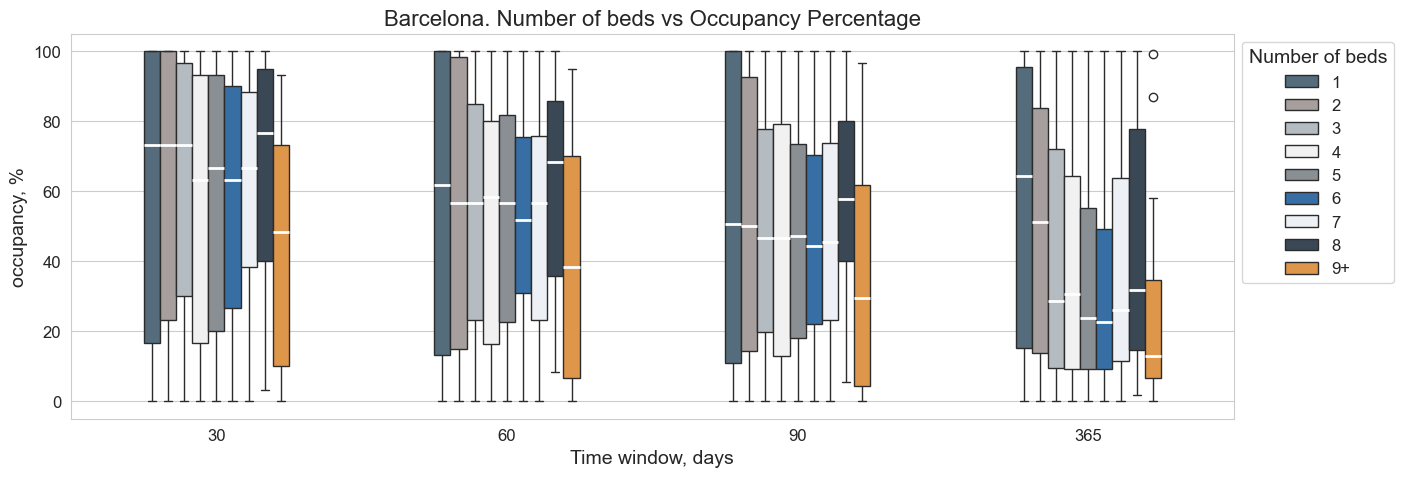

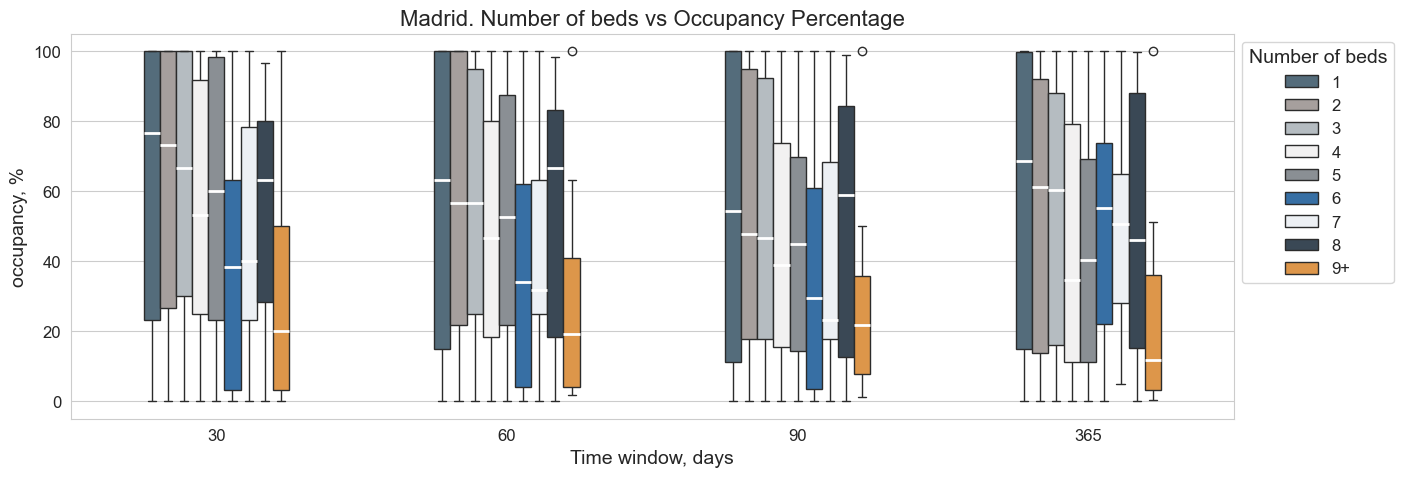

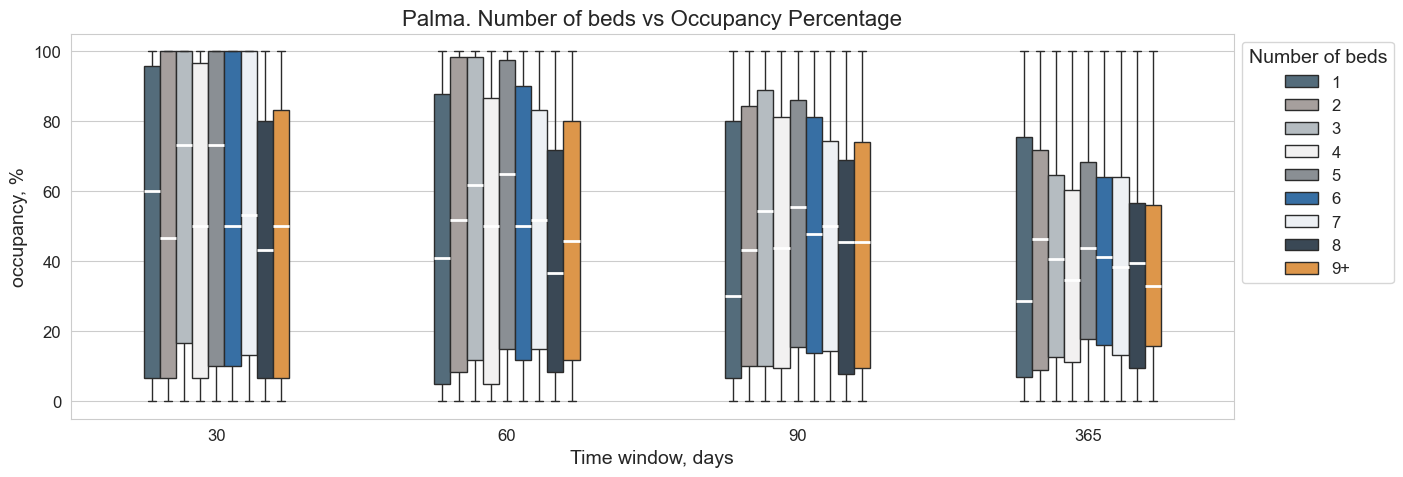

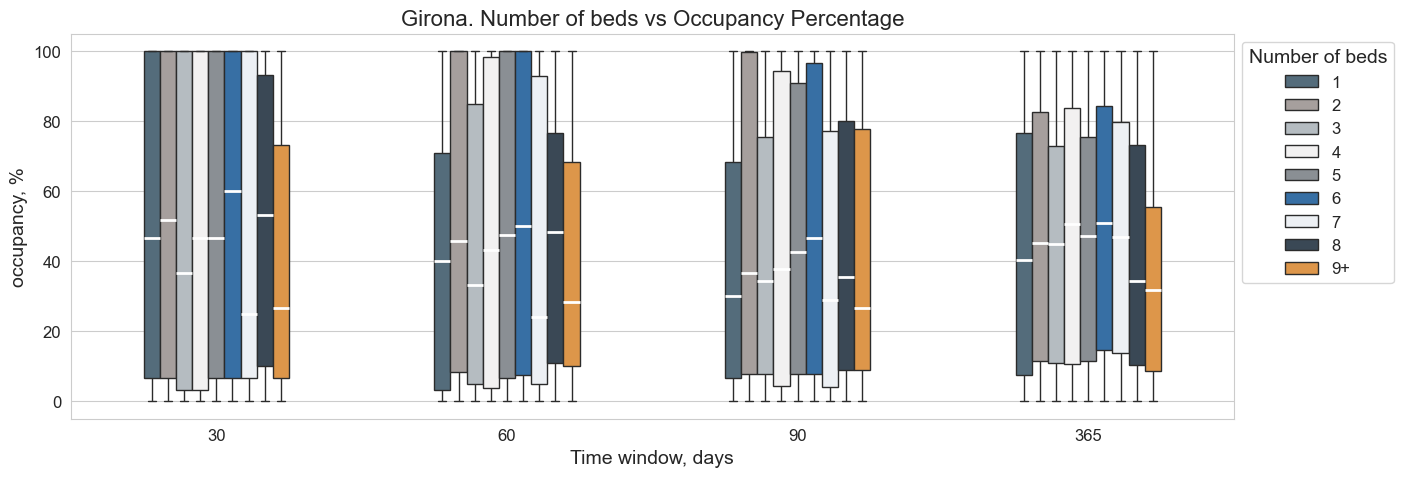

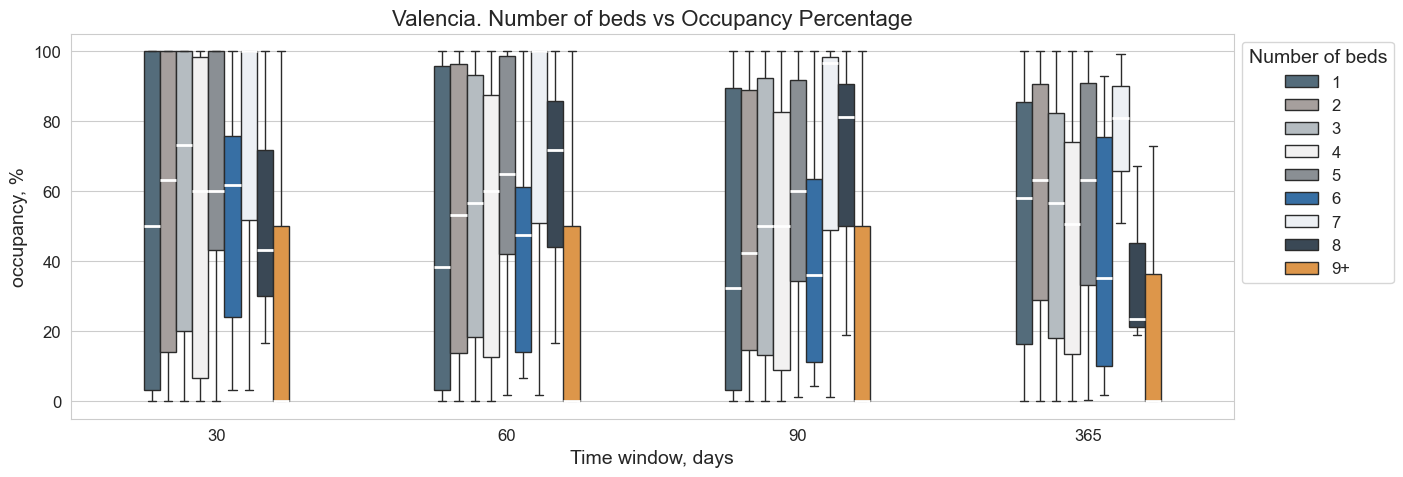

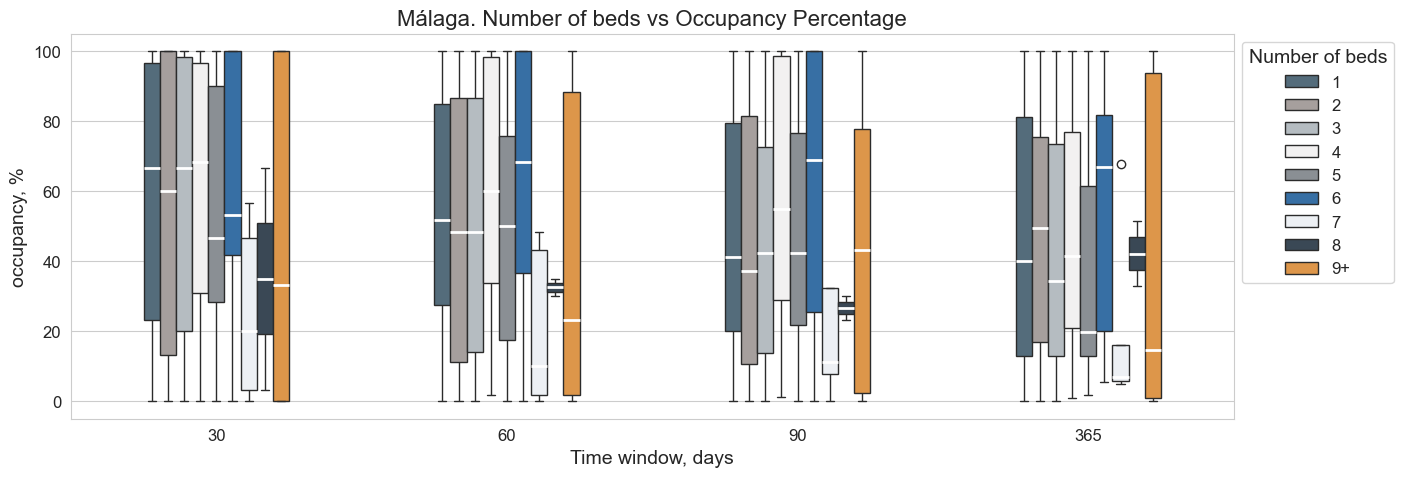

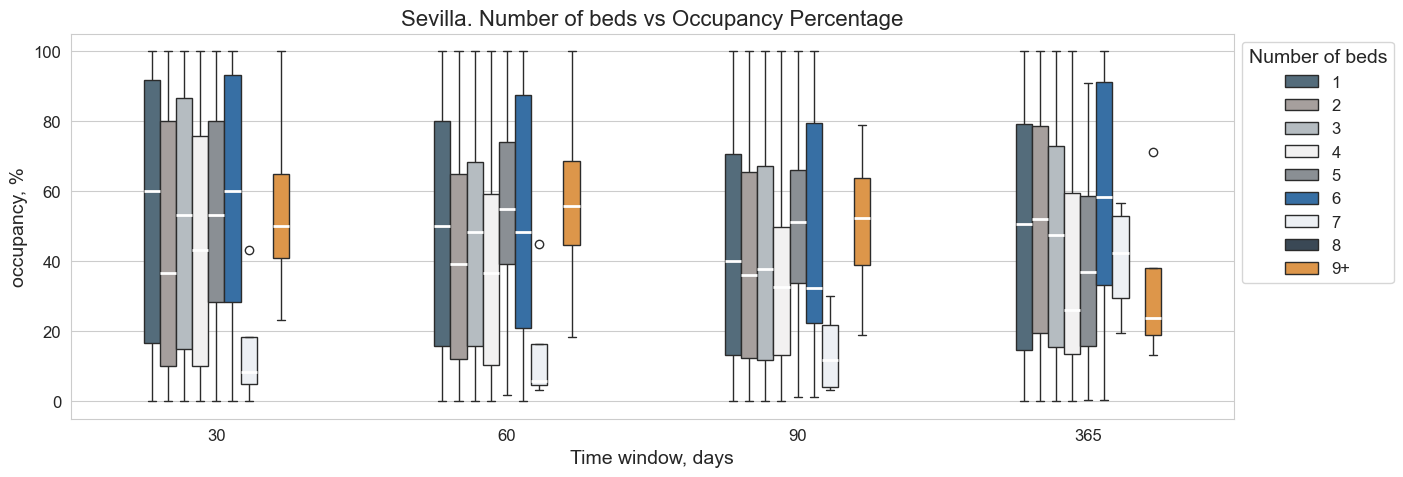

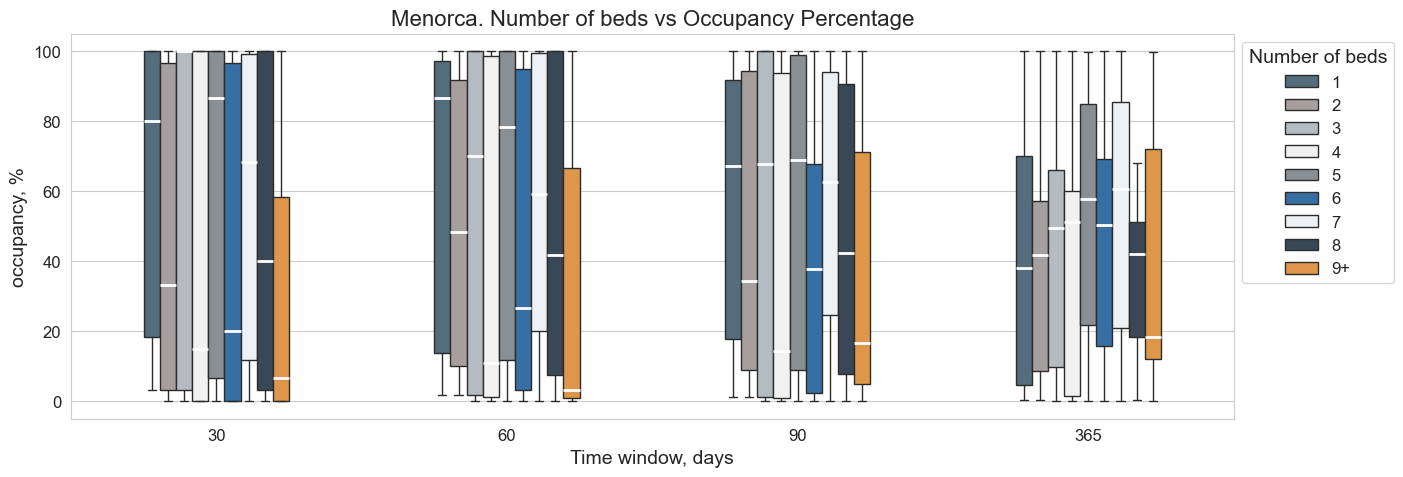

In [108]:
for city in city_order:
    # boxplots
    plt.figure(figsize=(15,5))
    sns.boxplot(data=beds.query('city==@city'),
            x='period', y='occupancy_percentage',
            hue='beds_cat', 
            hue_order=['1', '2', '3', '4', '5', '6', '7', '8', '9+'],
            width=0.5, 
            medianprops={"color": "w", "linewidth": 2}
           )
    
    plt.title(f'{city}. Number of beds vs Occupancy Percentage')
    plt.legend(title='Number of beds', bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel('Time window, days')
    plt.ylabel('occupancy, %')
    plt.show()

In [109]:
for col in property_features:
    for city in city_order:
        res = df_long[(df_long['city'] == city) & (df_long[f'{col}_cat'] != 'no info')]
        print(f'{col.upper()}. {city.capitalize()}')
        print('----------------------------------------')
        kw_test(res, col)

BATHROOMS. Barcelona
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 11.444, p-value = 0.022004549775079766
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 60 days
Kruskal-Wallis Statistic: 9.257, p-value = 0.05499527598692761
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 7.150, p-value = 0.12818999081870902
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 21.361, p-value = 0.0002684894759387864
Reject null hypothesis
Tukey's test for pairwise comparisons



BATHROOMS. Madrid
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 4.953, p-value = 0.2921983740455437
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 3.282, p-value = 0.5117844421731985
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 2.882, p-value = 0.5776999736251495
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 3.273, p-value = 0.5132079864716637
Fail to reject null hypothesis

BATHROOMS. Palma
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 0.956, p-value = 0.812004072092506
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 1.558, p-value = 0.6688942633144767
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 2.834, p-value = 0.4179039260665717
Fail to reject nul



******

Occupancy across 365 days
Kruskal-Wallis Statistic: 12.038, p-value = 0.007253936360323039
Reject null hypothesis
Tukey's test for pairwise comparisons



BATHROOMS. Málaga
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 1.300, p-value = 0.7290201861089196
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 0.471, p-value = 0.9252430520173978
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 0.478, p-value = 0.9237598923494694
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 1.302, p-value = 0.7285848356032025
Fail to reject null hypothesis

BATHROOMS. Sevilla
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 2.975, p-value = 0.3954783610932334
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 1.374, p-value = 0.7116900994537099
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 1.042, p-value = 0.7909918582571391
Fail to reject 


BEDROOMS. Madrid
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 8.588, p-value = 0.12669119522618613
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 7.828, p-value = 0.1659741117829882
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 6.714, p-value = 0.2427988285043182
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 10.242, p-value = 0.06866748493409199
Fail to reject null hypothesis

BEDROOMS. Palma
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 8.677, p-value = 0.1226412526274545
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 10.390, p-value = 0.06492073216394756
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 13.098, p-value = 0.02248140241975999
Reject null 



******

Occupancy across 365 days
Kruskal-Wallis Statistic: 2.921, p-value = 0.7121956625297189
Fail to reject null hypothesis

BEDROOMS. Girona
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 3.545, p-value = 0.6165725188979538
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 2.158, p-value = 0.826811961025852
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 3.120, p-value = 0.6814246543657666
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 9.570, p-value = 0.08837585434529316
Fail to reject null hypothesis

BEDROOMS. Valencia
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 5.652, p-value = 0.3415714012329113
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 7.887, p-value = 0.16256064747881183
Fail to reject



******

Occupancy across 60 days
Kruskal-Wallis Statistic: 16.714, p-value = 0.033227270464195734
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 90 days
Kruskal-Wallis Statistic: 13.273, p-value = 0.10277966011654693
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 124.508, p-value = 3.880775593765699e-23
Reject null hypothesis
Tukey's test for pairwise comparisons



BEDS. Madrid
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 31.002, p-value = 0.0001404162700623293
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 60 days
Kruskal-Wallis Statistic: 22.439, p-value = 0.004163769550688764
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 90 days
Kruskal-Wallis Statistic: 18.621, p-value = 0.01702264918292328
Reject null hypothesis
Tukey's test for pairwise comparisons




******

Occupancy across 365 days
Kruskal-Wallis Statistic: 32.168, p-value = 8.689739735062075e-05
Reject null hypothesis
Tukey's test for pairwise comparisons



BEDS. Palma
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 14.420, p-value = 0.07145767363270498
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 14.780, p-value = 0.06357259776825173
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 11.892, p-value = 0.15607384264528767
Fail to reject null hypothesis


******

Occupancy across 365 days
Kruskal-Wallis Statistic: 6.462, p-value = 0.5956496592614262
Fail to reject null hypothesis

BEDS. Girona
----------------------------------------

******

Occupancy across 30 days
Kruskal-Wallis Statistic: 8.039, p-value = 0.4296240871653061
Fail to reject null hypothesis


******

Occupancy across 60 days
Kruskal-Wallis Statistic: 8.359, p-value = 0.3992294241610292
Fail to reject null hypothesis


******

Occupancy across 90 days
Kruskal-Wallis Statistic: 6.440, p-value = 0.5980148615945848
Fail to reject null h

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



--- BARCELONA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.3899
Link Function:                     IdentityLink Log Likelihood:                                -20790.1964
Number of Samples:                         2572 AIC:                                            41597.1727
                                                AICc:                                           41597.2341
                                                GCV:                                             1298.7269
                                                Scale:                                           1292.0119
                                                Pseudo R-Squared:                                   0.0541
Feature Function  

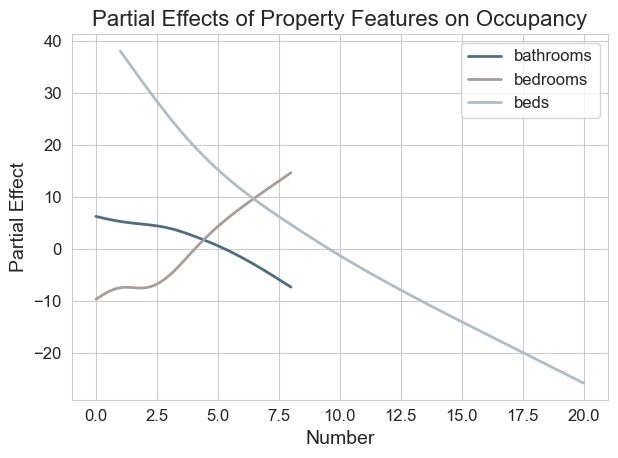

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


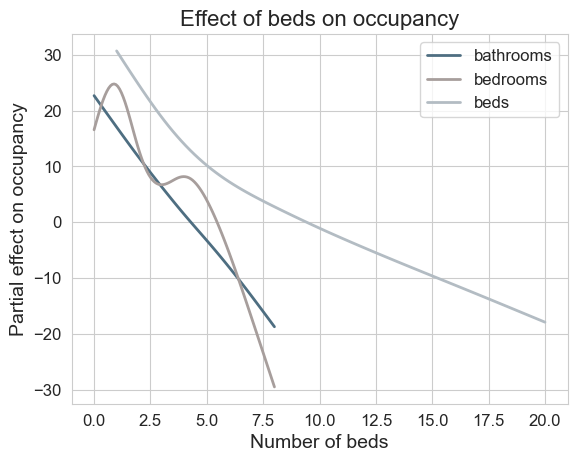

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



--- MADRID ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.0044
Link Function:                     IdentityLink Log Likelihood:                                -16501.1406
Number of Samples:                         2023 AIC:                                            33018.2901
                                                AICc:                                           33018.3616
                                                GCV:                                             1399.2904
                                                Scale:                                           1390.5722
                                                Pseudo R-Squared:                                   0.0157
Feature Function     

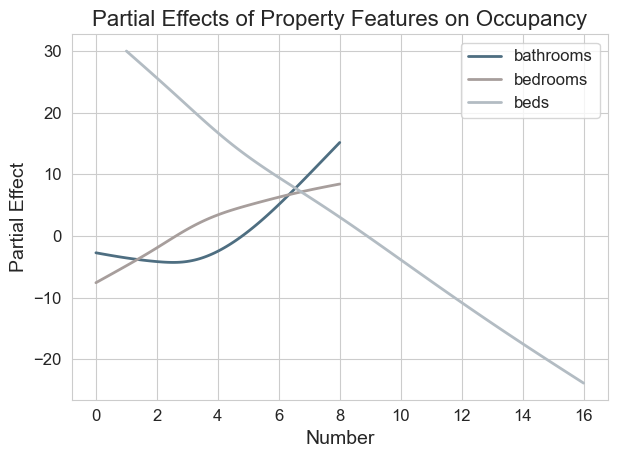

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


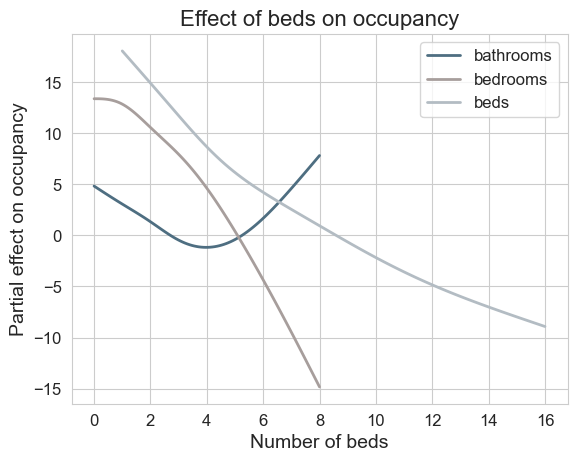

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00


--- PALMA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.8301
Link Function:                     IdentityLink Log Likelihood:                                -12041.4681
Number of Samples:                         1537 AIC:                                            24098.5963
                                                AICc:                                           24098.6868
                                                GCV:                                             1015.3531
                                                Scale:                                           1007.2347
                                                Pseudo R-Squared:                                   0.0047
Feature Function      

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



--- GIRONA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.7366
Link Function:                     IdentityLink Log Likelihood:                                  -11668.05
Number of Samples:                         1451 AIC:                                            23351.5732
                                                AICc:                                           23351.6669
                                                GCV:                                             1249.4185
                                                Scale:                                           1238.9816
                                                Pseudo R-Squared:                                   0.0095
Feature Function     

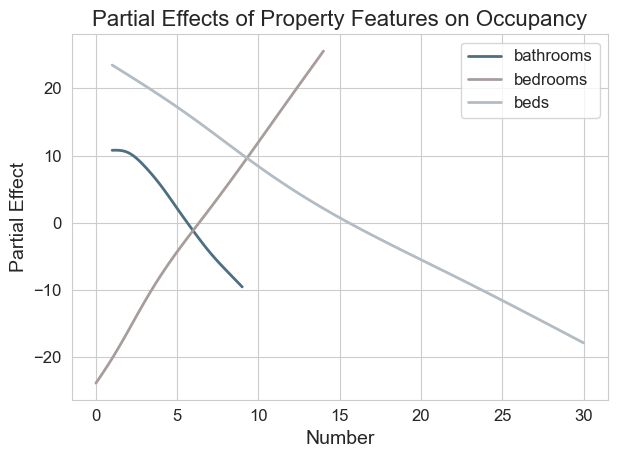

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


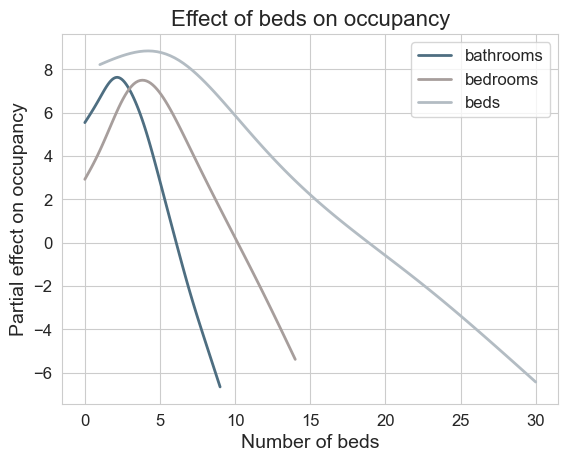

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



--- VALENCIA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.3911
Link Function:                     IdentityLink Log Likelihood:                                  -3955.583
Number of Samples:                          492 AIC:                                             7925.9481
                                                AICc:                                            7926.2046
                                                GCV:                                             1266.6074
                                                Scale:                                           1237.0261
                                                Pseudo R-Squared:                                   0.0259
Feature Function   

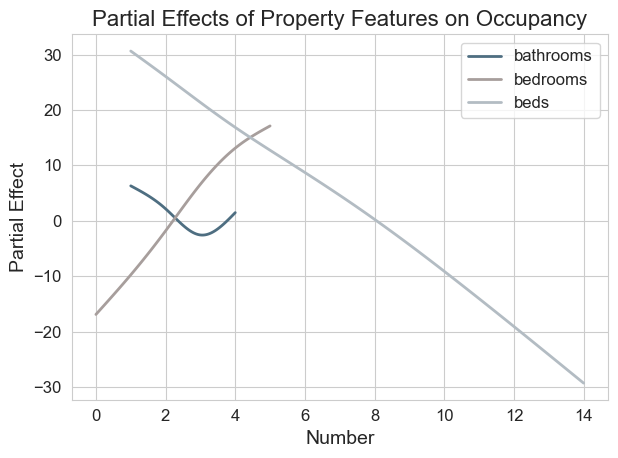

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


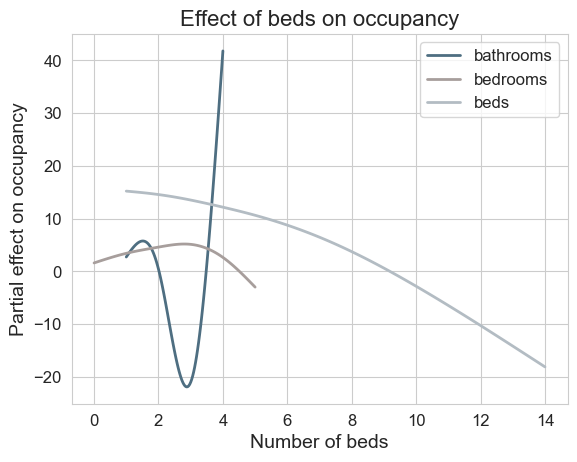

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00


--- MÁLAGA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.5241
Link Function:                     IdentityLink Log Likelihood:                                 -3867.5513
Number of Samples:                          485 AIC:                                             7748.1508
                                                AICc:                                            7748.3564
                                                GCV:                                             1182.8249
                                                Scale:                                           1158.5996
                                                Pseudo R-Squared:                                   0.0055
Feature Function     

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00


--- SEVILLA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.7292
Link Function:                     IdentityLink Log Likelihood:                                 -3787.1513
Number of Samples:                          481 AIC:                                              7589.761
                                                AICc:                                            7590.0468
                                                GCV:                                             1074.4438
                                                Scale:                                           1047.4213
                                                Pseudo R-Squared:                                    0.017
Feature Function    

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



--- MENORCA ---
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.3296
Link Function:                     IdentityLink Log Likelihood:                                  -1680.973
Number of Samples:                          211 AIC:                                             3374.6053
                                                AICc:                                            3375.0608
                                                GCV:                                             1204.4241
                                                Scale:                                           1149.7897
                                                Pseudo R-Squared:                                    0.023
Feature Function    

In [110]:
for city in city_order:
    X = df_long[(df_long['city'] == city) & (df_long['period']==365)][['bathrooms', 'bedrooms',  'beds']].dropna()
    X_array = X.to_numpy()
    y = df_long[(df_long['city'] == city) & (df_long['period']==365)].loc[X.index, 'occupancy_percentage']
    
    # fit GAM with smooth functions (spline) for each feature
    #gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)
    
    # use gridsearch to optimize smoothness penalties
    gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_array, y)
    print(f"\n--- {city.upper()} ---")
    print(gam.summary())

    if any(p < 0.05 for p in gam.statistics_['p_values'][:-1]):
        for i, feature in enumerate(property_features):
            XX = gam.generate_X_grid(term=i)
            pdep = gam.partial_dependence(term=i, X=XX)
            plt.plot(XX[:, i], pdep, label=feature, linewidth=2)
        
        plt.title('Partial Effects of Property Features on Occupancy')
        plt.xlabel('Number')
        plt.ylabel('Partial Effect')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        for col in property_features:
            X = df_long[(df_long['city'] == city) & (df_long['period']==365)][col].dropna()
            X_array = X.to_numpy().reshape(-1, 1)
            y = df_long[(df_long['city'] == city) & (df_long['period']==365)].loc[X.index, 'occupancy_percentage']
        
            # fit GAM with smooth functions (spline) for each feature
            gam = LinearGAM(s(0)).gridsearch(X_array, y)
            
            # plot the partial dependence
            XX = gam.generate_X_grid(term=0)
            plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), linewidth=2, label=col)
            plt.title(f'Effect of {col} on occupancy')
            plt.xlabel(f'Number of {col}')
            plt.ylabel('Partial effect on occupancy')
            plt.grid(True)
        
        plt.legend()
        plt.show()

## ML Modeling

In [111]:
df_ds = df_long.query('period==30')[['city', 'occupancy_percentage', 'bathrooms', 'bedrooms', 'beds']].dropna()
df_ds['city'] = df_ds['city'].astype('category')
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9252 entries, 0 to 9646
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   city                  9252 non-null   category
 1   occupancy_percentage  9252 non-null   float64 
 2   bathrooms             9252 non-null   float64 
 3   bedrooms              9252 non-null   float64 
 4   beds                  9252 non-null   float64 
dtypes: category(1), float64(4)
memory usage: 370.8 KB


In [112]:
# train/test split
df_train, df_test = train_test_split(df_ds, test_size=0.2, 
                                     shuffle=True, random_state=RANDOM_STATE)
print('Sizes of training/test data:')
df_train.shape, df_test.shape

Sizes of training/test data:


((7401, 5), (1851, 5))

In [113]:
# target and features
X_train, X_test = df_train.drop('occupancy_percentage', axis=1), df_test.drop('occupancy_percentage', axis=1)
y_train, y_test = df_train['occupancy_percentage'], df_test['occupancy_percentage']

In [114]:
# preprocessing for RandomForest: encoded features
categorical_features = ['city']
numerical_features = ['bathrooms', 'bedrooms', 'beds']

preprocess_rf = ColumnTransformer([
    ('cat', OrdinalEncoder(), categorical_features),
    ('num', 'passthrough', numerical_features)
])

# gradient boosting models do not need encoded features
preprocess_gb = 'passthrough'

In [115]:
# create the pipeline
pipeline = Pipeline([('preprocess', preprocess_rf),
                     ('regr', DummyRegressor())])

In [116]:
# set grid search params
params = [
    {'regr': [RandomForestRegressor(random_state=RANDOM_STATE)],
     'preprocess': [preprocess_rf],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': [4, 6, 8, None],
     'regr__max_features': ['auto', 'sqrt', 0.7]},
    
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
     'preprocess': [preprocess_gb],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]}, 
       
    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE)],
     'preprocess': [preprocess_gb],
     'regr__n_estimators': range(20, 200, 10),
     'regr__depth': range(4, 12),
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}
]

In [117]:
# construct grid search
grid = RandomizedSearchCV(pipeline,
                          params,
                          cv=3,
                          verbose=False,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [118]:
# fit the grid search object
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               ['city']),
                                                                              ('num',
                                                                               'passthrough',
                                                                               ['bathrooms',
                                                                                'bedrooms',
                                                                                'beds'])])),
                                             ('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'preprocess': [ColumnTransformer(transformers=[('cat',
                                                                                         OrdinalEncoder(),
                                                                                         ['city']),
                                                                                        ('num',
                                                                                         'passthrough',
                                                                                         ['...
                                         'regr__n_estimators': range(20, 200, 10),
                                         'regr__num_leaves': range(35, 150)},
                                        {'preprocess': ['passthrough'],
                                         'regr': [<catboost.core.CatBoostRegressor object at 0x13471a2f0>],
                                         'regr__depth': range(4, 12),
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200, 10)}],
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=False)

In [119]:
# hyperparameters of the best model
print('Hyperparameters of the best model:')
grid.best_params_

Hyperparameters of the best model:


{'regr__num_leaves': 109,
 'regr__n_estimators': 20,
 'regr__max_depth': 4,
 'regr__learning_rate': 0.1,
 'regr': LGBMRegressor(random_state=42, verbose=-1),
 'preprocess': 'passthrough'}

In [120]:
# MAE
avg_mae = abs(grid.best_score_)

# STD
sd_mae = grid.cv_results_['std_test_score'][grid.best_index_]

print(f'\nMean monthly occupancy: {y_train.mean():.2f}')
print(f'Average Cross-Validation MAE: {avg_mae:.2f}, SD: {sd_mae:.2f}')


Mean monthly occupancy: 56.56
Average Cross-Validation MAE: 35.76, SD: 0.22


In [121]:
# Evaluate the model
y_pred = grid.predict(X_test)
print(f'Test MAE = {mean_absolute_error(y_test, y_pred):.2f}')

Test MAE = 35.04


In [122]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="median")
# Fit the model on the training data
dummy_regr.fit(X_train, y_train)

# Make predictions on the test data
pred_dummy = dummy_regr.predict(X_test)

# Evaluate the model
MAE_dummy = mean_absolute_error(y_test, pred_dummy)

print('MAE of constant mosel:', round(MAE_dummy, 4))

MAE of constant mosel: 35.2188


ΔMAE ≈ 0.2 means the model does capture signal, but it’s weak, possibly due to:

- Limited predictors (only city, beds, bathrooms, bedrooms)
- High noise/polarization in occupancy
- City-level heterogeneity not fully modeled

In [123]:
# fit model on all train set
model = LGBMRegressor(max_depth=4, n_estimators=20, num_leaves=109, learning_rate=0.1, random_state=RANDOM_STATE, verbose=-1)

model.fit(X_train, y_train)

LGBMRegressor(max_depth=4, n_estimators=20, num_leaves=109, random_state=42,
              verbose=-1)

In [124]:
# Evaluate the model
print(f'\nMean monthly occupancy: {y_train.mean():.2f}')
y_pred = model.predict(X_test)
print(f'Test MAE = {mean_absolute_error(y_test, y_pred):.2f}')


Mean monthly occupancy: 56.56
Test MAE = 35.04


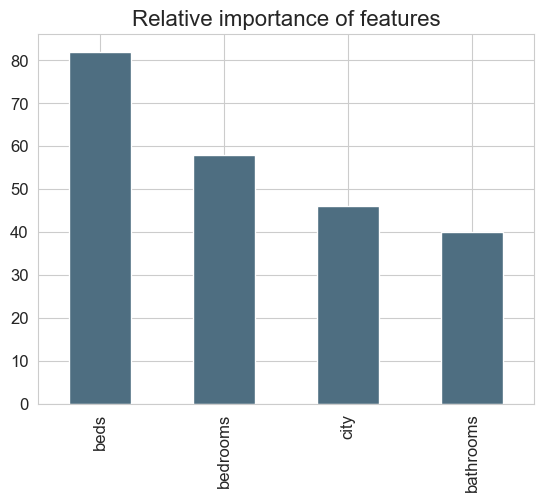

In [125]:
# Importance of the features for best model
feature_importances = pd.DataFrame(
    {'features': list(X_train),
     'feature_importance': model.feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Relative importance of features')
plt.xlabel(None)
plt.show()

### SHAP feature significance

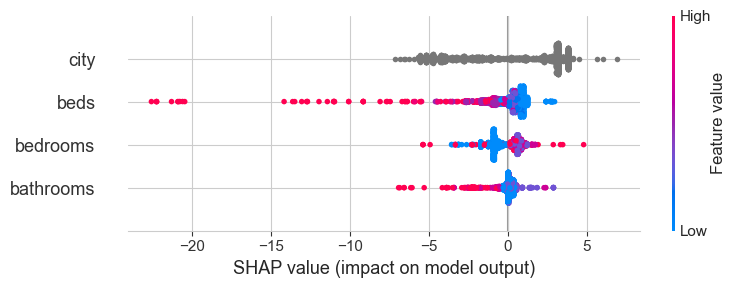

In [126]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)

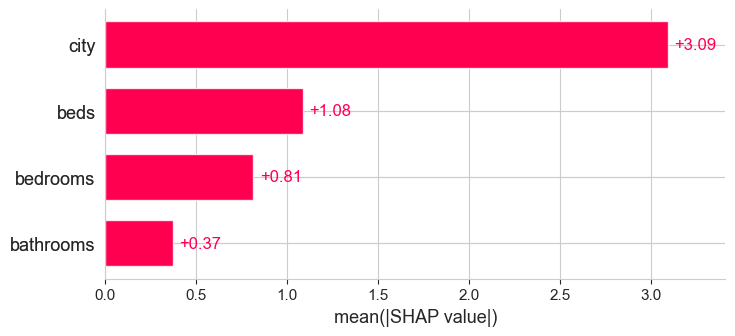

In [127]:
# which features are most important overall for predictions
shap.plots.bar(shap_values)

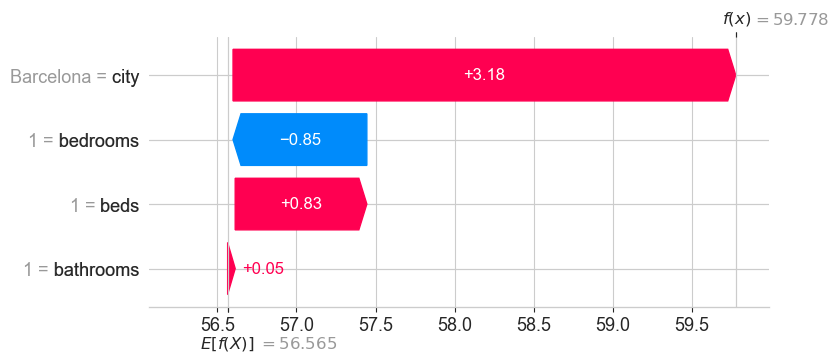

In [128]:
# Example: Explain the first prediction in test set
shap.plots.waterfall(shap_values[0])

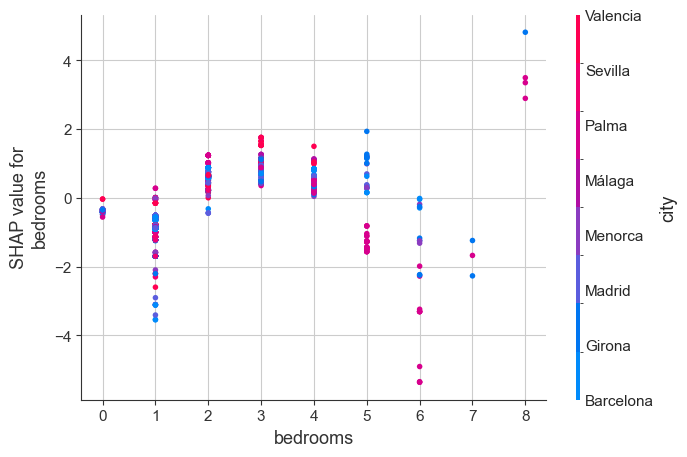

In [129]:
shap.dependence_plot('bedrooms', shap_values.values, X_test, interaction_index='city')

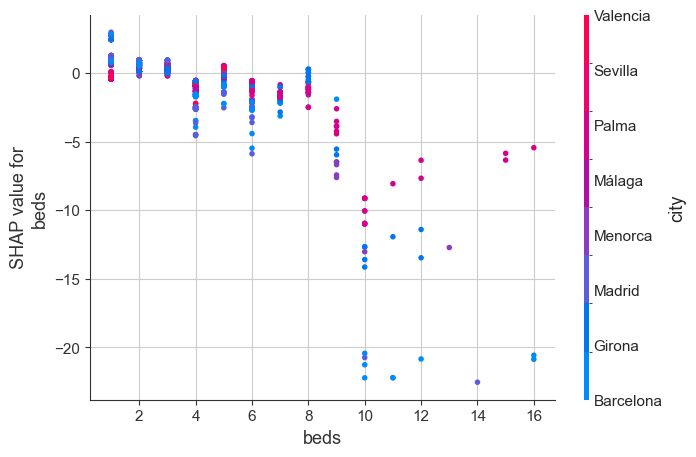

In [130]:
shap.dependence_plot('beds', shap_values.values, X_test, interaction_index='city')

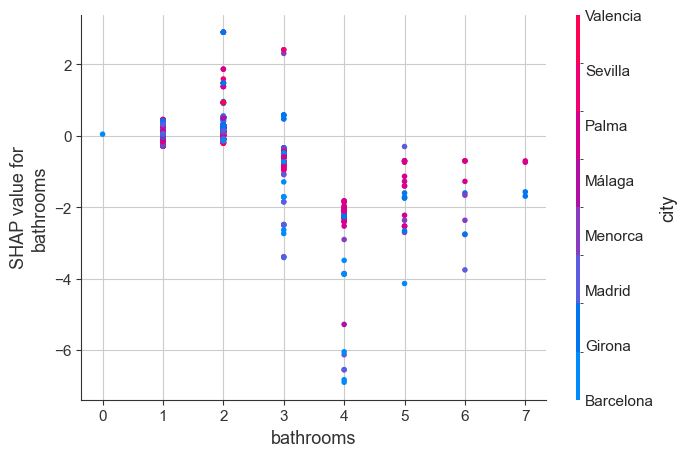

In [131]:
shap.dependence_plot('bathrooms', shap_values.values, X_test, interaction_index='city')

------BARCELONA-------
Sizes of training/test data:
(2057, 5) (515, 5)

Mean monthly occupancy: 60.17
Test MAE = 33.75


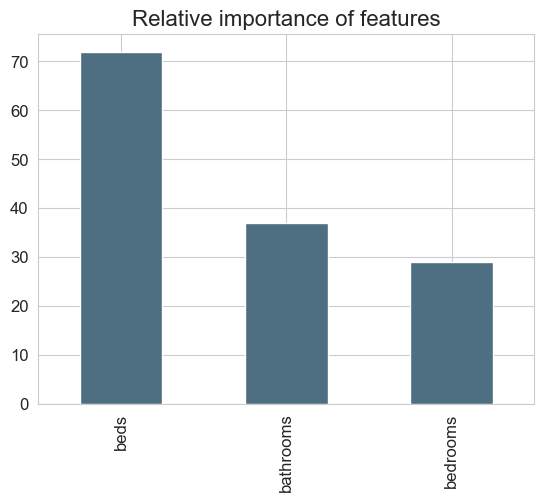

SHAP Summary Plot:


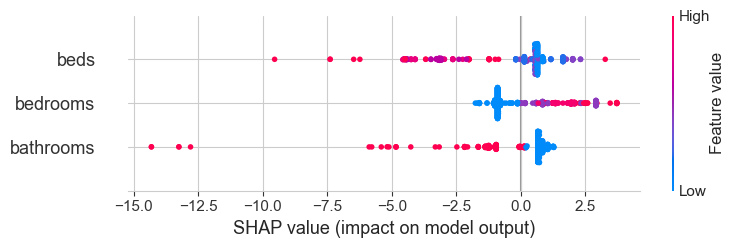

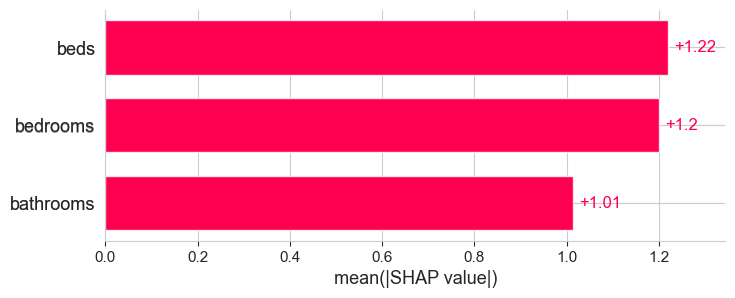

------MADRID-------
Sizes of training/test data:
(1618, 5) (405, 5)

Mean monthly occupancy: 61.21
Test MAE = 33.73


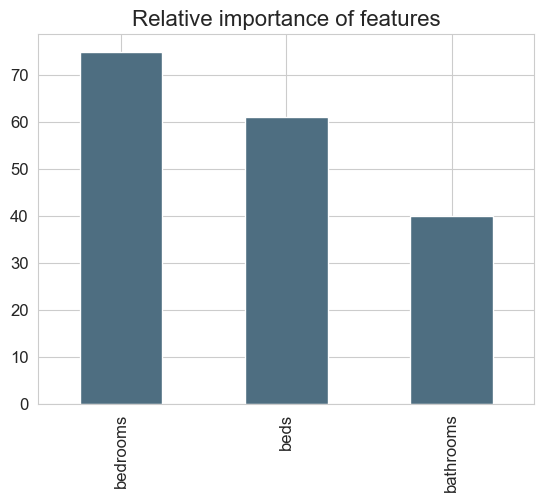

SHAP Summary Plot:


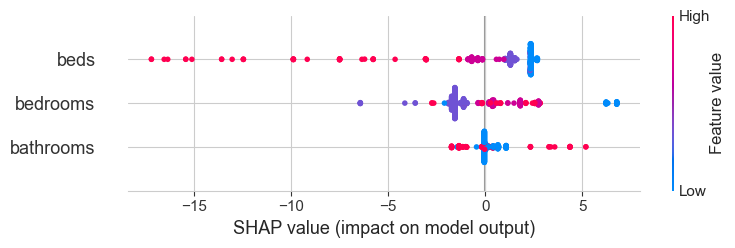

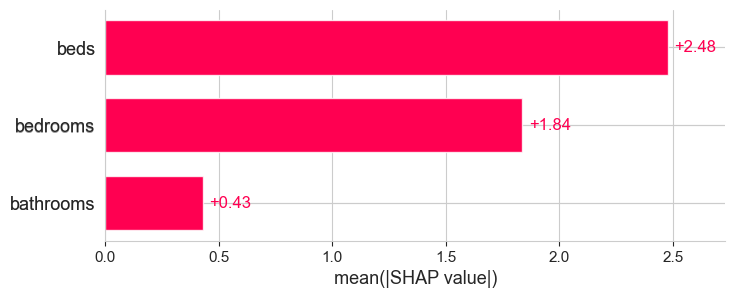

------PALMA-------
Sizes of training/test data:
(1229, 5) (308, 5)

Mean monthly occupancy: 52.87
Test MAE = 36.33


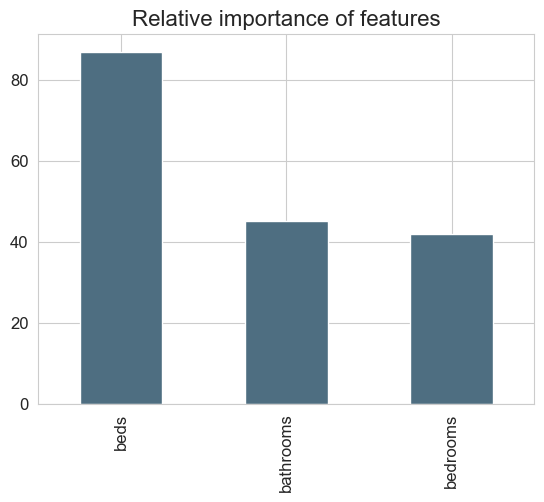

SHAP Summary Plot:


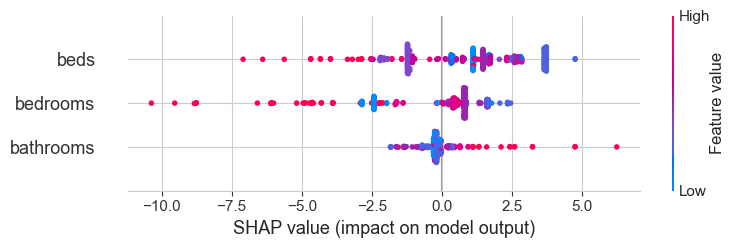

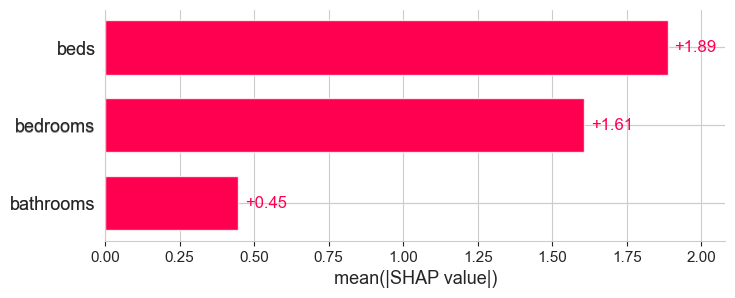

------GIRONA-------
Sizes of training/test data:
(1160, 5) (291, 5)

Mean monthly occupancy: 50.24
Test MAE = 40.35


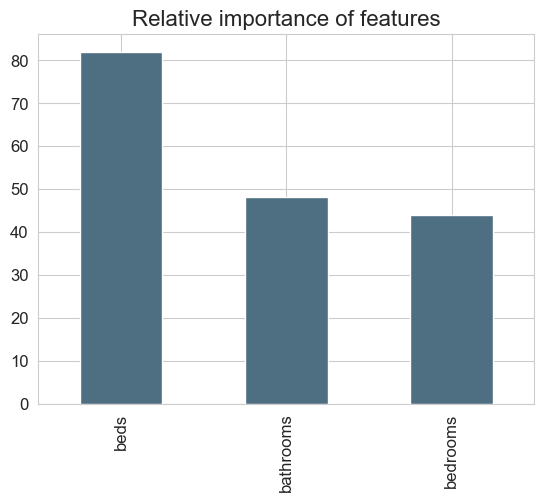

SHAP Summary Plot:


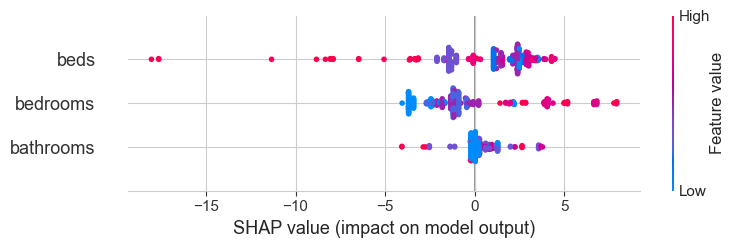

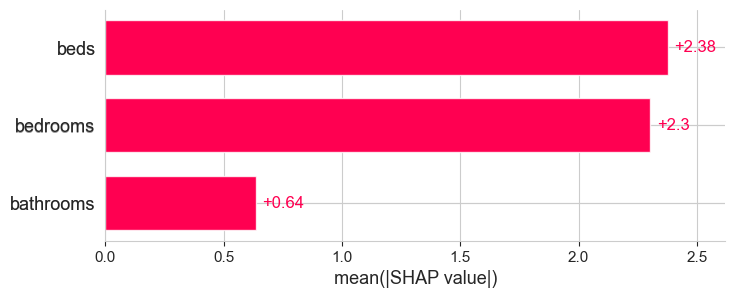

------VALENCIA-------
Sizes of training/test data:
(393, 5) (99, 5)

Mean monthly occupancy: 55.51
Test MAE = 35.95


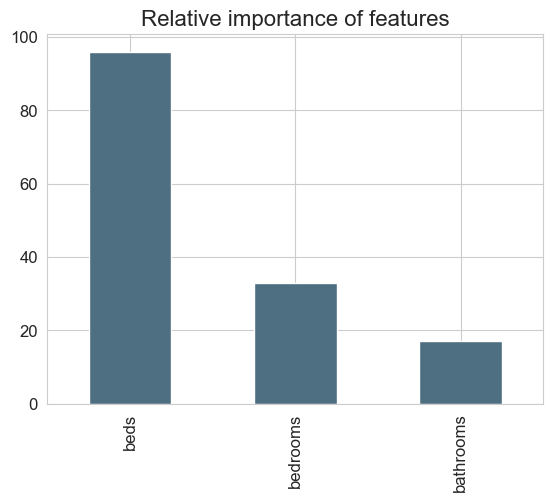

SHAP Summary Plot:


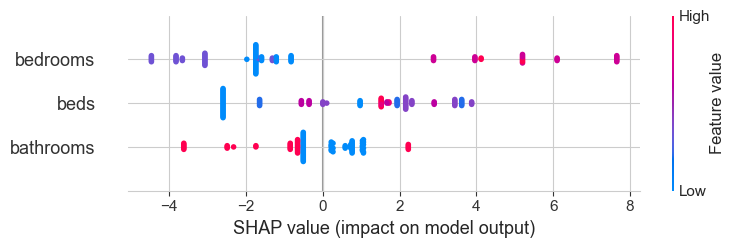

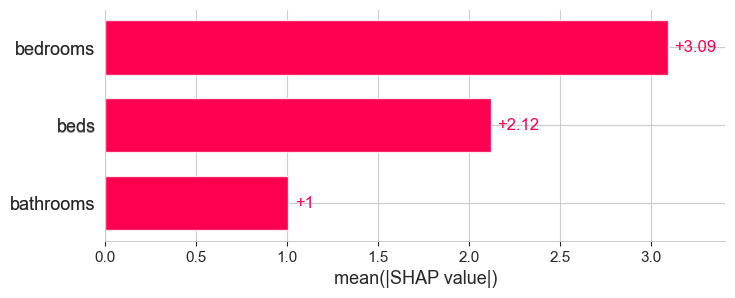

------MÁLAGA-------
Sizes of training/test data:
(388, 5) (97, 5)

Mean monthly occupancy: 59.27
Test MAE = 35.58


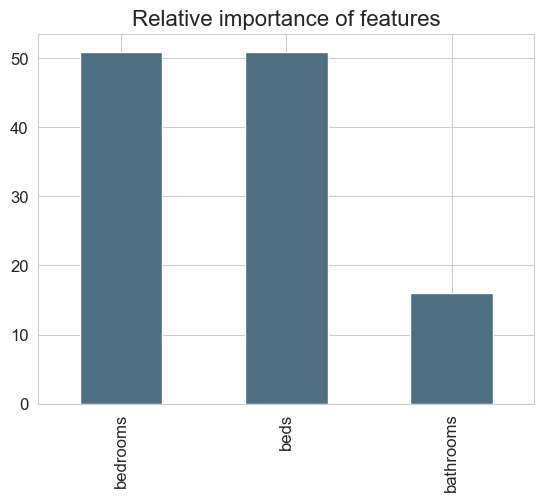

SHAP Summary Plot:


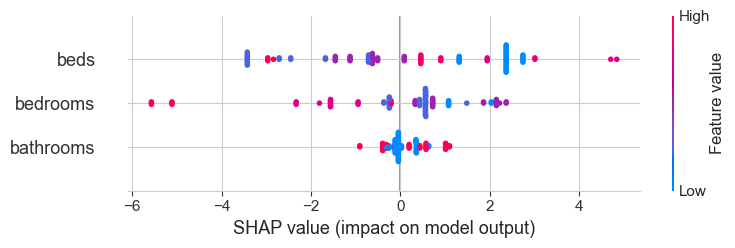

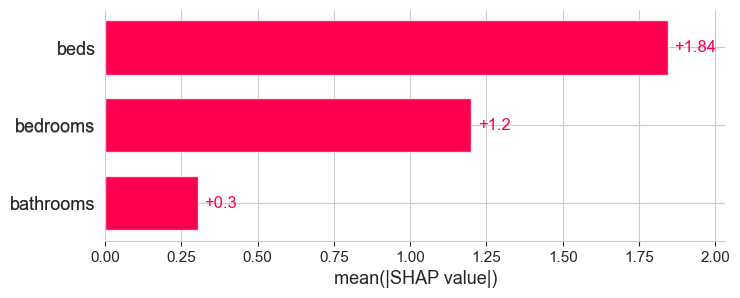

------SEVILLA-------
Sizes of training/test data:
(384, 5) (97, 5)

Mean monthly occupancy: 50.12
Test MAE = 32.44


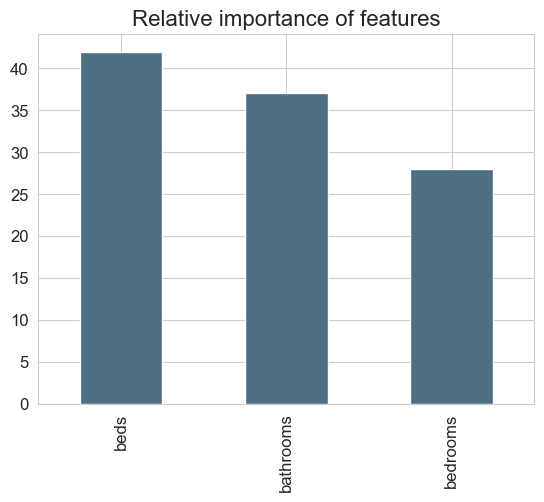

SHAP Summary Plot:


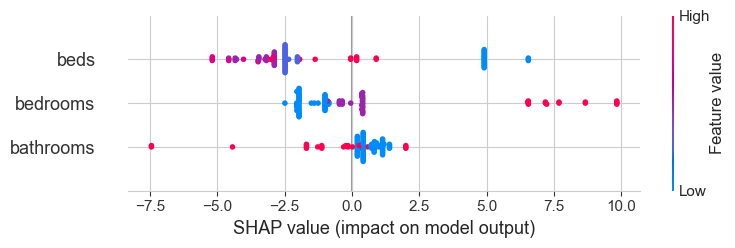

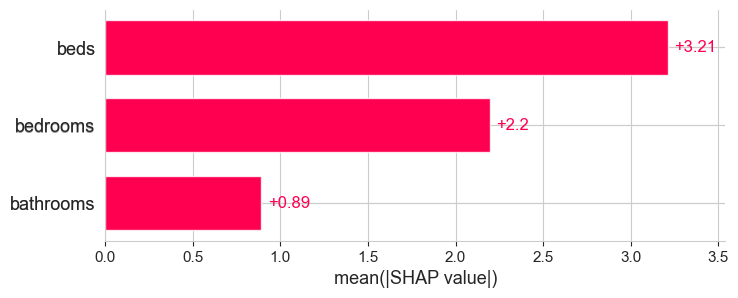

------MENORCA-------
Sizes of training/test data:
(168, 5) (43, 5)

Mean monthly occupancy: 53.51
Test MAE = 41.72


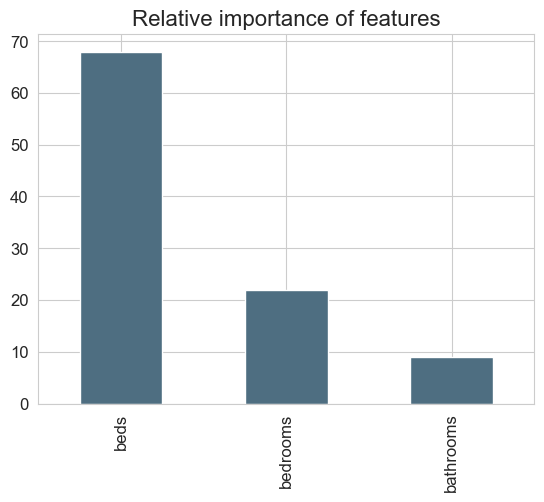

SHAP Summary Plot:


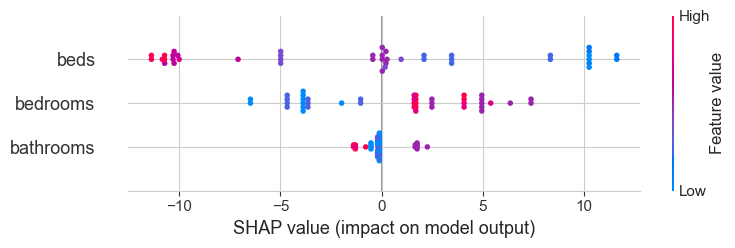

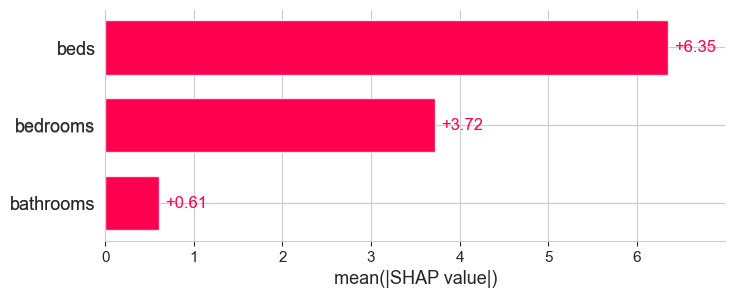

In [132]:
for city in city_order:
    print(f'------{city.upper()}-------')
    df_city = df_ds[df_ds['city']==city]
    
    # train/test split
    df_train, df_test = train_test_split(df_city, test_size=0.2, 
                                         shuffle=True, random_state=RANDOM_STATE)
    print('Sizes of training/test data:')
    print(df_train.shape, df_test.shape)
    
    # target and features
    X_train, X_test = df_train.drop(['occupancy_percentage', 'city'], axis=1), df_test.drop(['occupancy_percentage', 'city'], axis=1)
    y_train, y_test = df_train['occupancy_percentage'], df_test['occupancy_percentage']
    
    model = LGBMRegressor(max_depth=4, n_estimators=20, num_leaves=109, learning_rate=0.1, random_state=RANDOM_STATE, verbose=-1)
    model.fit(X_train, y_train)
    # Evaluate the model
    y_pred = model.predict(X_test)
    print(f'\nMean monthly occupancy: {y_train.mean():.2f}')
    print(f'Test MAE = {mean_absolute_error(y_test, y_pred):.2f}')

    # Importance of the features for best model
    feature_importances = pd.DataFrame(
        {'features': list(X_train),
         'feature_importance': model.feature_importances_})
    
    # plot feature importances
    feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
    plt.title('Relative importance of features')
    plt.xlabel(None)
    plt.show()

    shap.initjs()
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    # SHAP Summary Plot
    print("SHAP Summary Plot:")
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
    plt.show()

    # which features are most important overall for predictions
    shap.plots.bar(shap_values)
    plt.show()

## Conclusion and Recommendations

